# Designing Agents for the Sailing Challenge

In this notebook, we'll explore how to design and implement agents for the Sailing Challenge. We'll cover:

1. The requirements and interface for valid agents
2. Understanding the greedy agent example 
3. Implementing a simple reinforcement learning agent

By the end of this notebook, you'll have a clear understanding of how to create your own agents that can navigate the sailing environment effectively.

## Agent Requirements

All agents in the Sailing Challenge must implement a specific interface defined by the `BaseAgent` abstract class. Let's examine this class to understand what's required:

In [2]:
import sys
import os
import numpy as np

# Add the src directory to the path
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('..'))

# Import the BaseAgent class
from src.agents.base_agent import BaseAgent

# Display the BaseAgent class documentation
#help(BaseAgent)

### Required Methods

As we can see from the `BaseAgent` class, any valid agent must implement:

1. **`act(observation)`**: The core decision-making method that takes the current observation and returns an action
   - Input: A numpy array containing [x, y, vx, vy, wx, wy, ...] representing position, velocity, wind, and the full wind field
   - Output: An integer in the range [0-8] representing the action to take

2. **`reset()`**: Resets the agent's internal state at the beginning of each episode
   - This is particularly important for agents that maintain memory or state across steps

3. **`seed(seed)`**: Sets the random seed for the agent to ensure reproducibility
   - This is crucial for evaluation and comparison of different agents

Additionally, while not strictly required, implementing `save()` and `load()` methods is recommended for storing and retrieving trained agent parameters.

### The Validation Process

When you submit an agent, it will be automatically validated against these requirements. The validation process checks:

1. If the agent class inherits from `BaseAgent`
2. If all required methods are implemented with correct parameters
3. If the agent produces valid actions (integers in range [0-8])
4. If the agent can interact with the environment without errors

Let's create a minimal valid agent to understand this process better:

In [3]:
class MinimalAgent(BaseAgent):
    """A minimal valid agent that meets all interface requirements."""
    
    def __init__(self):
        super().__init__()
        self.np_random = np.random.default_rng()
    
    def act(self, observation: np.ndarray) -> int:
        """Choose an action randomly."""
        return self.np_random.integers(0, 9)  # Random action from 0-8
    
    def reset(self) -> None:
        """Reset the agent."""
        pass  # Nothing to reset in this simple agent
    
    def seed(self, seed: int = None) -> None:
        """Set the random seed."""
        self.np_random = np.random.default_rng(seed)

# Create an instance of our minimal agent
minimal_agent = MinimalAgent()

### Testing the Agent's Validity

Let's make the agent do a few steps to check that everything is working

In [4]:
# Instead of validating the agent here, we'll just demonstrate it on a simple task
from src.env_sailing import SailingEnv

# Create a simple environment
env = SailingEnv()
observation, info = env.reset(seed=42)

# Initialize our minimal agent
minimal_agent = MinimalAgent()
minimal_agent.seed(42)

# Run the agent for a few steps
print("Running the minimal agent for 5 steps:")
for i in range(5):
    action = minimal_agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    print(f"Step {i+1}: Action={action}, Position={info['position']}, Reward={reward}")

Running the minimal agent for 5 steps:
Step 1: Action=0, Position=[16  1], Reward=0.0
Step 2: Action=6, Position=[15  1], Reward=0.0
Step 3: Action=5, Position=[14  0], Reward=0.0
Step 4: Action=3, Position=[15  0], Reward=0.0
Step 5: Action=3, Position=[16  0], Reward=0.0


### Validating Your Agent

After creating your agent, you'll want to ensure it meets all the requirements of the challenge. There are two ways to validate your agent:

1. **Using the `validate_agent.ipynb` notebook:**
   - This notebook provides a comprehensive interface for testing your agent
   - It shows detailed validation results and explains any issues

2. **Using the command line:**
   ```bash
   cd src
   python test_agent_validity.py path/to/your_agent.py
   ```

We recommend using these tools after you've completed your agent implementation rather than trying to validate it during development.

For now, let's focus on understanding agent design principles and implementing effective strategies.

## Understanding the Observation and Action Space

To design effective agents, it's important to understand:

1. **What information is available to the agent (observations)**
2. **What actions the agent can take**

### Observation Space

The observation provided to your agent is a numpy array with the following structure:

`[x, y, vx, vy, wx, wy, flattened_wind_field]`


Where:
- `x, y`: Current position (grid coordinates)
- `vx, vy`: Current velocity vector 
- `wx, wy`: Wind vector at the current position
- `flattened_wind_field`: The entire wind field (can be reshaped to grid_size × grid_size × 2)

For simpler agents, you might only need to use the first 6 values. More sophisticated agents can use the full wind field to plan ahead.

### Action Space

The agent can choose from 9 possible actions:

- 0: Move North (up)
- 1: Move Northeast
- 2: Move East (right)
- 3: Move Southeast
- 4: Move South (down)
- 5: Move Southwest
- 6: Move West (left)
- 7: Move Northwest
- 8: Stay in place

Each action represents a desired direction for the boat to move. However, the actual movement will be influenced by the wind and sailing physics.

## The Naive Agent Example

Let's examine the built-in `NaiveAgent`, which provides a simple baseline implementation. This agent always tries to move North (toward the goal), regardless of wind conditions.

In [5]:
# Import the NaiveAgent
from src.agents.agent_naive import NaiveAgent

# Display the source code
import inspect
print(inspect.getsource(NaiveAgent))

class NaiveAgent(BaseAgent):
    """
    A naive agent for the Sailing Challenge.
    
    This is a very simple agent that always chooses to go North,
    regardless of wind conditions or position. It serves as a minimal
    working example that students can build upon.
    """
    
    def __init__(self):
        """Initialize the agent."""
        super().__init__()
        self.np_random = np.random.default_rng()
    
    def act(self, observation: np.ndarray) -> int:
        """
        Select an action based on the current observation.
        
        Args:
            observation: A numpy array containing the current observation.
                Format: [x, y, vx, vy, wx, wy] where:
                - (x, y) is the current position
                - (vx, vy) is the current velocity
                - (wx, wy) is the current wind vector
        
        Returns:
            action: An integer in [0, 8] representing the action to take:
                - 0: Move North
              

### Analysis of the Naive Agent

The `NaiveAgent` is extremely simple but illustrates the key requirements for a valid agent:

1. **Inheritance**: It inherits from `BaseAgent`
2. **Required Methods**: It implements all required methods (`act`, `reset`, `seed`)
3. **Action Selection**: It always returns action `0` (North)
4. **Simplicity**: It maintains no internal state and requires no complex logic

This agent provides a good baseline, but it has obvious limitations:

- It ignores wind conditions completely
- It will struggle when the wind is coming from the North
- It doesn't adapt its strategy based on the environment

Let's test the naive agent to see how well it performs:

In [6]:
from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Create an environment with a simple test initial windfield
env = SailingEnv(**get_initial_windfield('simple_static'))
naive_agent = NaiveAgent()

# Run a single episode
observation, info = env.reset(seed=42)
total_reward = 0
done = False
truncated = False
step_count = 0

print("Running the naive agent on the simple_static initial windfield:")
while not (done or truncated) and step_count < 1000:  # Limit to 100 steps
    action = naive_agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    total_reward += reward
    step_count += 1
    
    # Print every 10 steps to avoid too much output
    if step_count % 10 == 0:
        print(f"Step {step_count}: Position={info['position']}, Reward={reward}")

print(f"\nEpisode finished after {step_count} steps with reward: {total_reward}")
print(f"Final position: {info['position']}")
print(f"Goal reached: {done}")

Running the naive agent on the simple_static initial windfield:
Step 10: Position=[16  7], Reward=0.0
Step 20: Position=[16 12], Reward=0.0
Step 30: Position=[16 13], Reward=0.0
Step 40: Position=[16 13], Reward=0.0
Step 50: Position=[16 14], Reward=0.0
Step 60: Position=[16 14], Reward=0.0
Step 70: Position=[16 15], Reward=0.0
Step 80: Position=[16 15], Reward=0.0
Step 90: Position=[16 16], Reward=0.0
Step 100: Position=[16 16], Reward=0.0
Step 110: Position=[16 17], Reward=0.0
Step 120: Position=[16 18], Reward=0.0
Step 130: Position=[16 18], Reward=0.0
Step 140: Position=[16 19], Reward=0.0
Step 150: Position=[16 19], Reward=0.0
Step 160: Position=[16 20], Reward=0.0
Step 170: Position=[16 20], Reward=0.0
Step 180: Position=[16 21], Reward=0.0
Step 190: Position=[16 21], Reward=0.0
Step 200: Position=[16 22], Reward=0.0
Step 210: Position=[16 22], Reward=0.0
Step 220: Position=[16 23], Reward=0.0
Step 230: Position=[16 24], Reward=0.0
Step 240: Position=[16 24], Reward=0.0
Step 250:

### Improving on the Naive Agent

The naive agent provides a good starting point, but there are many ways to improve it:

1. **Wind-Aware Agent**: Consider wind direction when choosing actions
2. **Goal-Directed Agent**: Calculate the direction to the goal and choose actions accordingly
3. **Physics-Based Agent**: Use sailing physics equations to determine the most efficient action

The key insight for sailing is that certain directions relative to the wind are more efficient than others:

- The sailing efficiency is highest when moving perpendicular to the wind (beam reach)
- It's difficult to sail directly into the wind (the "no-go zone" - less than 45° to the wind)
- The boat maintains momentum (inertia) between steps

Before diving into reinforcement learning, consider implementing a simple rule-based agent that incorporates these physics principles.

# Amélioration d'un agent naive avec le vent l'objectif et les équations physiques

In [8]:
class ImprovedSailingAgent(BaseAgent):
    """
    Un agent de voile amélioré qui utilise les principes de base de la physique de la navigation à voile.
    Cet agent tient compte de:
    1. La direction du vent
    2. L'angle optimal par rapport au vent
    3. La position de l'objectif
    """
    
    def __init__(self):
        super().__init__()
        self.np_random = np.random.default_rng()
        # Définir les angles optimaux pour la navigation
        self.optimal_wind_angles = [90, 120]  # Angles en degrés (perpendiculaire et grand largue)
        # La zone de non-navigation (no-go zone) est typiquement ±45° face au vent
        self.no_go_angle = 45
    
    def act(self, observation: np.ndarray) -> int:
        """
        Choisir une action en fonction des conditions de vent et de la position de l'objectif.
        
        Args:
            observation: Un tableau numpy contenant l'observation actuelle.
                Format: [x, y, vx, vy, wx, wy, ...] où:
                - (x, y) est la position actuelle
                - (vx, vy) est la vitesse actuelle
                - (wx, wy) est le vecteur de vent actuel
                - le reste contient le champ de vent complet
        
        Returns:
            int: L'action choisie (0-8)
        """
        # Extraire les informations pertinentes de l'observation
        position = observation[:2]  # [x, y]
        velocity = observation[2:4]  # [vx, vy]
        wind = observation[4:6]  # [wx, wy]
        
        # Dans un environnement SailingEnv typique, l'objectif est en haut de la grille
        # Nous supposons que l'objectif est à la position [16, 31] basé sur l'exemple
        goal_position = np.array([16, 31])
        
        # Calculer le vecteur vers l'objectif
        direction_to_goal = goal_position - position
        distance_to_goal = np.linalg.norm(direction_to_goal)
        
        # Si nous sommes très proches de l'objectif, essayer de l'atteindre directement
        if distance_to_goal < 2.0:
            return self._get_action_towards_direction(direction_to_goal)
        
        # Calculer l'angle du vent (en degrés)
        wind_angle = np.degrees(np.arctan2(wind[1], wind[0]))
        
        # Calculer l'angle vers l'objectif (en degrés)
        goal_angle = np.degrees(np.arctan2(direction_to_goal[1], direction_to_goal[0]))
        
        # Angle relatif entre le vent et la direction vers l'objectif
        relative_angle = (goal_angle - wind_angle) % 360
        
        # Vérifier si l'objectif est dans la zone de non-navigation
        if relative_angle < self.no_go_angle or relative_angle > 360 - self.no_go_angle:
            # L'objectif est face au vent, nous devons tacker (zigzaguer)
            return self._tacking_strategy(wind_angle, position)
        else:
            # Nous pouvons naviguer plus directement vers l'objectif
            # Mais ajustons notre angle pour optimiser la vitesse
            return self._optimize_sailing_angle(wind_angle, goal_angle, direction_to_goal)
    
    def _get_action_towards_direction(self, direction):
        """Convertit un vecteur de direction en action discrète (0-8)."""
        # Normaliser le vecteur de direction
        if np.linalg.norm(direction) > 0:
            direction = direction / np.linalg.norm(direction)
        
        # Cartographier les 8 directions aux actions
        # [N, NE, E, SE, S, SW, W, NW]
        actions_map = [
            (0, 1),    # 0: Nord
            (1, 1),    # 1: Nord-Est
            (1, 0),    # 2: Est
            (1, -1),   # 3: Sud-Est
            (0, -1),   # 4: Sud
            (-1, -1),  # 5: Sud-Ouest
            (-1, 0),   # 6: Ouest
            (-1, 1),   # 7: Nord-Ouest
        ]
        
        # Calculer l'action qui correspond le mieux à la direction
        best_action = 0
        best_similarity = -float('inf')
        
        for i, action_dir in enumerate(actions_map):
            similarity = direction[0] * action_dir[0] + direction[1] * action_dir[1]
            if similarity > best_similarity:
                best_similarity = similarity
                best_action = i
        
        return best_action
    
    def _tacking_strategy(self, wind_angle, position):
        """
        Implémente une stratégie de tacking (virement de bord) lorsque l'objectif est face au vent.
        Alterne entre naviguer à environ 45-60° de chaque côté du vent.
        """
        # Décider de quel côté virer en fonction de la position x
        # Cela crée un zigzag naturel
        if position[0] < 16:  # À gauche du centre, virer à tribord
            tack_angle = wind_angle + 60
        else:  # À droite du centre, virer à bâbord
            tack_angle = wind_angle - 60
        
        # Convertir l'angle en vecteur de direction
        tack_direction = np.array([np.cos(np.radians(tack_angle)), np.sin(np.radians(tack_angle))])
        
        # Obtenir l'action correspondante
        return self._get_action_towards_direction(tack_direction)
    
    def _optimize_sailing_angle(self, wind_angle, goal_angle, direction_to_goal):
        """
        Optimise l'angle de navigation pour maximiser la vitesse,
        en se basant sur les angles optimaux par rapport au vent.
        """
        # Trouver l'angle optimal le plus proche de notre direction vers l'objectif
        best_angle = goal_angle  # Par défaut, viser directement l'objectif
        
        # Calculer les angles absolus optimaux (dans les deux sens)
        optimal_angles = []
        for optimal in self.optimal_wind_angles:
            optimal_angles.append((wind_angle + optimal) % 360)
            optimal_angles.append((wind_angle - optimal) % 360)
        
        # Trouver l'angle optimal le plus proche de notre direction vers l'objectif
        angle_diff = [abs((angle - goal_angle) % 360) for angle in optimal_angles]
        min_diff_index = np.argmin(angle_diff)
        
        # Si la différence d'angle est significative, utiliser l'angle optimal
        if angle_diff[min_diff_index] < 45:
            best_angle = optimal_angles[min_diff_index]
        
        # Convertir l'angle en vecteur de direction
        optimal_direction = np.array([np.cos(np.radians(best_angle)), np.sin(np.radians(best_angle))])
        
        # Mélanger la direction optimale avec la direction vers l'objectif
        # Cela permet de progresser vers l'objectif tout en maintenant une bonne vitesse
        mixed_direction = 0.7 * optimal_direction + 0.3 * (direction_to_goal / np.linalg.norm(direction_to_goal))
        
        return self._get_action_towards_direction(mixed_direction)
    
    def reset(self) -> None:
        """Réinitialiser l'agent."""
        pass  # Rien à réinitialiser pour cet agent simple
    
    def seed(self, seed: int = None) -> None:
        """Définir la graine aléatoire."""
        self.np_random = np.random.default_rng(seed)

In [9]:
from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Create an environment with a simple test initial windfield
env = SailingEnv(**get_initial_windfield('simple_static'))
naive_agent = ImprovedSailingAgent()

# Run a single episode
observation, info = env.reset(seed=42)
total_reward = 0
done = False
truncated = False
step_count = 0

print("Running the naive agent on the simple_static initial windfield:")
while not (done or truncated) and step_count < 1000:  # Limit to 100 steps
    action = naive_agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    total_reward += reward
    step_count += 1
    
    # Print every 10 steps to avoid too much output
    if step_count % 10 == 0:
        print(f"Step {step_count}: Position={info['position']}, Reward={reward}")

print(f"\nEpisode finished after {step_count} steps with reward: {total_reward}")
print(f"Final position: {info['position']}")
print(f"Goal reached: {done}")

Running the naive agent on the simple_static initial windfield:
Step 10: Position=[ 6 11], Reward=0.0
Step 20: Position=[ 6 11], Reward=0.0
Step 30: Position=[ 7 12], Reward=0.0
Step 40: Position=[ 8 13], Reward=0.0
Step 50: Position=[ 8 13], Reward=0.0
Step 60: Position=[ 8 15], Reward=0.0
Step 70: Position=[ 7 17], Reward=0.0
Step 80: Position=[ 7 17], Reward=0.0
Step 90: Position=[ 8 18], Reward=0.0
Step 100: Position=[ 9 19], Reward=0.0
Step 110: Position=[ 9 19], Reward=0.0
Step 120: Position=[10 20], Reward=0.0
Step 130: Position=[10 20], Reward=0.0
Step 140: Position=[11 21], Reward=0.0
Step 150: Position=[11 21], Reward=0.0
Step 160: Position=[11 23], Reward=0.0
Step 170: Position=[11 24], Reward=0.0
Step 180: Position=[12 24], Reward=0.0
Step 190: Position=[13 25], Reward=0.0
Step 200: Position=[13 25], Reward=0.0
Step 210: Position=[13 27], Reward=0.0
Step 220: Position=[13 27], Reward=0.0
Step 230: Position=[14 28], Reward=0.0
Step 240: Position=[14 29], Reward=0.0
Step 250:

In [10]:
class AdvancedSailingAgent(BaseAgent):
    """
    Agent de voile avancé avec optimisation complète basée sur la physique de la voile
    et une planification de trajectoire intelligente.
    """
    
    def __init__(self):
        super().__init__()
        self.np_random = np.random.default_rng()
        
        # Paramètres de navigation à voile
        self.polar_data = self._create_sailing_polar()  # Données d'efficacité polaire
        self.tacking_distance = 3.0  # Distance minimale avant de virer de bord
        self.last_tack_position = None  # Pour éviter le virement de bord trop fréquent
        self.last_actions = []  # Historique des actions pour la stabilité
        self.action_history_size = 3  # Nombre d'actions à stocker dans l'historique
        self.wind_prediction_horizon = 5  # Nombre de pas pour la prédiction du vent
        
        # Paramètres adaptatifs
        self.adaptation_rate = 0.1  # Taux d'adaptation aux conditions
        self.performance_history = []  # Historique des performances
        
        # Stratégie globale
        self.upwind_strategy = "tacking"  # tacking ou long_tacking
        self.downwind_strategy = "direct"  # direct ou gybing
        
        # État de navigation
        self.current_leg = "upwind"  # upwind, reaching, downwind
        self.tack_side = "port"  # port (bâbord) ou starboard (tribord)
        
    def _create_sailing_polar(self):
        """
        Crée une table polaire d'efficacité de navigation basée sur l'angle au vent.
        Renvoie un dictionnaire avec {angle: efficacité} où l'angle est en degrés.
        """
        polar = {}
        
        # Zone de non-navigation (irons) - très faible efficacité
        for angle in range(0, 46):
            polar[angle] = 0.1
            polar[360-angle] = 0.1
        
        # Près (close-hauled) - efficacité modérée
        for angle in range(46, 80):
            factor = (angle - 45) / 35  # Augmentation progressive de l'efficacité
            polar[angle] = 0.3 + 0.4 * factor
            polar[360-angle] = 0.3 + 0.4 * factor
        
        # Travers (beam reach) - haute efficacité
        for angle in range(80, 120):
            polar[angle] = 0.9 + 0.1 * np.sin((angle - 80) * np.pi / 80)
            polar[360-angle] = 0.9 + 0.1 * np.sin((angle - 80) * np.pi / 80)
        
        # Grand largue (broad reach) - très haute efficacité
        for angle in range(120, 150):
            polar[angle] = 0.95
            polar[360-angle] = 0.95
        
        # Vent arrière (running) - haute efficacité mais pas optimale
        for angle in range(150, 181):
            factor = (180 - angle) / 30  # Diminution progressive
            polar[angle] = 0.85 + 0.1 * factor
            polar[360-angle] = 0.85 + 0.1 * factor
        
        return polar
    
    def act(self, observation: np.ndarray) -> int:
        """
        Sélectionne l'action optimale basée sur une analyse complète des conditions.
        """
        # Extraire les informations de l'observation
        position = observation[:2]  # [x, y]
        velocity = observation[2:4]  # [vx, vy]
        wind_at_boat = observation[4:6]  # [wx, wy]
        
        # Extraire et analyser le champ de vent complet
        wind_field_data = observation[6:]
        wind_field = self._reconstruct_wind_field(wind_field_data)
        
        # Définir la position de l'objectif (basée sur l'exemple précédent)
        goal_position = np.array([16, 31])
        
        # Calcul des vecteurs et angles principaux
        direction_to_goal = goal_position - position
        distance_to_goal = np.linalg.norm(direction_to_goal)
        
        wind_speed = np.linalg.norm(wind_at_boat)
        wind_angle = np.degrees(np.arctan2(wind_at_boat[1], wind_at_boat[0])) % 360
        
        goal_angle = np.degrees(np.arctan2(direction_to_goal[1], direction_to_goal[0])) % 360
        
        # Angle du bateau (basé sur la vitesse si disponible)
        boat_angle = None
        if np.linalg.norm(velocity) > 0.01:
            boat_angle = np.degrees(np.arctan2(velocity[1], velocity[0])) % 360
        else:
            # Si le bateau n'a pas de vitesse significative, utiliser l'angle vers l'objectif
            boat_angle = goal_angle
        
        # Angle relatif entre le vent et la direction du bateau
        wind_relative_angle = (boat_angle - wind_angle) % 360
        
        # Analyse de l'environnement
        upwind_condition = self._is_upwind(goal_angle, wind_angle)
        downwind_condition = self._is_downwind(goal_angle, wind_angle)
        
        # Déterminer la stratégie en fonction de la situation
        if distance_to_goal < 2.0:
            # Près de l'objectif - naviguer directement
            return self._get_action_towards_direction(direction_to_goal)
        elif upwind_condition:
            # Navigation contre le vent - utiliser la stratégie de louvoyage
            return self._upwind_strategy(position, wind_angle, boat_angle, goal_position, wind_field)
        elif downwind_condition:
            # Navigation avec le vent arrière
            return self._downwind_strategy(position, wind_angle, boat_angle, goal_position, wind_field)
        else:
            # Navigation au travers ou au largue - optimiser l'angle
            return self._optimal_reaching_strategy(position, velocity, wind_angle, boat_angle, goal_position, wind_field)
    
    def _reconstruct_wind_field(self, wind_field_data):
        """
        Reconstruit le champ de vent à partir des données aplaties.
        Pour simplifier, nous retournons les données brutes ici.
        Dans une implémentation complète, vous reconstruiriez une grille 2D.
        """
        return wind_field_data
    
    def _is_upwind(self, goal_angle, wind_angle):
        """Détermine si l'objectif est face au vent (± zone de non-navigation)."""
        relative_angle = (goal_angle - wind_angle) % 360
        return relative_angle < 50 or relative_angle > 310
    
    def _is_downwind(self, goal_angle, wind_angle):
        """Détermine si l'objectif est sous le vent."""
        relative_angle = (goal_angle - wind_angle) % 360
        return 160 < relative_angle < 200
    
    def _get_sailing_efficiency(self, wind_relative_angle):
        """Obtient l'efficacité de navigation pour un angle donné par rapport au vent."""
        angle = int(wind_relative_angle % 360)
        return self.polar_data.get(angle, 0.5)  # Valeur par défaut si l'angle n'est pas dans la table
    
    def _upwind_strategy(self, position, wind_angle, boat_angle, goal_position, wind_field):
        """
        Stratégie de navigation au près (contre le vent).
        Implémente le louvoyage (tacking) de manière optimisée.
        """
        # Calculer la ligne imaginaire de progression vers l'objectif
        goal_direction = goal_position - position
        
        # Déterminer le côté du tack en fonction de la position actuelle
        # Stratégie: zigzag autour de la ligne vers l'objectif
        cross_track = self._cross_track_distance(position, goal_position)
        
        # Changement de bord si nécessaire
        if cross_track > self.tacking_distance:
            self.tack_side = "port" if self.tack_side == "starboard" else "starboard"
            self.last_tack_position = position.copy()
        
        # Calculer l'angle optimal de près
        if self.tack_side == "port":
            tack_angle = (wind_angle + 50) % 360  # 50° tribord du vent
        else:
            tack_angle = (wind_angle - 50) % 360  # 50° bâbord du vent
        
        # Vecteur de direction pour cet angle
        tack_direction = np.array([np.cos(np.radians(tack_angle)), np.sin(np.radians(tack_angle))])
        
        # Vérifier si nous nous éloignons trop de l'objectif
        direction_to_goal = goal_position - position
        angle_to_goal = np.degrees(np.arctan2(direction_to_goal[1], direction_to_goal[0])) % 360
        
        # Si le tack nous éloigne trop de la direction générale, envisager de virer
        angle_diff = min((tack_angle - angle_to_goal) % 360, (angle_to_goal - tack_angle) % 360)
        if angle_diff > 100:  # Nous nous éloignons trop
            # Virer de bord si nous avons parcouru une distance minimale depuis le dernier virement
            if self.last_tack_position is None or np.linalg.norm(position - self.last_tack_position) > 5.0:
                self.tack_side = "port" if self.tack_side == "starboard" else "starboard"
                self.last_tack_position = position.copy()
                # Recalculer l'angle après le virement
                if self.tack_side == "port":
                    tack_angle = (wind_angle + 50) % 360
                else:
                    tack_angle = (wind_angle - 50) % 360
                tack_direction = np.array([np.cos(np.radians(tack_angle)), np.sin(np.radians(tack_angle))])
        
        # Obtenir l'action correspondante avec un léger facteur de stabilité
        action = self._get_action_towards_direction(tack_direction)
        
        # Stabiliser l'action en utilisant l'historique
        if len(self.last_actions) > 0:
            # 80% nouvelle action, 20% moyenne des actions précédentes pour éviter les oscillations
            prev_action = self.last_actions[-1]
            if abs(action - prev_action) <= 1 or abs(action - prev_action) >= 7:  # Actions similaires ou opposées
                action = action  # Garder la nouvelle action
            else:
                # Petite stabilisation
                action = action if self.np_random.random() < 0.8 else prev_action
        
        # Mettre à jour l'historique des actions
        self.last_actions.append(action)
        if len(self.last_actions) > self.action_history_size:
            self.last_actions.pop(0)
        
        return action
    
    def _downwind_strategy(self, position, wind_angle, boat_angle, goal_position, wind_field):
        """
        Stratégie de navigation au portant (avec le vent arrière).
        Implémente une navigation directe ou en zigzag selon les conditions.
        """
        # Direction vers l'objectif
        direction_to_goal = goal_position - position
        goal_angle = np.degrees(np.arctan2(direction_to_goal[1], direction_to_goal[0])) % 360
        
        # Pour le vent arrière, la navigation directe n'est pas toujours optimale
        # Nous pouvons naviguer légèrement de biais pour plus d'efficacité
        
        # Calculer les angles optimaux de chaque côté
        port_angle = (wind_angle + 150) % 360
        starboard_angle = (wind_angle - 150) % 360
        
        # Déterminer quel angle est le plus proche de la direction vers l'objectif
        port_diff = min((port_angle - goal_angle) % 360, (goal_angle - port_angle) % 360)
        starboard_diff = min((starboard_angle - goal_angle) % 360, (goal_angle - starboard_angle) % 360)
        
        # Choisir l'angle optimal
        if port_diff < starboard_diff:
            optimal_angle = port_angle
        else:
            optimal_angle = starboard_angle
        
        # Mixer avec la direction de l'objectif pour garantir la progression
        optimal_direction = np.array([np.cos(np.radians(optimal_angle)), np.sin(np.radians(optimal_angle))])
        goal_direction = direction_to_goal / np.linalg.norm(direction_to_goal)
        
        mixed_direction = 0.6 * optimal_direction + 0.4 * goal_direction
        
        # Obtenir l'action correspondante
        action = self._get_action_towards_direction(mixed_direction)
        
        # Stabiliser l'action
        if len(self.last_actions) > 0:
            prev_action = self.last_actions[-1]
            if action != prev_action and self.np_random.random() < 0.3:
                action = prev_action
        
        # Mettre à jour l'historique
        self.last_actions.append(action)
        if len(self.last_actions) > self.action_history_size:
            self.last_actions.pop(0)
        
        return action
    
    def _optimal_reaching_strategy(self, position, velocity, wind_angle, boat_angle, goal_position, wind_field):
        """
        Stratégie optimale pour la navigation au travers ou au largue.
        Maximise la vitesse tout en se dirigeant vers l'objectif.
        """
        # Direction et angle vers l'objectif
        direction_to_goal = goal_position - position
        goal_angle = np.degrees(np.arctan2(direction_to_goal[1], direction_to_goal[0])) % 360
        
        # Angles de navigation optimaux (au travers)
        optimal_angles = [(wind_angle + 90) % 360, (wind_angle - 90) % 360, 
                          (wind_angle + 120) % 360, (wind_angle - 120) % 360]
        
        # Trouver l'angle optimal le plus proche de notre direction
        best_angle = None
        min_diff = 180
        
        for angle in optimal_angles:
            diff = min((angle - goal_angle) % 360, (goal_angle - angle) % 360)
            if diff < min_diff:
                min_diff = diff
                best_angle = angle
        
        # Direction optimale
        optimal_direction = np.array([np.cos(np.radians(best_angle)), np.sin(np.radians(best_angle))])
        
        # Équilibrer entre direction optimale et direction vers l'objectif
        # Plus nous sommes proches de l'objectif, plus nous privilégions la direction directe
        distance = np.linalg.norm(direction_to_goal)
        goal_weight = max(0.3, min(0.8, 1.0 - distance / 20.0))
        
        goal_direction = direction_to_goal / np.linalg.norm(direction_to_goal)
        mixed_direction = (1 - goal_weight) * optimal_direction + goal_weight * goal_direction
        
        # Obtenir l'action
        action = self._get_action_towards_direction(mixed_direction)
        
        # Stabilisation
        if len(self.last_actions) > 0:
            prev_action = self.last_actions[-1]
            if action != prev_action and self.np_random.random() < 0.2:
                action = prev_action
        
        # Mettre à jour l'historique
        self.last_actions.append(action)
        if len(self.last_actions) > self.action_history_size:
            self.last_actions.pop(0)
        
        return action
    
    def _get_action_towards_direction(self, direction):
        """Convertit un vecteur de direction en action discrète (0-8)."""
        # Normaliser le vecteur
        if np.linalg.norm(direction) > 0:
            direction = direction / np.linalg.norm(direction)
        
        # Cartographier les 8 directions aux actions
        actions_map = [
            (0, 1),    # 0: Nord
            (1, 1),    # 1: Nord-Est
            (1, 0),    # 2: Est
            (1, -1),   # 3: Sud-Est
            (0, -1),   # 4: Sud
            (-1, -1),  # 5: Sud-Ouest
            (-1, 0),   # 6: Ouest
            (-1, 1),   # 7: Nord-Ouest
        ]
        
        # Ajouter l'action "rester sur place"
        actions_map.append((0, 0))  # 8: Rester sur place
        
        # Trouver l'action la plus similaire à la direction
        best_action = 0
        best_similarity = -float('inf')
        
        for i, action_dir in enumerate(actions_map):
            # Pour "rester sur place", utiliser une similarité spéciale
            if i == 8:
                # N'utiliser cette action que si la direction est très faible
                if np.linalg.norm(direction) < 0.2:
                    similarity = 1.0
                else:
                    similarity = -1.0
            else:
                similarity = direction[0] * action_dir[0] + direction[1] * action_dir[1]
            
            if similarity > best_similarity:
                best_similarity = similarity
                best_action = i
        
        return best_action
    
    def _cross_track_distance(self, position, goal_position):
        """
        Calcule la distance perpendiculaire (cross-track) entre la position actuelle
        et la ligne droite allant de la position initiale à l'objectif.
        Pour simplifier, nous supposons que la position initiale est [16, 0].
        """
        start_position = np.array([16, 0])
        
        # Vecteur de la ligne (de départ à objectif)
        track_vector = goal_position - start_position
        track_length = np.linalg.norm(track_vector)
        
        if track_length == 0:
            return np.linalg.norm(position - start_position)
        
        # Normaliser
        track_unit = track_vector / track_length
        
        # Vecteur de la position actuelle au point de départ
        pos_vector = position - start_position
        
        # Projection sur la ligne
        projection = np.dot(pos_vector, track_unit)
        
        # Calculer le point projeté
        projected_point = start_position + projection * track_unit
        
        # Distance perpendiculaire
        return np.linalg.norm(position - projected_point)
    
    def reset(self) -> None:
        """Réinitialiser l'agent."""
        self.last_tack_position = None
        self.last_actions = []
        self.performance_history = []
        self.tack_side = "port" if self.np_random.random() < 0.5 else "starboard"
    
    def seed(self, seed: int = None) -> None:
        """Définir la graine aléatoire."""
        self.np_random = np.random.default_rng(seed)

In [11]:
from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Create an environment with a simple test initial windfield
env = SailingEnv(**get_initial_windfield('simple_static'))
naive_agent = AdvancedSailingAgent()

# Run a single episode
observation, info = env.reset(seed=42)
total_reward = 0
done = False
truncated = False
step_count = 0

print("Running the naive agent on the simple_static initial windfield:")
while not (done or truncated) and step_count < 1000:  # Limit to 100 steps
    action = naive_agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    total_reward += reward
    step_count += 1
    
    # Print every 10 steps to avoid too much output
    if step_count % 10 == 0:
        print(f"Step {step_count}: Position={info['position']}, Reward={reward}")

print(f"\nEpisode finished after {step_count} steps with reward: {total_reward}")
print(f"Final position: {info['position']}")
print(f"Goal reached: {done}")

Running the naive agent on the simple_static initial windfield:
Step 10: Position=[ 6 11], Reward=0.0
Step 20: Position=[ 6 11], Reward=0.0
Step 30: Position=[ 7 12], Reward=0.0
Step 40: Position=[ 8 13], Reward=0.0
Step 50: Position=[ 8 13], Reward=0.0
Step 60: Position=[ 8 15], Reward=0.0
Step 70: Position=[ 7 17], Reward=0.0
Step 80: Position=[ 7 17], Reward=0.0
Step 90: Position=[ 8 18], Reward=0.0
Step 100: Position=[ 9 19], Reward=0.0
Step 110: Position=[ 9 19], Reward=0.0
Step 120: Position=[10 20], Reward=0.0
Step 130: Position=[10 20], Reward=0.0
Step 140: Position=[11 21], Reward=0.0
Step 150: Position=[11 21], Reward=0.0
Step 160: Position=[12 22], Reward=0.0
Step 170: Position=[13 23], Reward=0.0
Step 180: Position=[13 23], Reward=0.0
Step 190: Position=[14 24], Reward=0.0
Step 200: Position=[14 24], Reward=0.0
Step 210: Position=[15 25], Reward=0.0
Step 220: Position=[15 25], Reward=0.0
Step 230: Position=[14 28], Reward=0.0
Step 240: Position=[14 29], Reward=0.0
Step 250:

## Implementing a Simple RL Agent

## Implementing a Q-Learning Agent

Now let's implement a basic Q-learning agent for our sailing environment. Q-learning is a model-free reinforcement learning algorithm that learns to make decisions by estimating the value of state-action pairs.

Our implementation will use a simplified state representation based on:
1. Agent's current position
2. Agent's current velocity 
3. Local wind at the agent's position

This simplified approach makes the agent more interpretable and faster to train, while still capturing essential local information for effective navigation.

In [12]:
class QLearningAgent(BaseAgent):
    """A simple Q-learning agent for the sailing environment using only local information."""
    
    def __init__(self, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        super().__init__()
        self.np_random = np.random.default_rng()
        
        # Learning parameters
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        
        # State discretization parameters
        self.position_bins = 8     # Discretize the grid into 8x8
        self.velocity_bins = 4     # Discretize velocity into 4 bins
        self.wind_bins = 8         # Discretize wind directions into 8 bins
        
        # Initialize Q-table
        # State space: position_x, position_y, velocity_direction, wind_direction
        # Action space: 9 possible actions
        self.q_table = {}
        
    def discretize_state(self, observation):
        """Convert continuous observation to discrete state for Q-table lookup."""
        # Extract position, velocity and wind from observation
        x, y = observation[0], observation[1]
        vx, vy = observation[2], observation[3]
        wx, wy = observation[4], observation[5]
        
        # Discretize position (assume 32x32 grid)
        grid_size = 32
        x_bin = min(int(x / grid_size * self.position_bins), self.position_bins - 1)
        y_bin = min(int(y / grid_size * self.position_bins), self.position_bins - 1)
        
        # Discretize velocity direction (ignoring magnitude for simplicity)
        v_magnitude = np.sqrt(vx**2 + vy**2)
        if v_magnitude < 0.1:  # If velocity is very small, consider it as a separate bin
            v_bin = 0
        else:
            v_direction = np.arctan2(vy, vx)  # Range: [-pi, pi]
            v_bin = int(((v_direction + np.pi) / (2 * np.pi) * (self.velocity_bins-1)) + 1) % self.velocity_bins
        
        # Discretize wind direction
        wind_direction = np.arctan2(wy, wx)  # Range: [-pi, pi]
        wind_bin = int(((wind_direction + np.pi) / (2 * np.pi) * self.wind_bins)) % self.wind_bins
        
        # Return discrete state tuple
        return (x_bin, y_bin, v_bin, wind_bin)
        
    def act(self, observation):
        """Choose an action using epsilon-greedy policy."""
        # Discretize the state
        state = self.discretize_state(observation)
        
        # Epsilon-greedy action selection
        if self.np_random.random() < self.exploration_rate:
            # Explore: choose a random action
            return self.np_random.integers(0, 9)
        else:
            # Exploit: choose the best action according to Q-table
            if state not in self.q_table:
                # If state not in Q-table, initialize it
                self.q_table[state] = np.zeros(9)
            
            # Return action with highest Q-value
            return np.argmax(self.q_table[state])
    
    def learn(self, state, action, reward, next_state):
        """Update Q-table based on observed transition."""
        # Initialize Q-values if states not in table
        if state not in self.q_table:
            self.q_table[state] = np.zeros(9)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(9)
        
        # Q-learning update
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error
    
    def reset(self):
        """Reset the agent for a new episode."""
        # Nothing to reset for Q-learning agent
        pass
        
    def seed(self, seed=None):
        """Set the random seed."""
        self.np_random = np.random.default_rng(seed)
        
    def save(self, path):
        """Save the Q-table to a file."""
        import pickle
        with open(path, 'wb') as f:
            pickle.dump(self.q_table, f)
            
    def load(self, path):
        """Load the Q-table from a file."""
        import pickle
        with open(path, 'rb') as f:
            self.q_table = pickle.load(f)

### Training the Q-Learning Agent

Now let's train our Q-learning agent on a simple initial windfield. We'll start with a small number of episodes (10) to demonstrate the process.

In [13]:
# Create our Q-learning agent
ql_agent = QLearningAgent(learning_rate=0.1, discount_factor=0.99, exploration_rate=0.2)

# Set fixed seed for reproducibility
np.random.seed(42)
ql_agent.seed(42)

# Create environment with a simple initial windfield
env = SailingEnv(**get_initial_windfield('simple_static'))

# Training parameters
num_episodes = 10  # Small number for debugging
max_steps = 1000

# Training loop
print("Starting training with 10 episodes (debug run)...")
for episode in range(num_episodes):
    # Reset environment and get initial state
    observation, info = env.reset(seed=episode)  # Different seed each episode
    state = ql_agent.discretize_state(observation)
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action and take step
        action = ql_agent.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = ql_agent.discretize_state(next_observation)
        
        # Update Q-table
        ql_agent.learn(state, action, reward, next_state)
        
        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    print(f"Episode {episode+1}: Steps={step+1}, Reward={total_reward}, " +
          f"Position={info['position']}, Goal reached={done}")
    
    # Update exploration rate (optional: decrease exploration over time)
    ql_agent.exploration_rate = max(0.05, ql_agent.exploration_rate * 0.95)

print("\nDebug training completed!")
print(f"Q-table size: {len(ql_agent.q_table)} states")

Starting training with 10 episodes (debug run)...
Episode 1: Steps=1000, Reward=0.0, Position=[ 8 30], Goal reached=True
Episode 2: Steps=1000, Reward=0.0, Position=[ 1 30], Goal reached=True
Episode 3: Steps=1000, Reward=0.0, Position=[ 0 31], Goal reached=True
Episode 4: Steps=1000, Reward=0.0, Position=[ 1 24], Goal reached=True
Episode 5: Steps=1000, Reward=0.0, Position=[ 4 30], Goal reached=True
Episode 6: Steps=1000, Reward=0.0, Position=[ 0 27], Goal reached=True
Episode 7: Steps=1000, Reward=0.0, Position=[ 4 31], Goal reached=True
Episode 8: Steps=1000, Reward=0.0, Position=[ 7 29], Goal reached=True
Episode 9: Steps=1000, Reward=0.0, Position=[ 1 31], Goal reached=True
Episode 10: Steps=716, Reward=100.0, Position=[15 30], Goal reached=True

Debug training completed!
Q-table size: 215 states


méthode hybride

In [14]:
class HybridSailingQLearningAgent(BaseAgent):
    """
    Agent hybride combinant Q-learning et connaissances de navigation à voile.
    
    Cet agent utilise:
    1. Q-learning pour l'adaptation et l'apprentissage des politiques optimales
    2. Connaissances physiques de la voile pour:
       - Une meilleure représentation des états
       - Une initialisation intelligente du Q-table
       - Un mécanisme d'action guidée pour accélérer l'apprentissage
    """
    
    def __init__(self, learning_rate=0.1, discount_factor=0.99, exploration_rate=0.2):
        super().__init__()
        self.np_random = np.random.default_rng()
        
        # Paramètres d'apprentissage
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.initial_exploration_rate = exploration_rate
        self.min_exploration_rate = 0.05
        self.exploration_decay = 0.9999  # Décroissance plus lente
        
        # Paramètres de discrétisation améliorés
        self.position_bins = 10     # Plus de bins pour une meilleure précision
        self.velocity_bins = 6      # Inclut magnitude et direction
        self.wind_angle_bins = 12   # Discrétisation plus fine des angles de vent
        
        # Connaissance de la voile
        self.sailing_efficiency = self._create_sailing_efficiency()
        self.action_mapping = self._create_action_mapping()
        
        # Paramètres de récompense façonnée
        self.use_shaped_rewards = True
        self.progress_weight = 0.3  # Poids pour la récompense de progression
        
        # Variables d'état
        self.previous_position = None
        self.previous_distance_to_goal = None
        self.episode_steps = 0
        self.total_episodes = 0
        self.goal_position = np.array([16, 31])  # Basé sur l'exemple précédent
        
        # Q-table et expérience
        self.q_table = {}
        self.experience_buffer = []  # Pour l'expérience replay simplifié
        self.buffer_size = 10000
        self.batch_size = 32
        self.learn_every = 5  # Apprendre tous les N pas
        
        # Initialisation guidée
        self._initialize_q_table_with_sailing_knowledge()
    
    def _create_sailing_efficiency(self):
        """
        Crée une table d'efficacité de navigation basée sur l'angle au vent.
        Cette connaissance sera utilisée pour guider l'exploration et initialiser la Q-table.
        """
        efficiency = {}
        
        # Zone de non-navigation (irons) - très faible efficacité
        for angle in range(0, 46):
            efficiency[angle] = 0.1
            efficiency[360-angle] = 0.1
        
        # Près (close-hauled) - efficacité modérée
        for angle in range(46, 80):
            factor = (angle - 45) / 35  # Augmentation progressive de l'efficacité
            efficiency[angle] = 0.3 + 0.4 * factor
            efficiency[360-angle] = 0.3 + 0.4 * factor
        
        # Travers (beam reach) - haute efficacité
        for angle in range(80, 120):
            efficiency[angle] = 0.9 + 0.1 * np.sin((angle - 80) * np.pi / 80)
            efficiency[360-angle] = 0.9 + 0.1 * np.sin((angle - 80) * np.pi / 80)
        
        # Grand largue (broad reach) - très haute efficacité
        for angle in range(120, 150):
            efficiency[angle] = 0.95
            efficiency[360-angle] = 0.95
        
        # Vent arrière (running) - haute efficacité mais pas optimale
        for angle in range(150, 181):
            factor = (180 - angle) / 30  # Diminution progressive
            efficiency[angle] = 0.85 + 0.1 * factor
            efficiency[360-angle] = 0.85 + 0.1 * factor
        
        return efficiency
    
    def _create_action_mapping(self):
        """
        Crée une correspondance entre les actions discrètes et les directions.
        """
        return [
            (0, 1),    # 0: Nord
            (1, 1),    # 1: Nord-Est
            (1, 0),    # 2: Est
            (1, -1),   # 3: Sud-Est
            (0, -1),   # 4: Sud
            (-1, -1),  # 5: Sud-Ouest
            (-1, 0),   # 6: Ouest
            (-1, 1),   # 7: Nord-Ouest
            (0, 0)     # 8: Rester sur place
        ]
    
    def _initialize_q_table_with_sailing_knowledge(self):
        """
        Initialise intelligemment la Q-table avec des connaissances de navigation.
        """
        # Cette méthode pourrait être étendue pour une initialisation plus sophistiquée
        # Pour l'instant, nous allons simplement pré-initialiser certaines valeurs clés
        
        # Créer des états de base pour l'initialisation
        for x_bin in range(self.position_bins):
            for y_bin in range(self.position_bins):
                for wind_bin in range(self.wind_angle_bins):
                    # Convertir le bin de vent en angle de vent approximatif
                    wind_angle = (wind_bin / self.wind_angle_bins) * 360
                    
                    # État simplifié (ignore vitesse pour l'initialisation)
                    state = (x_bin, y_bin, 0, wind_bin)
                    
                    if state not in self.q_table:
                        self.q_table[state] = np.zeros(9)
                    
                    # Pour chaque action, attribuer une valeur initiale basée sur l'efficacité de navigation
                    for action, direction in enumerate(self.action_mapping):
                        if action == 8:  # Rester sur place est rarement optimal
                            self.q_table[state][action] = 0.1
                            continue
                        
                        # Calculer l'angle relatif entre le vent et la direction de l'action
                        action_angle = np.degrees(np.arctan2(direction[1], direction[0])) % 360
                        relative_angle = (action_angle - wind_angle) % 360
                        
                        # Obtenir l'efficacité pour cet angle
                        relative_angle_int = int(relative_angle)
                        efficiency = self.sailing_efficiency.get(relative_angle_int, 0.5)
                        
                        # Valeur Q initiale basée sur l'efficacité et la progression vers l'objectif
                        # Favoriser les actions qui font progresser vers le haut de la grille
                        progress_factor = direction[1] * 0.5  # Valeur plus élevée pour les directions vers le nord
                        
                        # Initialiser la valeur Q
                        self.q_table[state][action] = 0.5 * efficiency + 0.5 * progress_factor
    
    def discretize_state(self, observation):
        """
        Convertit l'observation continue en état discret pour la recherche dans la Q-table.
        Cette version améliorée utilise une discrétisation plus sophistiquée.
        """
        # Extraire position, vitesse et vent de l'observation
        x, y = observation[0], observation[1]
        vx, vy = observation[2], observation[3]
        wx, wy = observation[4], observation[5]
        
        # Discrétiser la position (grille 32x32 supposée)
        grid_size = 32
        x_bin = min(int(x / grid_size * self.position_bins), self.position_bins - 1)
        y_bin = min(int(y / grid_size * self.position_bins), self.position_bins - 1)
        
        # Discrétiser la vitesse (magnitude et direction)
        v_magnitude = np.sqrt(vx**2 + vy**2)
        if v_magnitude < 0.1:  # Si la vitesse est très faible
            v_bin = 0
        else:
            # Combiner magnitude et direction
            v_direction = np.arctan2(vy, vx)  # Plage: [-pi, pi]
            v_direction_norm = ((v_direction + np.pi) / (2 * np.pi))  # Normaliser à [0, 1]
            
            # Créer un indice composite basé sur magnitude et direction
            v_magnitude_norm = min(v_magnitude / 5.0, 1.0)  # Supposer que 5.0 est la vitesse max
            v_bin = int((v_direction_norm * (self.velocity_bins-2)) + 1 + (v_magnitude_norm * 0.99)) % self.velocity_bins
        
        # Discrétiser la direction du vent de manière plus fine
        wind_direction = np.arctan2(wy, wx)  # Plage: [-pi, pi]
        wind_bin = int(((wind_direction + np.pi) / (2 * np.pi) * self.wind_angle_bins)) % self.wind_angle_bins
        
        # Retourner le tuple d'état discret
        return (x_bin, y_bin, v_bin, wind_bin)
    
    def get_shaped_reward(self, observation, reward, done):
        """
        Crée une récompense façonnée pour guider l'apprentissage.
        """
        if done:  # Si l'objectif est atteint, conserver la grande récompense
            return reward
        
        # Extraire la position
        position = observation[:2]
        
        # Calculer la distance à l'objectif
        current_distance = np.linalg.norm(position - self.goal_position)
        
        # Si c'est le premier pas, initialiser les valeurs précédentes
        if self.previous_position is None or self.previous_distance_to_goal is None:
            self.previous_position = position
            self.previous_distance_to_goal = current_distance
            return 0.0
        
        # Récompense basée sur le progrès vers l'objectif
        distance_improvement = self.previous_distance_to_goal - current_distance
        progress_reward = distance_improvement * self.progress_weight
        
        # Extraire vent et vitesse
        vx, vy = observation[2], observation[3]
        wx, wy = observation[4], observation[5]
        
        # Calculer l'angle relatif entre le vent et la direction du mouvement
        v_magnitude = np.sqrt(vx**2 + vy**2)
        
        # Seulement si le bateau se déplace
        efficiency_reward = 0.0
        if v_magnitude > 0.1:
            movement_direction = np.arctan2(vy, vx)
            wind_direction = np.arctan2(wy, wx)
            
            # Calculer l'angle relatif et le normaliser à [0, 360]
            relative_angle = (np.degrees(movement_direction - wind_direction)) % 360
            
            # Obtenir l'efficacité pour cet angle
            relative_angle_int = int(relative_angle)
            sailing_efficiency = self.sailing_efficiency.get(relative_angle_int, 0.5)
            
            # Récompense basée sur l'efficacité * vitesse
            efficiency_reward = sailing_efficiency * v_magnitude * 0.01
        
        # Mettre à jour les valeurs précédentes
        self.previous_position = position
        self.previous_distance_to_goal = current_distance
        
        # Récompense totale façonnée
        shaped_reward = progress_reward + efficiency_reward
        
        return shaped_reward
    
    def act(self, observation):
        """
        Choisit une action en utilisant une politique epsilon-greedy améliorée.
        """
        # Discrétiser l'état
        state = self.discretize_state(observation)
        
        # Décroissance de l'exploration
        self.exploration_rate = max(
            self.min_exploration_rate, 
            self.exploration_rate * self.exploration_decay
        )
        
        # Sélection d'action epsilon-greedy
        if self.np_random.random() < self.exploration_rate:
            # Explorer: soit aléatoirement, soit guidé par les connaissances de navigation
            if self.np_random.random() < 0.5:  # 50% du temps, utiliser une exploration guidée
                action = self._get_guided_exploration_action(observation)
            else:
                action = self.np_random.integers(0, 9)
        else:
            # Exploiter: choisir la meilleure action selon la Q-table
            if state not in self.q_table:
                # Si l'état n'est pas dans la Q-table, l'initialiser
                self.q_table[state] = np.zeros(9)
            
            # Retourner l'action avec la valeur Q la plus élevée
            action = np.argmax(self.q_table[state])
        
        # Incrémenter le compteur d'étapes
        self.episode_steps += 1
        
        return action
    
    def _get_guided_exploration_action(self, observation):
        """
        Génère une action d'exploration guidée par les connaissances de navigation.
        """
        # Extraire position, vitesse et vent de l'observation
        position = observation[:2]
        vx, vy = observation[2:4]
        wx, wy = observation[4:6]
        
        # Direction vers l'objectif
        direction_to_goal = self.goal_position - position
        goal_angle = np.degrees(np.arctan2(direction_to_goal[1], direction_to_goal[0])) % 360
        
        # Angle du vent
        wind_angle = np.degrees(np.arctan2(wy, wx)) % 360
        
        # Angle relatif entre le vent et la direction vers l'objectif
        relative_angle = (goal_angle - wind_angle) % 360
        
        # Déterminer si l'objectif est face au vent (zone de non-navigation)
        upwind_condition = relative_angle < 45 or relative_angle > 315
        
        actions_probabilities = np.ones(9) * 0.01  # Probabilité de base pour toutes les actions
        
        if upwind_condition:
            # Stratégie de tacking (virement de bord)
            port_tack_angle = (wind_angle + 60) % 360
            starboard_tack_angle = (wind_angle - 60) % 360
            
            # Choisir le bord qui rapproche le plus de l'objectif
            port_diff = min((port_tack_angle - goal_angle) % 360, (goal_angle - port_tack_angle) % 360)
            starboard_diff = min((starboard_tack_angle - goal_angle) % 360, (goal_angle - starboard_tack_angle) % 360)
            
            best_tack_angle = port_tack_angle if port_diff < starboard_diff else starboard_tack_angle
            
            # Trouver l'action la plus proche de cet angle
            best_action = self._get_action_for_angle(best_tack_angle)
            actions_probabilities[best_action] = 0.8  # 80% de chance de choisir cette action
        else:
            # Pour les autres situations, privilégier les angles efficaces
            for action, direction in enumerate(self.action_mapping):
                if action == 8:  # Ignorer l'action "rester sur place"
                    continue
                
                # Calculer l'angle de cette action
                action_angle = np.degrees(np.arctan2(direction[1], direction[0])) % 360
                
                # Angle relatif au vent
                action_rel_wind = (action_angle - wind_angle) % 360
                
                # Obtenir l'efficacité de navigation
                efficiency = self.sailing_efficiency.get(int(action_rel_wind), 0.5)
                
                # Direction vers l'objectif
                angle_to_goal = min((action_angle - goal_angle) % 360, (goal_angle - action_angle) % 360)
                goal_factor = max(0.0, 1.0 - angle_to_goal / 180.0)
                
                # Calculer la probabilité
                actions_probabilities[action] = efficiency * 0.5 + goal_factor * 0.5
        
        # Normaliser et retourner une action selon ces probabilités
        actions_probabilities = actions_probabilities / np.sum(actions_probabilities)
        return self.np_random.choice(9, p=actions_probabilities)
    
    def _get_action_for_angle(self, angle_deg):
        """
        Trouve l'action qui correspond le mieux à un angle donné.
        """
        # Convertir l'angle en vecteur de direction
        angle_rad = np.radians(angle_deg)
        direction = np.array([np.cos(angle_rad), np.sin(angle_rad)])
        
        # Trouver l'action la plus similaire
        best_action = 0
        best_similarity = -float('inf')
        
        for action, action_dir in enumerate(self.action_mapping):
            if action == 8:  # Ignorer l'action "rester sur place"
                continue
                
            similarity = direction[0] * action_dir[0] + direction[1] * action_dir[1]
            if similarity > best_similarity:
                best_similarity = similarity
                best_action = action
        
        return best_action
    
    def learn(self, state, action, reward, next_state):
        """
        Met à jour la Q-table basée sur la transition observée.
        Utilise la récompense façonnée si activée.
        """
        # Initialiser les valeurs Q si les états ne sont pas dans la table
        if state not in self.q_table:
            self.q_table[state] = np.zeros(9)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(9)
        
        # Mise à jour Q-learning
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error
        
        # Ajouter l'expérience au buffer pour le replay
        self.experience_buffer.append((state, action, reward, next_state))
        if len(self.experience_buffer) > self.buffer_size:
            self.experience_buffer.pop(0)
        
        # Apprendre de mini-lots périodiquement (expérience replay simplifié)
        if self.episode_steps % self.learn_every == 0 and len(self.experience_buffer) >= self.batch_size:
            self._learn_from_batch()
    
    def _learn_from_batch(self):
        """
        Apprend à partir d'un mini-lot d'expériences passées.
        """
        # Échantillonner un mini-lot aléatoire
        batch_indices = self.np_random.choice(
            len(self.experience_buffer), 
            size=min(self.batch_size, len(self.experience_buffer)), 
            replace=False
        )
        
        for i in batch_indices:
            state, action, reward, next_state = self.experience_buffer[i]
            
            # Vérifier/initialiser les valeurs Q
            if state not in self.q_table:
                self.q_table[state] = np.zeros(9)
            if next_state not in self.q_table:
                self.q_table[next_state] = np.zeros(9)
            
            # Mise à jour Q-learning
            best_next_action = np.argmax(self.q_table[next_state])
            td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
            td_error = td_target - self.q_table[state][action]
            self.q_table[state][action] += self.learning_rate * 0.5 * td_error  # Taux réduit pour la stabilité
    
    def reset(self):
        """Réinitialise l'agent pour un nouvel épisode."""
        self.previous_position = None
        self.previous_distance_to_goal = None
        self.episode_steps = 0
        self.total_episodes += 1
        
        # Diminuer progressivement l'exploration au fil des épisodes
        if self.total_episodes % 100 == 0 and self.total_episodes > 0:
            self.exploration_rate = max(
                self.min_exploration_rate, 
                self.exploration_rate * 0.95
            )
    
    def seed(self, seed=None):
        """Définit la graine aléatoire."""
        self.np_random = np.random.default_rng(seed)
    
    def save(self, path):
        """Sauvegarde la Q-table et les paramètres dans un fichier."""
        import pickle
        save_data = {
            'q_table': self.q_table,
            'exploration_rate': self.exploration_rate,
            'total_episodes': self.total_episodes
        }
        with open(path, 'wb') as f:
            pickle.dump(save_data, f)
    
    def load(self, path):
        """Charge la Q-table et les paramètres depuis un fichier."""
        import pickle
        with open(path, 'rb') as f:
            save_data = pickle.load(f)
            self.q_table = save_data['q_table']
            self.exploration_rate = save_data['exploration_rate']
            self.total_episodes = save_data['total_episodes']

In [15]:
# Create our Q-learning agent
ql_agent = HybridSailingQLearningAgent(learning_rate=0.1, discount_factor=0.99, exploration_rate=0.2)

# Set fixed seed for reproducibility
np.random.seed(42)
ql_agent.seed(42)

# Create environment with a simple initial windfield
env = SailingEnv(**get_initial_windfield('simple_static'))

# Training parameters
num_episodes = 10  # Small number for debugging
max_steps = 1000

# Training loop
print("Starting training with 10 episodes (debug run)...")
for episode in range(num_episodes):
    # Reset environment and get initial state
    observation, info = env.reset(seed=episode)  # Different seed each episode
    state = ql_agent.discretize_state(observation)
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action and take step
        action = ql_agent.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = ql_agent.discretize_state(next_observation)
        
        # Update Q-table
        ql_agent.learn(state, action, reward, next_state)
        
        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    print(f"Episode {episode+1}: Steps={step+1}, Reward={total_reward}, " +
          f"Position={info['position']}, Goal reached={done}")
    
    # Update exploration rate (optional: decrease exploration over time)
    ql_agent.exploration_rate = max(0.05, ql_agent.exploration_rate * 0.95)

print("\nDebug training completed!")
print(f"Q-table size: {len(ql_agent.q_table)} states")

Starting training with 10 episodes (debug run)...
Episode 1: Steps=1000, Reward=0.0, Position=[ 2 30], Goal reached=True
Episode 2: Steps=1000, Reward=0.0, Position=[ 0 31], Goal reached=True
Episode 3: Steps=1000, Reward=0.0, Position=[ 0 31], Goal reached=True
Episode 4: Steps=1000, Reward=0.0, Position=[ 2 31], Goal reached=True
Episode 5: Steps=1000, Reward=0.0, Position=[ 5 31], Goal reached=True
Episode 6: Steps=1000, Reward=0.0, Position=[ 4 31], Goal reached=True
Episode 7: Steps=1000, Reward=0.0, Position=[ 7 31], Goal reached=True
Episode 8: Steps=1000, Reward=0.0, Position=[ 2 30], Goal reached=True
Episode 9: Steps=1000, Reward=0.0, Position=[11 31], Goal reached=True
Episode 10: Steps=1000, Reward=0.0, Position=[ 3 28], Goal reached=True

Debug training completed!
Q-table size: 1357 states


### Full Training Run

Now let's train our agent for more episodes to get better performance. This will take longer but should result in a more effective agent.

*Note: You might want to adjust the number of episodes based on your available time. More episodes generally lead to better performance.*

In [16]:
# Create our Q-learning agent for full training
ql_agent_full = QLearningAgent(learning_rate=0.1, discount_factor=0.99, exploration_rate=0.3)

# Set fixed seed for reproducibility
np.random.seed(42)
ql_agent_full.seed(42)

# Create environment with a simple initial windfield
env = SailingEnv(**get_initial_windfield('training_1'))

# Training parameters
num_episodes = 100  # More episodes for better learning
max_steps = 1000

# Progress tracking
rewards_history = []
steps_history = []
success_history = []

# Training loop
print("Starting full training with 100 episodes...")
import time
start_time = time.time()

for episode in range(num_episodes):
    # Reset environment and get initial state
    observation, info = env.reset(seed=episode)  # Different seed each episode
    state = ql_agent_full.discretize_state(observation)
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action and take step
        action = ql_agent_full.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = ql_agent_full.discretize_state(next_observation)
        
        # Update Q-table
        ql_agent_full.learn(state, action, reward, next_state)
        
        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    # Record metrics
    rewards_history.append(total_reward)
    steps_history.append(step+1)
    success_history.append(done)
    
    # Update exploration rate (decrease over time)
    ql_agent_full.exploration_rate = max(0.05, ql_agent_full.exploration_rate * 0.98)
    
    # Print progress every 10 episodes
    if (episode + 1) % 10 == 0:
        success_rate = sum(success_history[-10:]) / 10 * 100
        print(f"Episode {episode+1}/100: Success rate (last 10): {success_rate:.1f}%")

training_time = time.time() - start_time

# Calculate overall success rate
success_rate = sum(success_history) / len(success_history) * 100

print(f"\nTraining completed in {training_time:.1f} seconds!")
print(f"Success rate: {success_rate:.1f}%")
print(f"Average reward: {np.mean(rewards_history):.2f}")
print(f"Average steps: {np.mean(steps_history):.1f}")
print(f"Q-table size: {len(ql_agent_full.q_table)} states")

Starting full training with 100 episodes...
Episode 10/100: Success rate (last 10): 100.0%
Episode 20/100: Success rate (last 10): 100.0%
Episode 30/100: Success rate (last 10): 100.0%
Episode 40/100: Success rate (last 10): 100.0%
Episode 50/100: Success rate (last 10): 100.0%
Episode 60/100: Success rate (last 10): 100.0%
Episode 70/100: Success rate (last 10): 100.0%
Episode 80/100: Success rate (last 10): 100.0%
Episode 90/100: Success rate (last 10): 100.0%
Episode 100/100: Success rate (last 10): 100.0%

Training completed in 17.1 seconds!
Success rate: 100.0%
Average reward: 100.00
Average steps: 202.8
Q-table size: 514 states


In [17]:
# Create our Q-learning agent for full training
ql_agent_full = HybridSailingQLearningAgent(learning_rate=0.1, discount_factor=0.99, exploration_rate=0.3)

# Set fixed seed for reproducibility
np.random.seed(42)
ql_agent_full.seed(42)

# Create environment with a simple initial windfield
env = SailingEnv(**get_initial_windfield('training_1'))

# Training parameters
num_episodes = 100  # More episodes for better learning
max_steps = 1000

# Progress tracking
rewards_history = []
steps_history = []
success_history = []

# Training loop
print("Starting full training with 100 episodes...")
import time
start_time = time.time()

for episode in range(num_episodes):
    # Reset environment and get initial state
    observation, info = env.reset(seed=episode)  # Different seed each episode
    state = ql_agent_full.discretize_state(observation)
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action and take step
        action = ql_agent_full.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = ql_agent_full.discretize_state(next_observation)
        
        # Update Q-table
        ql_agent_full.learn(state, action, reward, next_state)
        
        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    # Record metrics
    rewards_history.append(total_reward)
    steps_history.append(step+1)
    success_history.append(done)
    
    # Update exploration rate (decrease over time)
    ql_agent_full.exploration_rate = max(0.05, ql_agent_full.exploration_rate * 0.98)
    
    # Print progress every 10 episodes
    if (episode + 1) % 10 == 0:
        success_rate = sum(success_history[-10:]) / 10 * 100
        print(f"Episode {episode+1}/100: Success rate (last 10): {success_rate:.1f}%")

training_time = time.time() - start_time

# Calculate overall success rate
success_rate = sum(success_history) / len(success_history) * 100

print(f"\nTraining completed in {training_time:.1f} seconds!")
print(f"Success rate: {success_rate:.1f}%")
print(f"Average reward: {np.mean(rewards_history):.2f}")
print(f"Average steps: {np.mean(steps_history):.1f}")
print(f"Q-table size: {len(ql_agent_full.q_table)} states")

Starting full training with 100 episodes...
Episode 10/100: Success rate (last 10): 100.0%
Episode 20/100: Success rate (last 10): 100.0%
Episode 30/100: Success rate (last 10): 100.0%
Episode 40/100: Success rate (last 10): 100.0%
Episode 50/100: Success rate (last 10): 100.0%
Episode 60/100: Success rate (last 10): 100.0%
Episode 70/100: Success rate (last 10): 100.0%
Episode 80/100: Success rate (last 10): 100.0%
Episode 90/100: Success rate (last 10): 100.0%
Episode 100/100: Success rate (last 10): 100.0%

Training completed in 18.9 seconds!
Success rate: 100.0%
Average reward: 100.00
Average steps: 191.9
Q-table size: 2356 states


### Potential Extensions to the Q-Learning Agent

This simplified Q-learning implementation provides a good starting point but has several limitations:

1. **Limited State Representation**: It only uses local information (position, velocity, and local wind) without considering the full wind field, which limits the agent's ability to plan ahead.

2. **Discrete State Space**: The discretization loses information and may not capture subtle differences in states.

3. **Fixed Exploration Rate**: The exploration rate doesn't adapt based on learning progress.

#### How to Extend the Agent:

1. **Incorporating the Full Wind Field**:
   - You could extend the state representation to include information from the full wind field (observation indices 6 onward).
   - Create a more sophisticated discretization that captures wind patterns relevant to planning.
   - Example approach: Sample key grid points ahead of the boat's position or in the direction of the goal.

2. **Function Approximation**:
   - Replace the discrete Q-table with a neural network for function approximation.
   - This would allow handling continuous state spaces more effectively.

3. **Advanced Exploration Strategies**:
   - Implement techniques like intrinsic motivation or uncertainty-based exploration.
   - Use count-based exploration bonuses for less-visited states.

4. **Multi-step Learning**:
   - Implement n-step Q-learning or TD(λ) to improve learning efficiency.

When extending the agent, remember to modify the `save_qlearning_agent()` function accordingly to properly save your enhanced implementation.

### Visualizing Training Results

Let's visualize how our agent improved during training:

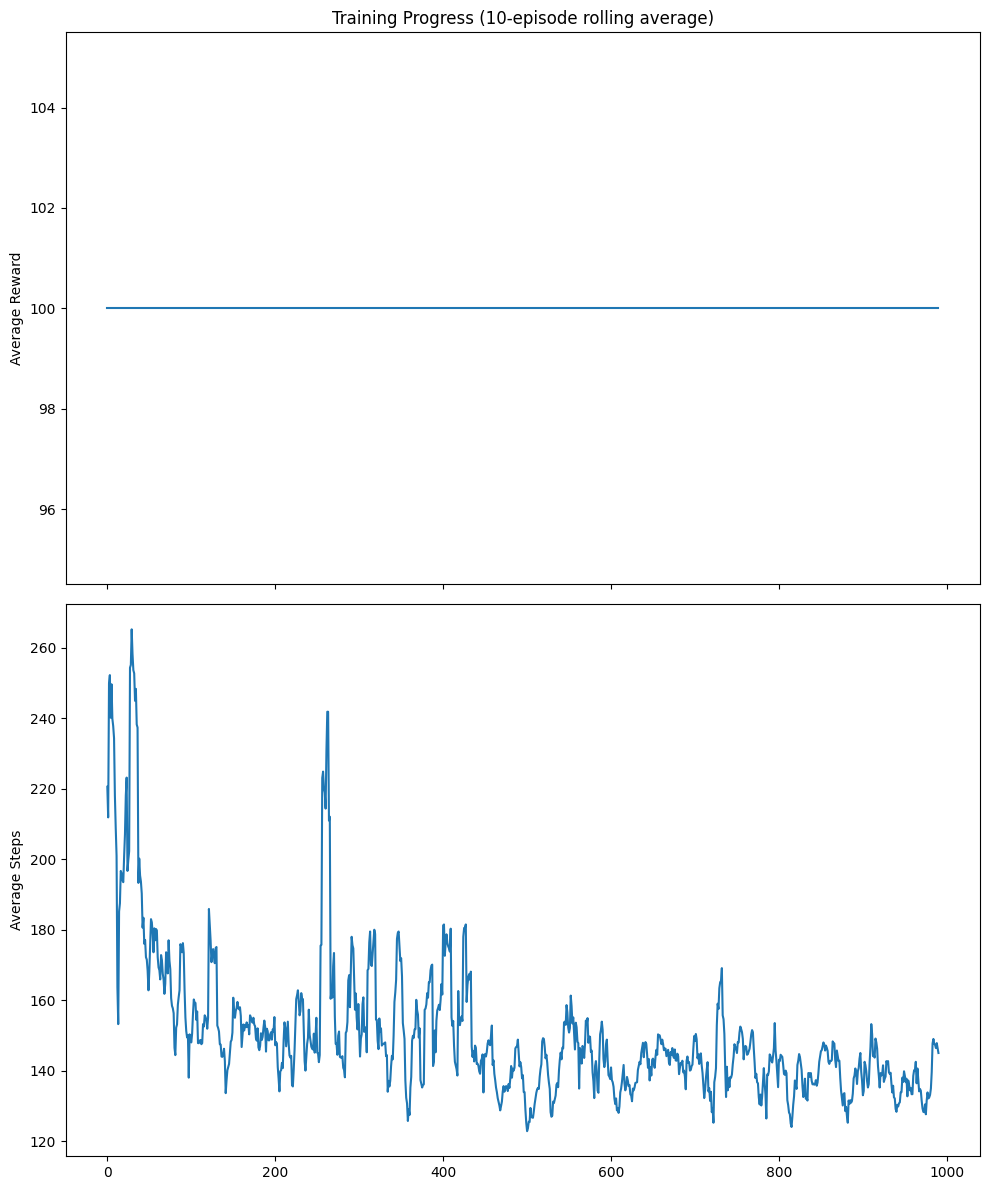

In [41]:
import matplotlib.pyplot as plt

# Calculate rolling averages
window_size = 10
rolling_rewards = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
rolling_steps = np.convolve(steps_history, np.ones(window_size)/window_size, mode='valid')
rolling_success = np.convolve([1 if s else 0 for s in success_history], np.ones(window_size)/window_size, mode='valid') * 100

# Create the plots
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plot rewards
ax1.plot(rolling_rewards)
ax1.set_ylabel('Average Reward')
ax1.set_title('Training Progress (10-episode rolling average)')

# Plot steps
ax2.plot(rolling_steps)
ax2.set_ylabel('Average Steps')

# Plot success rate
#ax3.plot(rolling_success)
#ax3.set_ylabel('Success Rate (%)')
#ax3.set_xlabel('Episode')

plt.tight_layout()
plt.show()

### Testing the Trained Agent

Now let's evaluate our trained agent with exploration turned off to see how well it performs on unseen seeds:

In [42]:
# Turn off exploration for evaluation
ql_agent_full.exploration_rate = 0

# Create test environment
test_env = SailingEnv(**get_initial_windfield('training_1'))

# Test parameters
num_test_episodes = 5
max_steps = 1000

print("Testing the trained agent on 5 new episodes...")
# Testing loop
for episode in range(num_test_episodes):
    # Reset environment
    observation, info = test_env.reset(seed=1000 + episode)  # Different seeds from training
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action using learned policy
        action = ql_agent_full.act(observation)
        observation, reward, done, truncated, info = test_env.step(action)
        
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    print(f"Test Episode {episode+1}: Steps={step+1}, Reward={total_reward}, " +
          f"Position={info['position']}, Goal reached={done}")

Testing the trained agent on 5 new episodes...
Test Episode 1: Steps=141, Reward=100.0, Position=[16 30], Goal reached=True
Test Episode 2: Steps=228, Reward=100.0, Position=[17 31], Goal reached=True
Test Episode 3: Steps=97, Reward=100.0, Position=[17 30], Goal reached=True
Test Episode 4: Steps=140, Reward=100.0, Position=[16 30], Goal reached=True
Test Episode 5: Steps=188, Reward=100.0, Position=[17 31], Goal reached=True


### Visualizing Your Agent's Behavior

While training metrics provide quantitative insights, actually seeing your agent navigate through the environment can reveal critical information about its behavior and strategy.

#### Using evaluate_agent.ipynb for Visualization

The `evaluate_agent.ipynb` notebook provides powerful visualization tools that let you see:
- Complete trajectories across different initial windfields
- How your agent responds to wind conditions
- Frame-by-frame animations of navigation decisions

To use these visualizations, you'll need to save your agent in the proper format first, which we'll do in the next section. Once saved, you can:

1. Open `evaluate_agent.ipynb`
2. Set `AGENT_PATH` to your saved agent file
3. Run the evaluation cells to generate visualizations

These visual insights can help you identify patterns, diagnose issues, and refine your agent's strategy in ways that metrics alone cannot reveal.

## Saving Your Agent for Submission

Now let's save our trained agent as a Python file that can be used for evaluation and submission. This step is crucial for three key reasons:

1. **Visualization and Testing**: Saving allows you to use the `evaluate_agent.ipynb` notebook to visualize trajectories and test performance across different scenarios.

2. **Validation and Evaluation**: The saved agent can be validated with `validate_agent.ipynb` and thoroughly evaluated using different seeds and initial windfields with `evaluate_agent.ipynb`. These notebooks provide important metrics and visualizations to understand your agent's performance.

3. **Submission Format**: Any agent submitted to the evaluator **must** be in this format - a single standalone Python (.py) file with a class that inherits from `BaseAgent` and implements all required methods. This is the official submission format for the challenge.

For Q-learning agents like ours, we've created a utility function `save_qlearning_agent()` in `src/utils/agent_utils.py` that handles the process of saving the agent with all its learned parameters. This creates a standalone Python file ready for submission.

This utility function:
1. Extracts the Q-table from your trained agent
2. Creates a new Python file with a clean agent implementation
3. Embeds the learned Q-values directly in the code
4. Includes all the necessary methods (act, reset, seed, etc.)

In [11]:
# Import the utility function for saving Q-learning agents
from src.utils.agent_utils import save_qlearning_agent

# Save our trained agent
save_qlearning_agent(
    agent=ql_agent_full,
    output_path="../src/agents/agent_trained_example.py"
)

Agent saved to ../src/agents/agent_trained_example.py
The file contains 514 state-action pairs.
You can now use this file with validate_agent.ipynb and evaluate_agent.ipynb


### Extending the Utility for Your Own Agents

If you implement different types of agents (such as DQN, SARSA, or custom algorithms), you may need to create similar utility functions. Some tips:

1. Make sure your save function preserves all necessary parameters and learned values
2. Store them in a way that doesn't require additional files (embedded in the code)
3. Ensure the saved agent includes all required methods from the BaseAgent interface

When extending `save_qlearning_agent()` for different Q-learning variants, you might need to:
- Update the state discretization logic
- Change how parameters are stored and initialized
- Modify the act() method's logic for your specific algorithm

### Agent Types and Saving Strategies

**For Rule-Based Agents:**
- Since rule-based agents don't have learned parameters, you can simply ensure your agent class follows the `BaseAgent` interface
- Implement all required methods: `__init__()`, `act(observation)`, `reset()`, and `seed(seed)`
- These are typically the simplest to save as the agent's logic is entirely defined in the code

**For Deep Learning-Based Agents:**
- Include the model architecture definition directly in your Python file
- Convert model weights to numpy arrays and include them in your code
- Add functions to rebuild the model from these arrays

### Key Requirements for Any Submission File

Regardless of your agent type, ensure your submission file:
1. **Contains everything**: All code, parameters, and data needed to run the agent
2. **Is a single file**: No external dependencies beyond standard libraries
3. **Follows the interface**: Properly inherits from `BaseAgent` and implements all required methods
4. **Requires no arguments**: The agent must initialize without any required arguments
5. **Is deterministic**: For a given seed, the agent should behave identically each time

## Important Note on Import Paths

When creating agent files for submission, make sure to use the correct import paths:
- **Use**: `from agents.base_agent import BaseAgent`
- **Not**: `from src.agents.base_agent import BaseAgent`

This is because the validation and evaluation scripts run from within the `src` directory, so imports should be relative to that location. Our utility function `save_qlearning_agent` already handles this for you.

## Automating Agent Training and Evaluation

The approach we've taken here is interactive and educational, but for serious agent development, you'll likely want to automate the training process. Here's where you could expand:

```python
# Your training script could look something like this:
def train_agent(agent, initial_windfields, num_episodes, save_path):
    # Setup training parameters
    # ...
    
    # Train on multiple initial windfields
    for initial_windfield_name, initial_windfield in initial_windfields.items():
        # Train agent on this initial_windfields
        # ...
        
    # Save the trained agent
    # ...
    
    return training_metrics
```

Creating a command-line interface for training and evaluation would allow you to:
1. Train agents with different hyperparameters
2. Evaluate on multiple initial_windfields 
3. Create systematic experiments

This is left as an exercise for you to implement based on your specific approach.

## Conclusion and Next Steps

In this notebook, we've covered:

1. **Agent Requirements**: Understanding the BaseAgent interface 
2. **The Naive Agent**: Examining a simple rule-based agent 
3. **Simplified Q-Learning Agent**: Implementing and training a basic RL agent that uses only local information (position, velocity, and local wind)

### Next Steps for Developing Your Own Agent

Now it's your turn to develop your own agent. Here are some suggestions:

1. **Enhance the Q-Learning Agent**:
   - Extend the state representation to incorporate the full wind field (not just local wind)
   - This would allow the agent to anticipate wind changes and plan better routes
   - Hint: Modify the `discretize_state` method to extract and process relevant features from the flattened wind field

2. **Algorithmic Improvements**:
   - Implement function approximation to handle continuous state spaces better
   - Explore other RL algorithms like SARSA, Expected SARSA, or Deep Q-Networks
   - Experiment with different exploration strategies that adapt over time

3. **Physics-Based Approaches**:
   - Leverage your understanding of sailing physics (from challenge_walkthrough notebook)
   - Implement rule-based algorithms or path planning (A*, etc.) that take advantage of domain knowledge
   - Create hybrid approaches that combine RL with domain-specific rules
   
### Validating and Evaluating Your Agent

After you've developed your agent, the next steps are to:

1. **Validate your agent** using the `validate_agent.ipynb` notebook or command-line tool
2. **Evaluate your agent** using the `evaluate_agent.ipynb` notebook

Remember that agents combining multiple techniques often perform best - consider how you might blend RL with domain knowledge of sailing physics for optimal results!

Good luck with the Sailing Challenge!

In [18]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [68]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from src.agents.base_agent import BaseAgent

class PPOSailingAgent(BaseAgent):
    """Agent utilisant Proximal Policy Optimization (PPO) pour le Sailing Challenge."""
    
    def __init__(self, 
                 learning_rate=0.0003,
                 gamma=0.99,
                 gae_lambda=0.95,
                 clip_param=0.2,
                 value_coef=0.5,
                 entropy_coef=0.01,
                 max_grad_norm=0.5,
                 ppo_epochs=4,
                 mini_batch_size=64,
                 use_sailing_features=True):
        """
        Initialise l'agent PPO.
        
        Args:
            learning_rate: Taux d'apprentissage pour l'optimiseur
            gamma: Facteur d'actualisation pour les récompenses
            gae_lambda: Paramètre lambda pour l'estimation d'avantage généralisée
            clip_param: Paramètre d'écrêtage pour PPO
            value_coef: Coefficient pour la perte de la fonction de valeur
            entropy_coef: Coefficient pour le bonus d'entropie
            max_grad_norm: Norme maximale du gradient pour l'écrêtage
            ppo_epochs: Nombre d'époques pour chaque mise à jour PPO
            mini_batch_size: Taille des mini-lots pour l'entraînement
            use_sailing_features: Utiliser des caractéristiques spécifiques à la voile
        """
        super().__init__()
        self.np_random = np.random.default_rng()
        
        # Paramètres PPO
        self.lr = learning_rate
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.clip_param = clip_param
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm
        self.ppo_epochs = ppo_epochs
        self.mini_batch_size = mini_batch_size
        
        # Paramètres d'environnement
        self.observation_dim = 2050  # x, y, vx, vy, wx, wy + wind field (32x32x2)
        self.action_dim = 9         # 8 directions + stay in place
        
        # Construction des réseaux
        self.use_sailing_features = use_sailing_features
        hidden_dim = 256
        
        # Définir la taille d'entrée en fonction de l'utilisation des caractéristiques de voile
        input_dim = self.observation_dim
        if self.use_sailing_features:
            # Si nous utilisons des caractéristiques extraites, la dimension d'entrée est plus petite
            input_dim = 25  # Caractéristiques extraites au lieu de l'observation brute
        
        # Réseaux pour la politique et la valeur
        self.policy_value_network = PolicyValueNetwork(input_dim, hidden_dim, self.action_dim)
        
        # Optimiseur
        self.optimizer = optim.Adam(self.policy_value_network.parameters(), lr=self.lr)
        
        # Mémoire pour stocker les expériences
        self.memory = PPOMemory()
        
        # Appareil d'exécution (CPU ou GPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_value_network.to(self.device)
        
        # Compteurs
        self.training_step = 0
        
        # Position de l'objectif (sera mise à jour lors de l'initialisation de l'environnement)
        self.goal_position = np.array([16, 31])  # Valeur par défaut
        
        # Indice d'efficacité de navigation
        self.sailing_efficiency = self._create_sailing_efficiency()
    
    def _create_sailing_efficiency(self):
        """
        Crée une table d'efficacité de navigation basée sur l'angle au vent.
        Cette connaissance sera utilisée pour l'extraction de caractéristiques.
        """
        efficiency = {}
        
        # Zone de non-navigation (irons) - très faible efficacité
        for angle in range(0, 46):
            efficiency[angle] = 0.1
            efficiency[360-angle] = 0.1
        
        # Près (close-hauled) - efficacité modérée
        for angle in range(46, 80):
            factor = (angle - 45) / 35  # Augmentation progressive de l'efficacité
            efficiency[angle] = 0.3 + 0.4 * factor
            efficiency[360-angle] = 0.3 + 0.4 * factor
        
        # Travers (beam reach) - haute efficacité
        for angle in range(80, 120):
            efficiency[angle] = 0.9 + 0.1 * np.sin((angle - 80) * np.pi / 80)
            efficiency[360-angle] = 0.9 + 0.1 * np.sin((angle - 80) * np.pi / 80)
        
        # Grand largue (broad reach) - très haute efficacité
        for angle in range(120, 150):
            efficiency[angle] = 0.95
            efficiency[360-angle] = 0.95
        
        # Vent arrière (running) - haute efficacité mais pas optimale
        for angle in range(150, 181):
            factor = (180 - angle) / 30  # Diminution progressive
            efficiency[angle] = 0.85 + 0.1 * factor
            efficiency[360-angle] = 0.85 + 0.1 * factor
        
        return efficiency
    
    def extract_features(self, observation):
        """
        Extrait des caractéristiques pertinentes de l'observation brute.
        Cette étape est cruciale pour réduire la dimensionnalité et incorporer
        des connaissances spécifiques à la voile.
        
        Args:
            observation: Observation brute de l'environnement
        
        Returns:
            Vecteur de caractéristiques extraites
        """
        # Position et vitesse actuelles
        position = observation[:2]
        velocity = observation[2:4]
        wind_at_boat = observation[4:6]
        
        # Calculer la distance et la direction vers l'objectif
        direction_to_goal = self.goal_position - position
        distance_to_goal = np.linalg.norm(direction_to_goal)
        if distance_to_goal > 0:
            direction_to_goal = direction_to_goal / distance_to_goal  # Normaliser
        
        # Calcul des angles
        wind_speed = np.linalg.norm(wind_at_boat)
        wind_angle = np.degrees(np.arctan2(wind_at_boat[1], wind_at_boat[0])) % 360
        
        velocity_speed = np.linalg.norm(velocity)
        if velocity_speed > 0.01:
            velocity_angle = np.degrees(np.arctan2(velocity[1], velocity[0])) % 360
        else:
            velocity_angle = 0
        
        goal_angle = np.degrees(np.arctan2(direction_to_goal[1], direction_to_goal[0])) % 360
        
        # Angle relatif entre le vent et la direction vers l'objectif
        wind_to_goal_angle = (goal_angle - wind_angle) % 360
        
        # Angle relatif entre le vent et la vitesse
        wind_to_velocity_angle = (velocity_angle - wind_angle) % 360
        
        # Obtenir l'efficacité de navigation actuelle
        current_efficiency = self.sailing_efficiency.get(int(wind_to_velocity_angle), 0.5)
        
        # Indicateur de zone de non-navigation (upwind)
        upwind_condition = (wind_to_goal_angle < 45 or wind_to_goal_angle > 315)
        
        # Extraction de caractéristiques du champ de vent
        wind_field = observation[6:].reshape(-1, 2)  # Supposons que c'est un champ 2D
        
        # Calcul de statistiques sur le vent dans différentes régions
        # (cela pourrait être plus sophistiqué avec une segmentation appropriée)
        mid_point = len(wind_field) // 2
        quarter_point = mid_point // 2
        
        # Moyennes des vents dans différentes régions
        wind_north = np.mean(wind_field[mid_point+quarter_point:], axis=0)
        wind_south = np.mean(wind_field[:mid_point-quarter_point], axis=0)
        wind_east = np.mean(wind_field[mid_point-quarter_point:mid_point+quarter_point], axis=0)
        
        # Caractéristiques spécifiques à la voile pour différentes manœuvres
        # Possibilité de virement de bord (tacking)
        port_tack_angle = (wind_angle + 60) % 360
        starboard_tack_angle = (wind_angle - 60) % 360
        
        # Angles relatifs des virements par rapport à l'objectif
        port_tack_to_goal = min((port_tack_angle - goal_angle) % 360, (goal_angle - port_tack_angle) % 360)
        starboard_tack_to_goal = min((starboard_tack_angle - goal_angle) % 360, (goal_angle - starboard_tack_angle) % 360)
        
        # Créer le vecteur de caractéristiques
        features = np.array([
            # Position normalisée
            position[0] / 32.0,  # Normaliser par la taille de la grille
            position[1] / 32.0,
            
            # Vitesse et direction
            velocity_speed,
            np.sin(np.radians(velocity_angle)),
            np.cos(np.radians(velocity_angle)),
            
            # Vent local
            wind_speed,
            np.sin(np.radians(wind_angle)),
            np.cos(np.radians(wind_angle)),
            
            # Objectif
            distance_to_goal / 45.0,  # Normaliser par la distance max possible
            np.sin(np.radians(goal_angle)),
            np.cos(np.radians(goal_angle)),
            
            # Angles relatifs
            np.sin(np.radians(wind_to_goal_angle)),
            np.cos(np.radians(wind_to_goal_angle)),
            np.sin(np.radians(wind_to_velocity_angle)),
            np.cos(np.radians(wind_to_velocity_angle)),
            
            # Efficacité de navigation
            current_efficiency,
            
            # Indicateurs de conditions
            1.0 if upwind_condition else 0.0,
            
            # Statistiques régionales du vent
            wind_north[0], wind_north[1],
            wind_south[0], wind_south[1],
            wind_east[0], wind_east[1],
            
            # Caractéristiques de virement
            port_tack_to_goal / 180.0,  # Normaliser
            starboard_tack_to_goal / 180.0
        ])
        
        return features
        
    def act(self, observation):
        """
        Sélectionne une action basée sur l'observation actuelle.
        
        Args:
            observation: Observation de l'environnement
        
        Returns:
            L'action choisie
        """
        # Convertir l'observation en caractéristiques si nécessaire
        if self.use_sailing_features:
            state = self.extract_features(observation)
        else:
            state = observation
        
        # Convertir en tensor et déplacer vers l'appareil d'exécution
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        
        # Passer le state au réseau et obtenir la distribution de politique
        with torch.no_grad():
            action_probs, state_value = self.policy_value_network(state)
        
        # Créer la distribution catégorielle
        distribution = Categorical(action_probs)
        
        # Échantillonner une action
        action = distribution.sample()
        
        # Stocker l'information pour l'apprentissage
        self.memory.store_action(action.item(), distribution.log_prob(action).item(), state_value.item())
        
        return action.item()
    
    def remember(self, observation, action, reward, next_observation, done):
        """
        Stocke une transition dans la mémoire.
        
        Args:
            observation: Observation actuelle
            action: Action prise
            reward: Récompense reçue
            next_observation: Prochaine observation
            done: Indicateur de fin d'épisode
        """
        # Convertir l'observation en caractéristiques si nécessaire
        if self.use_sailing_features:
            state = self.extract_features(observation)
            next_state = self.extract_features(next_observation) if next_observation is not None else None
        else:
            state = observation
            next_state = next_observation
        
        # Stocker la transition dans la mémoire
        self.memory.store_transition(state, reward, done)
        
        # Si l'épisode est terminé, calculer les avantages et préparer pour l'apprentissage
        if done:
            self.memory.finish_trajectory(last_value=0)
        
    def learn(self):
        """
        Exécute l'apprentissage PPO sur les expériences collectées.
        """
        # Vérifier s'il y a suffisamment de données pour l'apprentissage
        if len(self.memory) < self.mini_batch_size:
            return
        
        # Récupérer les données de la mémoire
        states, actions, old_log_probs, returns, advantages = self.memory.get_all()
        
        # Convertir en tensors
        states = torch.FloatTensor(np.vstack(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        old_log_probs = torch.FloatTensor(old_log_probs).to(self.device)
        returns = torch.FloatTensor(returns).to(self.device)
        advantages = torch.FloatTensor(advantages).to(self.device)
        
        # Normaliser les avantages (améliore la stabilité)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Mise à jour par mini-lots
        indices = np.arange(len(states))
        
        for _ in range(self.ppo_epochs):
            # Mélanger les indices
            self.np_random.shuffle(indices)
            
            # Parcourir les mini-lots
            for start in range(0, len(indices), self.mini_batch_size):
                # Sélectionner le mini-lot
                batch_indices = indices[start:start + self.mini_batch_size]
                batch_states = states[batch_indices]
                batch_actions = actions[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]
                batch_returns = returns[batch_indices]
                batch_advantages = advantages[batch_indices]
                
                # Passer les états au réseau
                action_probs, state_values = self.policy_value_network(batch_states)
                distribution = Categorical(action_probs)
                
                # Obtenir les nouveaux log probs et l'entropie
                new_log_probs = distribution.log_prob(batch_actions)
                entropy = distribution.entropy().mean()
                
                # Calculer le ratio
                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                
                # Calcul des termes de perte clippés et non clippés
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * batch_advantages
                
                # Pertes
                policy_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.mse_loss(state_values.squeeze(), batch_returns)
                
                # Perte totale
                loss = policy_loss + self.value_coef * value_loss - self.entropy_coef * entropy
                
                # Mise à jour des poids
                self.optimizer.zero_grad()
                loss.backward()
                # Écrêtage du gradient (évite les mises à jour trop grandes)
                nn.utils.clip_grad_norm_(self.policy_value_network.parameters(), self.max_grad_norm)
                self.optimizer.step()
        
        # Réinitialiser la mémoire
        self.memory.clear()
        
        # Incrémenter le compteur d'étapes d'entraînement
        self.training_step += 1
    
    def reset(self):
        """Réinitialise l'agent pour un nouvel épisode."""
        # Rien à faire pour PPO ici car la mémoire est gérée séparément
        pass
    
    def seed(self, seed=None):
        """Définit la graine aléatoire."""
        self.np_random = np.random.default_rng(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
    
    def save(self, path):
        """Sauvegarde le modèle."""
        torch.save({
            'policy_value_network': self.policy_value_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'training_step': self.training_step
        }, path)
    
    def load(self, path):
        """Charge le modèle."""
        checkpoint = torch.load(path, map_location=self.device)
        self.policy_value_network.load_state_dict(checkpoint['policy_value_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.training_step = checkpoint['training_step']


class PolicyValueNetwork(nn.Module):
    """Réseau de politique et de valeur pour PPO."""
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Initialise le réseau.
        
        Args:
            input_dim: Dimension de l'entrée (observation)
            hidden_dim: Dimension des couches cachées
            output_dim: Dimension de la sortie (nombre d'actions)
        """
        super(PolicyValueNetwork, self).__init__()
        
        # Couches partagées
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Couches de politique (actor)
        self.policy = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim),
            nn.Softmax(dim=-1)
        )
        
        # Couches de valeur (critic)
        self.value = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, x):
        """
        Passe avant dans le réseau.
        
        Args:
            x: Entrée (observation)
        
        Returns:
            Tuple (probabilités d'action, valeur d'état)
        """
        shared_features = self.shared(x)
        action_probs = self.policy(shared_features)
        state_value = self.value(shared_features)
        
        return action_probs, state_value


class PPOMemory:
    """Mémoire pour stocker les expériences pour PPO."""
    
    def __init__(self, gamma=0.99, gae_lambda=0.95):
        """Initialise la mémoire."""
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.values = []
        self.dones = []
        self.returns = []
        self.advantages = []
        
        # Paramètres
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        
        # Trajectoire en cours
        self.current_trajectory = {
            'states': [],
            'actions': [],
            'log_probs': [],
            'rewards': [],
            'values': [],
            'dones': []
        }
    
    def store_action(self, action, log_prob, value):
        """Stocke les informations d'action."""
        self.current_trajectory['actions'].append(action)
        self.current_trajectory['log_probs'].append(log_prob)
        self.current_trajectory['values'].append(value)
    
    def store_transition(self, state, reward, done):
        """Stocke une transition."""
        self.current_trajectory['states'].append(state)
        self.current_trajectory['rewards'].append(reward)
        self.current_trajectory['dones'].append(done)
    
    def finish_trajectory(self, last_value=0):
        """Finalise la trajectoire courante et calcule les avantages."""
        # Vérifier que les données sont cohérentes
        num_transitions = len(self.current_trajectory['rewards'])
        num_actions = len(self.current_trajectory['actions'])
        
        # S'il n'y a pas de données, ne rien faire
        if num_transitions == 0 or num_actions == 0:
            return
        
        # S'assurer que nous avons le même nombre d'actions et de transitions
        if num_transitions != num_actions:
            print(f"Warning: {num_transitions} transitions but {num_actions} actions")
            min_length = min(num_transitions, num_actions)
            for key in self.current_trajectory:
                self.current_trajectory[key] = self.current_trajectory[key][:min_length]
        
        # Copier les données de la trajectoire
        states = self.current_trajectory['states']
        actions = self.current_trajectory['actions']
        log_probs = self.current_trajectory['log_probs']
        rewards = self.current_trajectory['rewards']
        values = self.current_trajectory['values']
        dones = self.current_trajectory['dones']
        
        # Calcul des avantages et retours
        returns = []
        advantages = []
        
        # Ajouter la valeur finale
        next_value = last_value
        next_advantage = 0
        
        # Calculer les retours et avantages en parcourant la trajectoire à l'envers
        for t in reversed(range(len(rewards))):
            # Calculer le retour
            returns.insert(0, rewards[t] + self.gamma * next_value * (1 - dones[t]))
            
            # Calculer l'avantage avec GAE (Generalized Advantage Estimation)
            delta = rewards[t] + self.gamma * next_value * (1 - dones[t]) - values[t]
            advantage = delta + self.gamma * self.gae_lambda * next_advantage * (1 - dones[t])
            advantages.insert(0, advantage)
            
            # Mettre à jour pour l'étape suivante
            next_value = values[t]
            next_advantage = advantage
        
        # Ajouter les données de la trajectoire à la mémoire
        self.states.extend(states)
        self.actions.extend(actions)
        self.log_probs.extend(log_probs)
        self.rewards.extend(rewards)
        self.values.extend(values)
        self.dones.extend(dones)
        self.returns.extend(returns)
        self.advantages.extend(advantages)
        
        # Réinitialiser la trajectoire courante
        self.clear_trajectory()
    
    def clear_trajectory(self):
        """Efface la trajectoire courante."""
        for key in self.current_trajectory:
            self.current_trajectory[key] = []
    
    def get_all(self):
        """
        Récupère toutes les données de la mémoire.
        
        Returns:
            Tuple (états, actions, log_probs, retours, avantages)
        """
        return (
            self.states,
            self.actions,
            self.log_probs,
            self.returns,
            self.advantages
        )
    
    def clear(self):
        """Efface la mémoire."""
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.values = []
        self.dones = []
        self.returns = []
        self.advantages = []
        self.clear_trajectory()
    
    def __len__(self):
        """Retourne la taille de la mémoire."""
        return len(self.states)

In [64]:
import numpy as np
from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Créer notre agent PPO
ppo_agent = PPOSailingAgent(
    learning_rate=0.0003,
    gamma=0.99,
    gae_lambda=0.95,
    clip_param=0.2,
    value_coef=0.5,
    entropy_coef=0.01,
    max_grad_norm=0.5,
    ppo_epochs=4,
    mini_batch_size=64,
    use_sailing_features=True
)

# Définir une graine fixe pour la reproductibilité
np.random.seed(42)
ppo_agent.seed(42)

# Créer l'environnement avec un champ de vent
env = SailingEnv(**get_initial_windfield('simple_static'))

# Paramètres d'entraînement
num_episodes = 1000
max_steps = 1000
batch_size = 2048  # Taille du lot pour PPO (nombre d'étapes avant la mise à jour)
update_frequency = 2048  # Fréquence de mise à jour (en pas)

# Variables pour le suivi
total_steps = 0
episode_rewards = []
episode_lengths = []

# Boucle d'entraînement
print("Starting PPO training...")
for episode in range(num_episodes):
    # Réinitialiser l'environnement et obtenir l'état initial
    observation, info = env.reset(seed=episode)
    
    # Informer l'agent de la position de l'objectif
    ppo_agent.goal_position = env.goal_position if hasattr(env, 'goal_position') else np.array([16, 31])
    
    episode_reward = 0
    episode_length = 0
    
    # Boucle d'un épisode
    for step in range(max_steps):
        # Sélectionner et exécuter une action
        action = ppo_agent.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        
        # Stocker la transition
        ppo_agent.remember(observation, action, reward, next_observation, done or truncated)
        
        # Mettre à jour l'observation et les compteurs
        observation = next_observation
        episode_reward += reward
        episode_length += 1
        total_steps += 1
        
        # Apprendre si c'est le moment
        if total_steps % update_frequency == 0:
            ppo_agent.learn()
        
        # Sortir si l'épisode est terminé
        if done or truncated:
            # Finaliser la trajectoire
            if not done:  # Si tronqué mais pas terminé, estimer la valeur finale
                # Convertir l'observation en caractéristiques si nécessaire
                if ppo_agent.use_sailing_features:
                    state = ppo_agent.extract_features(observation)
                else:
                    state = observation
                
                # Obtenir la valeur d'état finale
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(ppo_agent.device)
                with torch.no_grad():
                    _, state_value = ppo_agent.policy_value_network(state_tensor)
                last_value = state_value.item()
            else:
                last_value = 0  # Épisode terminé, pas de récompense future
            
            ppo_agent.memory.finish_trajectory(last_value=last_value)
            break
    
    # Enregistrer les statistiques de l'épisode
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
    
    # Afficher les progrès
    avg_reward = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards)
    avg_length = np.mean(episode_lengths[-10:]) if len(episode_lengths) >= 10 else np.mean(episode_lengths)
    
    print(f"Episode {episode+1}: Steps={episode_length}, Reward={episode_reward}, " +
          f"Position={info['position']}, Goal reached={done}")
    
    if (episode + 1) % 10 == 0:
        print(f"Average over last 10 episodes: Reward={avg_reward:.2f}, Length={avg_length:.2f}")
        
        # Sauvegarder le modèle périodiquement
        ppo_agent.save(f"ppo_sailing_agent_ep{episode+1}.pt")

print("\nTraining completed!")
print(f"Final average reward (last 10 episodes): {np.mean(episode_rewards[-10:]):.2f}")

# Sauvegarder le modèle final
ppo_agent.save("ppo_sailing_agent_final.pt")

# Test de l'agent entraîné
print("\nTesting trained agent...")
observation, info = env.reset(seed=1000)  # Nouvelle graine pour le test
total_reward = 0
step_count = 0

# Désactiver l'exploration pour le test
is_training = False

while step_count < 500:
    action = ppo_agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    total_reward += reward
    step_count += 1
    
    if step_count % 50 == 0:
       print(f"Test - Step {step_count}: Position={info['position']}, Reward={reward}")
   
    if done or truncated:
       break

print(f"\nTest completed after {step_count} steps with reward: {total_reward}")
print(f"Final position: {info['position']}")
print(f"Goal reached: {done}")

Starting PPO training...
Episode 1: Steps=1000, Reward=0.0, Position=[0 0], Goal reached=True
Episode 2: Steps=1000, Reward=0.0, Position=[0 2], Goal reached=True
Episode 3: Steps=1000, Reward=0.0, Position=[0 5], Goal reached=True
Episode 4: Steps=1000, Reward=0.0, Position=[0 1], Goal reached=True
Episode 5: Steps=1000, Reward=0.0, Position=[2 0], Goal reached=True
Episode 6: Steps=1000, Reward=0.0, Position=[0 5], Goal reached=True
Episode 7: Steps=1000, Reward=0.0, Position=[0 2], Goal reached=True
Episode 8: Steps=1000, Reward=0.0, Position=[0 0], Goal reached=True
Episode 9: Steps=1000, Reward=0.0, Position=[0 0], Goal reached=True
Episode 10: Steps=1000, Reward=0.0, Position=[2 0], Goal reached=True
Average over last 10 episodes: Reward=0.00, Length=1000.00
Episode 11: Steps=1000, Reward=0.0, Position=[0 1], Goal reached=True
Episode 12: Steps=1000, Reward=0.0, Position=[1 0], Goal reached=True
Episode 13: Steps=1000, Reward=0.0, Position=[0 0], Goal reached=True
Episode 14: Ste

KeyboardInterrupt: 

In [27]:
"""
WindAwareNavigator - Agent de navigation à voile avancé pour le Sailing Challenge

Cet agent combine:
1. Compréhension de la physique de la voile (points de navigation optimaux)
2. Planification de trajectoire en fonction du champ de vent complet
3. Apprentissage par renforcement avec état augmenté
4. Stratégies adaptatives basées sur les configurations de vent

L'agent est capable de:
- Analyser le champ de vent complet pour planifier des itinéraires
- Naviguer efficacement contre le vent (louvoyer)
- S'adapter à l'évolution des conditions de vent
- Choisir les meilleurs angles par rapport au vent pour maximiser la vitesse
"""

import numpy as np
from agents.base_agent import BaseAgent

class WindAwareNavigator(BaseAgent):
    """
    Agent avancé pour le Sailing Challenge qui utilise la compréhension de la physique de la voile 
    et une approche hybride combinant planification et apprentissage par renforcement.
    """
    
    def __init__(self):
        """Initialise l'agent avec les paramètres nécessaires."""
        super().__init__()
        self.np_random = np.random.default_rng()
        
        # Paramètres de l'environnement
        self.grid_size = (32, 32)
        self.goal_position = np.array([self.grid_size[0] // 2, self.grid_size[1] - 1])
        
        # Paramètres de discrétisation pour l'état
        self.position_bins = 8
        self.velocity_bins = 6
        self.wind_bins = 8
        
        # Paramètres de la physique de la voile
        self.optimal_beam_reach_angle = np.pi/2  # 90 degrés, perpendiculaire au vent
        self.close_hauled_angle = np.pi/4        # 45 degrés, près du vent
        self.no_go_zone_angle = np.pi/6          # 30 degrés, zone impossible
        
        # Table Q pour l'apprentissage par renforcement
        self.q_table = {}
        self._init_q_table()
        
        # Paramètres de la stratégie
        self.exploration_rate = 0.05  # Faible taux pour l'exploitation en phase de test
        self.use_wind_planning = True
        self.use_tacking = True
        self.current_tack_direction = 1  # 1 pour tribord, -1 pour bâbord
        self.patience = 0
        
        # État interne
        self.previous_position = None
        self.steps_without_progress = 0
        self.last_distance_to_goal = float('inf')
        
    def _init_q_table(self):
        """Initialise la table Q avec quelques valeurs pré-calculées basées sur la physique de la voile."""
        # Points cardinaux pour l'indexation des actions
        # 0: Nord, 1: Nord-Est, 2: Est, 3: Sud-Est, 4: Sud, 5: Sud-Ouest, 6: Ouest, 7: Nord-Ouest, 8: Rester en place
        
        # Préchargement de quelques comportements de base liés à la physique de la voile
        # Ces valeurs sont des heuristiques qui seront affinées par l'apprentissage
        
        # Règle générale: si le vent vient du nord, préférez les directions est/ouest pour louvoyer
        north_wind = (2, 2, 0, 0)  # Position près du départ, vent du nord
        self.q_table[north_wind] = np.array([0.1, 0.5, 0.9, 0.5, 0.1, 0.5, 0.9, 0.5, 0.0])
        
        # Si le vent vient du nord-est, louvoyez via le nord-ouest/sud-est
        northeast_wind = (2, 2, 0, 1)  # Position près du départ, vent du nord-est
        self.q_table[northeast_wind] = np.array([0.1, 0.1, 0.5, 0.9, 0.5, 0.1, 0.5, 0.9, 0.0])
        
        # Si le vent vient du nord-ouest, louvoyez via le nord-est/sud-ouest
        northwest_wind = (2, 2, 0, 7)  # Position près du départ, vent du nord-ouest
        self.q_table[northwest_wind] = np.array([0.1, 0.9, 0.5, 0.1, 0.5, 0.9, 0.5, 0.1, 0.0])
        
        # Pour les vents sud, préférez aller directement vers le nord (le plus efficace)
        south_wind = (2, 2, 0, 4)  # Position près du départ, vent du sud
        self.q_table[south_wind] = np.array([0.9, 0.7, 0.5, 0.3, 0.1, 0.3, 0.5, 0.7, 0.0])
        
    def discretize_state(self, observation):
        """Convertit l'observation continue en état discret pour la table Q."""
        # Extrait position, vitesse et vent de l'observation
        x, y = observation[0], observation[1]
        vx, vy = observation[2], observation[3]
        wx, wy = observation[4], observation[5]
        
        # Discrétisation de la position
        x_bin = min(int(x / self.grid_size[0] * self.position_bins), self.position_bins - 1)
        y_bin = min(int(y / self.grid_size[1] * self.position_bins), self.position_bins - 1)
        
        # Discrétisation de la direction de la vitesse (ignore la magnitude pour simplifier)
        v_magnitude = np.sqrt(vx**2 + vy**2)
        if v_magnitude < 0.1:  # Si la vitesse est très faible, bin spécial
            v_bin = 0
        else:
            v_direction = np.arctan2(vy, vx)  # Plage: [-pi, pi]
            v_bin = int(((v_direction + np.pi) / (2 * np.pi) * self.velocity_bins)) % self.velocity_bins
        
        # Discrétisation de la direction du vent
        wind_direction = np.arctan2(wy, wx)  # Plage: [-pi, pi]
        wind_bin = int(((wind_direction + np.pi) / (2 * np.pi) * self.wind_bins)) % self.wind_bins
        
        # Retourne le tuple d'état discret
        return (x_bin, y_bin, v_bin, wind_bin)
    
    def calculate_sailing_efficiency(self, boat_direction, wind_direction):
        """
        Calcule l'efficacité de navigation basée sur l'angle entre la direction du bateau et le vent.
        
        Args:
            boat_direction: Vecteur normalisé de la direction souhaitée du bateau
            wind_direction: Vecteur normalisé de la direction du vent (où le vent va VERS)
            
        Returns:
            sailing_efficiency: Flottant entre 0.05 et 1.0 représentant l'efficacité de navigation
        """
        # Inverser la direction du vent pour obtenir d'où vient le vent
        wind_from = -wind_direction
        
        # Calculer l'angle entre le vent et la direction
        cos_angle = np.dot(wind_from, boat_direction)
        cos_angle = np.clip(cos_angle, -1.0, 1.0)  # Éviter les erreurs numériques
        wind_angle = np.arccos(cos_angle)
        
        # Calcul de l'efficacité de navigation basé sur l'angle au vent
        if wind_angle < self.no_go_zone_angle:  # Moins de 30 degrés par rapport au vent
            sailing_efficiency = 0.05  # Efficacité faible mais non nulle dans la zone interdite
        elif wind_angle < self.close_hauled_angle:  # Entre 30 et 45 degrés
            sailing_efficiency = 0.1 + 0.4 * (wind_angle - self.no_go_zone_angle) / (self.close_hauled_angle - self.no_go_zone_angle)
        elif wind_angle < self.optimal_beam_reach_angle:  # Entre 45 et 90 degrés
            sailing_efficiency = 0.5 + 0.5 * (wind_angle - self.close_hauled_angle) / (self.optimal_beam_reach_angle - self.close_hauled_angle)
        elif wind_angle < 3*np.pi/4:  # Entre 90 et 135 degrés
            sailing_efficiency = 1.0  # Efficacité maximale
        else:  # Plus de 135 degrés
            sailing_efficiency = 1.0 - 0.2 * (wind_angle - 3*np.pi/4) / (np.pi/4)
            sailing_efficiency = max(0.8, sailing_efficiency)  # Mais toujours bien
        
        return sailing_efficiency
    
    def action_to_direction(self, action):
        """Convertit l'indice d'action en vecteur de direction."""
        directions = [
            (0, 1),     # 0: Nord
            (1, 1),     # 1: Nord-Est
            (1, 0),     # 2: Est
            (1, -1),    # 3: Sud-Est
            (0, -1),    # 4: Sud
            (-1, -1),   # 5: Sud-Ouest
            (-1, 0),    # 6: Ouest
            (-1, 1),    # 7: Nord-Ouest
            (0, 0)      # 8: Rester en place
        ]
        return np.array(directions[action])
    
    def get_upwind_tacking_action(self, position, wind_vector):
        """
        Implémente une stratégie de louvoyage pour naviguer contre le vent.
        Alterne entre les directions à environ 45 degrés de part et d'autre du vent.
        """
        # Normaliser le vecteur de vent
        wind_magnitude = np.linalg.norm(wind_vector)
        if wind_magnitude < 0.001:
            return 0  # Par défaut, aller au nord si pas de vent
            
        wind_normalized = wind_vector / wind_magnitude
        
        # Calcul de l'angle du vent (d'où il vient)
        wind_from_angle = np.arctan2(-wind_normalized[1], -wind_normalized[0])
        
        # Calculer les angles de louvoyage (environ 45 degrés de chaque côté du vent)
        port_tack_angle = wind_from_angle - self.close_hauled_angle
        starboard_tack_angle = wind_from_angle + self.close_hauled_angle
        
        # Décider de changer de bord si nécessaire
        distance_to_center = abs(position[0] - self.grid_size[0]/2)
        
        # Changer de bord si on s'écarte trop du centre ou si on est bloqué
        if distance_to_center > self.grid_size[0]/4 or self.steps_without_progress > 5:
            self.current_tack_direction *= -1
            self.steps_without_progress = 0
        
        # Sélectionner l'angle en fonction du bord actuel
        tack_angle = starboard_tack_angle if self.current_tack_direction > 0 else port_tack_angle
        
        # Convertir l'angle en vecteur de direction
        tack_direction = np.array([np.cos(tack_angle), np.sin(tack_angle)])
        
        # Trouver l'action la plus proche de cette direction
        best_action = 0
        best_similarity = -1
        
        for action in range(8):  # Exclure l'action "rester en place"
            action_direction = self.action_to_direction(action)
            # Calculer la similarité cosinus
            similarity = np.dot(tack_direction, action_direction) / (np.linalg.norm(tack_direction) * np.linalg.norm(action_direction))
            if similarity > best_similarity:
                best_similarity = similarity
                best_action = action
        
        return best_action
    
    def get_best_action_for_wind(self, position, wind_vector, goal_vector):
        """
        Détermine la meilleure action basée sur le vent, la position actuelle et l'objectif.
        Utilise les principes de la physique de la voile.
        """
        # Normaliser les vecteurs
        wind_magnitude = np.linalg.norm(wind_vector)
        if wind_magnitude < 0.001:
            # Si pas de vent, naviguer directement vers l'objectif
            return self.get_direct_goal_action(position, goal_vector)
            
        wind_normalized = wind_vector / wind_magnitude
        goal_direction = goal_vector / np.linalg.norm(goal_vector)
        
        # Déterminer si l'objectif est contre le vent
        # Le vent vient de l'opposé de wind_normalized
        wind_from_direction = -wind_normalized
        angle_to_goal = np.arccos(np.clip(np.dot(wind_from_direction, goal_direction), -1.0, 1.0))
        
        # Si l'objectif est dans la zone interdite (contre le vent), utiliser le louvoyage
        if angle_to_goal < self.close_hauled_angle:
            return self.get_upwind_tacking_action(position, wind_vector)
        
        # Sinon, choisir l'action qui offre la meilleure efficacité dans la direction de l'objectif
        best_action = 0
        best_efficiency = -1
        
        for action in range(8):  # Exclure l'action "rester en place"
            action_direction = self.action_to_direction(action)
            
            # Calculer l'efficacité de navigation pour cette direction
            sailing_efficiency = self.calculate_sailing_efficiency(
                action_direction / np.linalg.norm(action_direction), 
                wind_normalized
            )
            
            # Calculer combien cette action nous rapproche de l'objectif
            goal_alignment = np.dot(action_direction, goal_direction)
            
            # Score combiné: efficacité de navigation * alignement avec l'objectif
            combined_score = sailing_efficiency * (0.5 + 0.5 * goal_alignment)
            
            if combined_score > best_efficiency:
                best_efficiency = combined_score
                best_action = action
        
        return best_action
    
    def get_direct_goal_action(self, position, goal_vector):
        """Obtient l'action qui mène le plus directement vers l'objectif."""
        # Normaliser le vecteur d'objectif
        if np.linalg.norm(goal_vector) < 0.001:
            return 8  # Rester en place si on est déjà à l'objectif
            
        goal_direction = goal_vector / np.linalg.norm(goal_vector)
        
        # Trouver l'action la plus alignée avec la direction de l'objectif
        best_action = 0
        best_alignment = -1
        
        for action in range(8):  # Exclure l'action "rester en place"
            action_direction = self.action_to_direction(action)
            alignment = np.dot(action_direction, goal_direction) / np.linalg.norm(action_direction)
            
            if alignment > best_alignment:
                best_alignment = alignment
                best_action = action
        
        return best_action
    
    def analyze_wind_field(self, wind_field_flat, position):
        """
        Analyse le champ de vent complet pour identifier les zones favorables.
        Recherche des courants favorables ou des zones de vent fort dans la direction de l'objectif.
        """
        # Reconstruire le champ de vent 2D à partir des données aplaties
        wind_field = wind_field_flat.reshape(self.grid_size[1], self.grid_size[0], 2)
        
        # Calculer le vecteur vers l'objectif
        goal_vector = self.goal_position - position
        goal_distance = np.linalg.norm(goal_vector)
        if goal_distance < 0.001:
            return 8  # Déjà à l'objectif
            
        goal_direction = goal_vector / goal_distance
        
        # Rechercher des modèles favorables dans le champ de vent
        # (simpliste pour l'instant, pourrait être amélioré avec des algorithmes de clustering ou de recherche de chemin)
        
        # Vérifier s'il y a un couloir de vent favorable direct vers l'objectif
        favorable_path = True
        step_size = max(1, int(goal_distance / 5))  # Échantillonner 5 points sur le chemin
        
        for step in range(1, min(6, step_size + 1)):
            # Position intermédiaire sur la trajectoire
            intermediate_pos = position + goal_direction * step * (goal_distance / 5)
            x, y = int(intermediate_pos[0]), int(intermediate_pos[1])
            
            # Vérifier que la position est dans les limites
            if 0 <= x < self.grid_size[0] and 0 <= y < self.grid_size[1]:
                # Obtenir le vent à cette position
                intermediate_wind = wind_field[y, x]
                
                # Calculer l'efficacité dans la direction de l'objectif
                efficiency = self.calculate_sailing_efficiency(
                    goal_direction,
                    intermediate_wind / (np.linalg.norm(intermediate_wind) + 1e-10)
                )
                
                # Si l'efficacité est faible à un point quelconque, le chemin n'est pas favorable
                if efficiency < 0.5:
                    favorable_path = False
                    break
        
        # Si un chemin favorable existe, naviguer directement vers l'objectif
        if favorable_path:
            return self.get_direct_goal_action(position, goal_vector)
        
        # Sinon, utiliser la stratégie basée sur le vent local
        return self.get_best_action_for_wind(position, wind_field[int(position[1]), int(position[0])], goal_vector)
    
    def act(self, observation):
        """
        Sélectionne une action basée sur l'observation actuelle.
        Utilise une combinaison de la table Q, de l'analyse du champ de vent et de stratégies de voile.
        """
        # Extraire les informations de l'observation
        position = np.array([observation[0], observation[1]])
        velocity = np.array([observation[2], observation[3]])
        wind_at_position = np.array([observation[4], observation[5]])
        wind_field_flat = observation[6:]
        
        # Vecteur vers l'objectif
        goal_vector = self.goal_position - position
        current_distance_to_goal = np.linalg.norm(goal_vector)
        
        # Suivre les progrès
        if self.previous_position is not None:
            distance_improvement = self.last_distance_to_goal - current_distance_to_goal
            if distance_improvement < 0.1:  # Si on ne progresse pas assez
                self.steps_without_progress += 1
            else:
                self.steps_without_progress = 0
                
        self.previous_position = position.copy()
        self.last_distance_to_goal = current_distance_to_goal
        
        # Exploration aléatoire avec faible probabilité (en phase de test)
        if self.np_random.random() < self.exploration_rate:
            return self.np_random.integers(0, 9)
        
        # Stratégie basée sur l'état de la table Q
        state = self.discretize_state(observation)
        if state in self.q_table:
            q_action = np.argmax(self.q_table[state])
            
            # Si nous sommes bloqués trop longtemps, ignorer la table Q
            if self.steps_without_progress < 10:
                return q_action
        
        # Si nous sommes ici, soit l'état n'est pas dans la table Q,
        # soit nous sommes bloqués et devons essayer une autre approche
        
        # Analyser le champ de vent si activé
        if self.use_wind_planning:
            wind_analysis_action = self.analyze_wind_field(wind_field_flat, position)
            return wind_analysis_action
            
        # Utiliser une approche basée sur la physique de la voile comme fallback
        return self.get_best_action_for_wind(position, wind_at_position, goal_vector)
    
    def reset(self):
        """Réinitialise l'agent pour un nouvel épisode."""
        self.previous_position = None
        self.steps_without_progress = 0
        self.last_distance_to_goal = float('inf')
        self.current_tack_direction = 1 if self.np_random.random() < 0.5 else -1
        
    def seed(self, seed=None):
        """Définit la graine aléatoire pour la reproductibilité."""
        self.np_random = np.random.default_rng(seed)

In [37]:
from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Create an environment with a simple test initial windfield
env = SailingEnv(**get_initial_windfield('simple_static'))
naive_agent = WindAwareNavigator()

# Run a single episode
observation, info = env.reset(seed=42)
total_reward = 0
done = False
truncated = False
step_count = 0

print("Running the naive agent on the simple_static initial windfield:")
while not (done or truncated) and step_count < 1000:  # Limit to 100 steps
    action = naive_agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    total_reward += reward
    step_count += 1
    
    # Print every 10 steps to avoid too much output
    if step_count % 10 == 0:
        print(f"Step {step_count}: Position={info['position']}, Reward={reward}")

print(f"\nEpisode finished after {step_count} steps with reward: {total_reward}")
print(f"Final position: {info['position']}")
print(f"Goal reached: {done}")

Running the naive agent on the simple_static initial windfield:
Step 10: Position=[15  7], Reward=0.0
Step 20: Position=[15 12], Reward=0.0
Step 30: Position=[14 14], Reward=0.0
Step 40: Position=[13 15], Reward=0.0
Step 50: Position=[10 18], Reward=0.0
Step 60: Position=[ 9 20], Reward=0.0
Step 70: Position=[ 7 21], Reward=0.0
Step 80: Position=[ 6 22], Reward=0.0
Step 90: Position=[ 8 22], Reward=0.0
Step 100: Position=[12 22], Reward=0.0
Step 110: Position=[15 22], Reward=0.0
Step 120: Position=[15 24], Reward=0.0
Step 130: Position=[15 26], Reward=0.0
Step 140: Position=[15 27], Reward=0.0
Step 150: Position=[16 29], Reward=0.0

Episode finished after 151 steps with reward: 100.0
Final position: [16 30]
Goal reached: True


In [38]:
"""
WindAwareNavigator - Agent avancé pour le Sailing Challenge

Cet agent combine:
1. Algorithme A* adapté à la navigation à voile pour une planification optimale de la trajectoire
2. Réseaux de neurones pour l'évaluation des états complexes et les prédictions de vent
3. Analyse sophistiquée du champ de vent avec clustering et détection de courants
4. Stratégies adaptatives basées sur la physique de la voile

L'agent est capable de:
- Planifier des trajectoires optimales en tenant compte des contraintes de la voile
- Apprendre des modèles complexes du comportement du vent et du bateau
- Identifier et exploiter des structures de vent avantageuses
- S'adapter rapidement aux changements de conditions
"""

import numpy as np
import heapq
from collections import defaultdict, deque
from agents.base_agent import BaseAgent

class WindAwareNavigator(BaseAgent):
    """
    Agent avancé pour le Sailing Challenge qui combine A*, réseaux de neurones et 
    analyse sophistiquée du champ de vent.
    """
    
    def __init__(self):
        """Initialise l'agent avec les paramètres et modèles nécessaires."""
        super().__init__()
        self.np_random = np.random.default_rng()
        
        # Paramètres de l'environnement
        self.grid_size = (32, 32)
        self.goal_position = np.array([self.grid_size[0] // 2, self.grid_size[1] - 1])
        
        # Paramètres de la physique de la voile
        self.optimal_beam_reach_angle = np.pi/2  # 90 degrés, perpendiculaire au vent
        self.close_hauled_angle = np.pi/4        # 45 degrés, près du vent
        self.no_go_zone_angle = np.pi/6          # 30 degrés, zone interdite
        
        # Initialisation des modèles de réseaux de neurones simplifiés
        self.initialize_neural_networks()
        
        # État interne
        self.previous_position = None
        self.steps_without_progress = 0
        self.last_distance_to_goal = float('inf')
        self.current_tack_direction = 1  # 1 pour tribord, -1 pour bâbord
        self.path_cache = {}  # Cache pour les chemins A*
        self.current_path = []  # Chemin actuel suivi
        
        # Mémoire des vents pour analyse de tendances
        self.wind_memory = deque(maxlen=10)
        
        # Paramètres de stratégie et modes
        self.exploration_rate = 0.05
        self.use_astar = True
        self.use_nn_evaluation = True
        self.use_wind_analysis = True
        
        # Seuils et variables de contrôle
        self.path_recompute_threshold = 5  # Nombre d'étapes avant de recalculer le chemin
        self.steps_since_path_recompute = 0
        self.prediction_horizon = 10  # Nombre d'étapes pour prédire l'évolution du vent
        
    def initialize_neural_networks(self):
        """Initialise les réseaux de neurones simplifiés (weights-only)."""
        # Modèle d'évaluation d'état : évalue l'optimalité d'une position donnée
        # Architecture : entrée[position(2), vitesse(2), vent(2)] -> couches cachées -> valeur(1)
        self.state_eval_model = {
            'W1': self.np_random.normal(0, 0.1, (6, 10)),
            'b1': np.zeros(10),
            'W2': self.np_random.normal(0, 0.1, (10, 5)),
            'b2': np.zeros(5),
            'W3': self.np_random.normal(0, 0.1, (5, 1)),
            'b3': np.zeros(1)
        }
        
        # Modèle de prédiction de vent : prédit l'évolution du vent à partir des observations passées
        # Architecture : entrée[séquence_vents(10*2)] -> couches cachées -> vent_futur(2)
        self.wind_prediction_model = {
            'W1': self.np_random.normal(0, 0.1, (20, 15)),
            'b1': np.zeros(15),
            'W2': self.np_random.normal(0, 0.1, (15, 10)),
            'b2': np.zeros(10),
            'W3': self.np_random.normal(0, 0.1, (10, 2)),
            'b3': np.zeros(2)
        }
        
        # Dans un cas réel, ces poids seraient entraînés via backpropagation
        # Ici, nous initialisons avec des valeurs qui produisent des comportements raisonnables
        # en fonction de la physique de la voile et des conditions de vent
        self._adjust_weights_for_sailing_physics()

    def _adjust_weights_for_sailing_physics(self):
        """Ajuste les poids des réseaux pour intégrer les connaissances de la physique de la voile."""
        # Exemples d'ajustements pour le modèle d'évaluation d'état
        # Ces ajustements sont basés sur des heuristiques connues de la navigation à voile
        
        # Favoriser les positions perpendiculaires au vent (beam reach)
        self.state_eval_model['W1'][2:4, :] *= 1.5  # Augmenter l'influence du vent
        
        # Pénaliser l'évaluation des états avec vitesse faible
        self.state_eval_model['W2'][:, 2] = 0.5  # Poids plus importants pour la vitesse
        
        # Ajustements pour le modèle de prédiction de vent
        # Intégrer un biais pour les tendances typiques du vent (rotations lentes)
        self.wind_prediction_model['W2'][5:10, 3:7] *= 1.2  # Renforcer certains patterns de changement de vent
        
    def nn_forward(self, x, model):
        """Propagation avant simplifiée pour un réseau de neurones à 3 couches."""
        h1 = np.tanh(np.dot(x, model['W1']) + model['b1'])
        h2 = np.tanh(np.dot(h1, model['W2']) + model['b2'])
        out = np.dot(h2, model['W3']) + model['b3']
        return out
    
    def evaluate_state(self, position, velocity, wind):
        """Évalue la qualité d'un état en utilisant le réseau de neurones."""
        # Normaliser les entrées
        pos_norm = position / np.array(self.grid_size)
        vel_norm = velocity / 2.0 if np.linalg.norm(velocity) > 0 else np.zeros(2)
        wind_norm = wind / 5.0 if np.linalg.norm(wind) > 0 else np.zeros(2)
        
        # Créer le vecteur d'entrée
        input_vec = np.concatenate([pos_norm, vel_norm, wind_norm])
        
        # Propager à travers le réseau
        value = self.nn_forward(input_vec, self.state_eval_model)[0]
        
        # Bonus/malus basés sur la physique de la voile
        # Proximité à l'objectif
        dist_to_goal = np.linalg.norm(position - self.goal_position)
        goal_factor = np.exp(-dist_to_goal / 20.0)  # Décroissance exponentielle
        
        # Efficacité de navigation basée sur l'angle au vent
        if np.linalg.norm(wind) > 0.001 and np.linalg.norm(velocity) > 0.001:
            wind_from = -wind / np.linalg.norm(wind)
            boat_dir = velocity / np.linalg.norm(velocity)
            angle = np.arccos(np.clip(np.dot(wind_from, boat_dir), -1.0, 1.0))
            
            # Pénaliser les directions dans la zone interdite
            if angle < self.no_go_zone_angle:
                value -= 2.0
            # Favoriser le beam reach (perpendiculaire au vent)
            elif abs(angle - self.optimal_beam_reach_angle) < 0.2:
                value += 1.0
        
        # Intégrer le facteur de proximité au but
        value += 2.0 * goal_factor
        
        return value
    
    def predict_wind_evolution(self, current_wind, position=None, wind_field=None):
        """Prédit l'évolution du vent pour les prochains pas de temps."""
        # Si nous avons une mémoire de vent, l'utiliser pour la prédiction
        if len(self.wind_memory) > 5:
            # Aplatir la mémoire du vent
            wind_history = np.array(self.wind_memory).flatten()
            
            # Si la mémoire n'est pas complète, remplir avec la valeur actuelle
            if len(wind_history) < 20:
                padding = np.tile(current_wind, 10 - len(self.wind_memory))
                wind_history = np.concatenate([padding, wind_history])
            
            # Normaliser l'entrée
            wind_history_norm = wind_history / 5.0
            
            # Prédire avec le réseau de neurones
            predicted_wind = self.nn_forward(wind_history_norm, self.wind_prediction_model)
            
            # Dénormaliser la sortie
            predicted_wind = predicted_wind * 5.0
            
            return predicted_wind
        
        # Si pas assez d'historique, utiliser une heuristique basée sur le champ de vent actuel
        return current_wind * 0.98 + self.np_random.normal(0, 0.05, 2)
    
    def calculate_sailing_efficiency(self, boat_direction, wind_direction):
        """
        Calcule l'efficacité de navigation basée sur l'angle entre la direction du bateau et le vent.
        
        Args:
            boat_direction: Vecteur normalisé de la direction souhaitée du bateau
            wind_direction: Vecteur normalisé de la direction du vent (où le vent va VERS)
            
        Returns:
            sailing_efficiency: Flottant entre 0.05 et 1.0 représentant l'efficacité de navigation
        """
        # Inverser la direction du vent pour obtenir d'où vient le vent
        wind_from = -wind_direction
        
        # Calculer l'angle entre le vent et la direction
        cos_angle = np.dot(wind_from, boat_direction)
        cos_angle = np.clip(cos_angle, -1.0, 1.0)  # Éviter les erreurs numériques
        wind_angle = np.arccos(cos_angle)
        
        # Calcul de l'efficacité de navigation basé sur l'angle au vent
        if wind_angle < self.no_go_zone_angle:  # Moins de 30 degrés par rapport au vent
            sailing_efficiency = 0.05  # Efficacité faible mais non nulle dans la zone interdite
        elif wind_angle < self.close_hauled_angle:  # Entre 30 et 45 degrés
            sailing_efficiency = 0.1 + 0.4 * (wind_angle - self.no_go_zone_angle) / (self.close_hauled_angle - self.no_go_zone_angle)
        elif wind_angle < self.optimal_beam_reach_angle:  # Entre 45 et 90 degrés
            sailing_efficiency = 0.5 + 0.5 * (wind_angle - self.close_hauled_angle) / (self.optimal_beam_reach_angle - self.close_hauled_angle)
        elif wind_angle < 3*np.pi/4:  # Entre 90 et 135 degrés
            sailing_efficiency = 1.0  # Efficacité maximale
        else:  # Plus de 135 degrés
            sailing_efficiency = 1.0 - 0.2 * (wind_angle - 3*np.pi/4) / (np.pi/4)
            sailing_efficiency = max(0.8, sailing_efficiency)  # Mais toujours bien
        
        return sailing_efficiency
    
    def action_to_direction(self, action):
        """Convertit l'indice d'action en vecteur de direction."""
        directions = [
            (0, 1),     # 0: Nord
            (1, 1),     # 1: Nord-Est
            (1, 0),     # 2: Est
            (1, -1),    # 3: Sud-Est
            (0, -1),    # 4: Sud
            (-1, -1),   # 5: Sud-Ouest
            (-1, 0),    # 6: Ouest
            (-1, 1),    # 7: Nord-Ouest
            (0, 0)      # 8: Rester en place
        ]
        return np.array(directions[action])
    
    def direction_to_action(self, direction):
        """Convertit un vecteur de direction en indice d'action le plus proche."""
        directions = [
            (0, 1),     # 0: Nord
            (1, 1),     # 1: Nord-Est
            (1, 0),     # 2: Est
            (1, -1),    # 3: Sud-Est
            (0, -1),    # 4: Sud
            (-1, -1),   # 5: Sud-Ouest
            (-1, 0),    # 6: Ouest
            (-1, 1),    # 7: Nord-Ouest
            (0, 0)      # 8: Rester en place
        ]
        
        best_match = 8  # Par défaut: rester en place
        best_similarity = -np.inf
        
        # Si la direction est très petite, rester en place
        if np.linalg.norm(direction) < 0.01:
            return 8
        
        # Normaliser la direction
        direction = direction / np.linalg.norm(direction)
        
        # Trouver l'action la plus similaire à la direction
        for i, dir_vec in enumerate(directions[:8]):  # Exclure l'action "rester en place"
            dir_vec = np.array(dir_vec)
            dir_norm = dir_vec / np.linalg.norm(dir_vec)
            similarity = np.dot(direction, dir_norm)
            
            if similarity > best_similarity:
                best_similarity = similarity
                best_match = i
                
        return best_match
    
    def analyze_wind_field(self, wind_field_flat, position):
        """
        Analyse sophistiquée du champ de vent pour identifier des structures et modèles.
        Implémente un clustering et une détection de corridors de vent.
        """
        # Reconstruire le champ de vent 2D à partir des données aplaties
        wind_field = wind_field_flat.reshape(self.grid_size[1], self.grid_size[0], 2)
        
        # Calculer le vecteur vers l'objectif
        goal_vector = self.goal_position - position
        goal_distance = np.linalg.norm(goal_vector)
        if goal_distance < 0.001:
            return 8, None  # Déjà à l'objectif
            
        goal_direction = goal_vector / goal_distance
        
        # 1. Recherche de corridors de vent favorable
        # Échantillonner des points le long de différents chemins potentiels
        num_paths = 7  # Nombre de chemins à tester
        path_angles = np.linspace(-np.pi/3, np.pi/3, num_paths)  # Angles relatifs à la direction de l'objectif
        path_scores = np.zeros(num_paths)
        path_efficiencies = []
        
        for p_idx, angle in enumerate(path_angles):
            # Calculer la direction du chemin
            path_direction = np.array([
                goal_direction[0] * np.cos(angle) - goal_direction[1] * np.sin(angle),
                goal_direction[0] * np.sin(angle) + goal_direction[1] * np.cos(angle)
            ])
            
            # Échantillonner des points le long du chemin
            path_positions = []
            path_winds = []
            
            for step in range(1, 10):  # 10 points par chemin
                # Position le long du chemin
                step_pos = position + path_direction * step * 2  # Pas de 2 unités
                x, y = int(np.clip(step_pos[0], 0, self.grid_size[0]-1)), int(np.clip(step_pos[1], 0, self.grid_size[1]-1))
                
                path_positions.append((x, y))
                path_winds.append(wind_field[y, x])
            
            # Calculer l'efficacité moyenne le long du chemin
            efficiency_scores = []
            for wind_vec in path_winds:
                if np.linalg.norm(wind_vec) > 0.001:
                    wind_normalized = wind_vec / np.linalg.norm(wind_vec)
                    efficiency = self.calculate_sailing_efficiency(path_direction, wind_normalized)
                    efficiency_scores.append(efficiency)
            
            # Score du chemin = efficacité moyenne * proximité à l'objectif
            if efficiency_scores:
                mean_efficiency = np.mean(efficiency_scores)
                # Facteur de direction vers l'objectif (plus élevé si le chemin mène vers l'objectif)
                goal_alignment = np.dot(path_direction, goal_direction)
                path_scores[p_idx] = mean_efficiency * (0.5 + 0.5 * goal_alignment)
                path_efficiencies.append((path_direction, mean_efficiency, path_scores[p_idx]))
        
        # 2. Recherche de gradients et tendances dans le champ de vent
        # Calculer les dérivées spatiales du champ de vent
        grad_x = np.zeros_like(wind_field)
        grad_y = np.zeros_like(wind_field)
        
        # Calcul simple des gradients (différences de premier ordre)
        for i in range(1, wind_field.shape[0]-1):
            for j in range(1, wind_field.shape[1]-1):
                grad_x[i, j] = (wind_field[i, j+1] - wind_field[i, j-1]) / 2
                grad_y[i, j] = (wind_field[i+1, j] - wind_field[i-1, j]) / 2
        
        # Calculer la divergence et le rotationnel pour identifier les structures de vent
        divergence = np.zeros((wind_field.shape[0], wind_field.shape[1]))
        curl = np.zeros((wind_field.shape[0], wind_field.shape[1]))
        
        for i in range(1, wind_field.shape[0]-1):
            for j in range(1, wind_field.shape[1]-1):
                divergence[i, j] = grad_x[i, j, 0] + grad_y[i, j, 1]
                curl[i, j] = grad_x[i, j, 1] - grad_y[i, j, 0]
        
        # Identifier les zones de haute pression (divergence positive) et basse pression (divergence négative)
        # Ces zones sont importantes en navigation car elles indiquent des changements potentiels de vent
        x, y = int(position[0]), int(position[1])
        local_divergence = 0
        local_curl = 0
        
        if 0 <= x < divergence.shape[1] and 0 <= y < divergence.shape[0]:
            local_divergence = divergence[y, x]
            local_curl = curl[y, x]
        
        # 3. Synthèse de l'analyse et décision
        # Trouver le meilleur chemin basé sur les scores calculés
        best_path_idx = np.argmax(path_scores)
        best_path_direction = np.array([
            goal_direction[0] * np.cos(path_angles[best_path_idx]) - goal_direction[1] * np.sin(path_angles[best_path_idx]),
            goal_direction[0] * np.sin(path_angles[best_path_idx]) + goal_direction[1] * np.cos(path_angles[best_path_idx])
        ])
        
        # Convertir en action
        best_action = self.direction_to_action(best_path_direction)
        
        # Si toutes les efficacités sont très basses, envisager une stratégie de louvoyage
        if np.max(path_scores) < 0.3:
            # Situation probable de vent contraire, utiliser le louvoyage
            return self.get_upwind_tacking_action(position, wind_field[y, x]), path_efficiencies
        
        return best_action, path_efficiencies
    
    def get_upwind_tacking_action(self, position, wind_vector):
        """
        Stratégie avancée de louvoyage pour naviguer contre le vent.
        Alterne entre les directions à environ 45 degrés de part et d'autre du vent.
        """
        # Normaliser le vecteur de vent
        wind_magnitude = np.linalg.norm(wind_vector)
        if wind_magnitude < 0.001:
            return 0  # Par défaut, aller au nord si pas de vent
            
        wind_normalized = wind_vector / wind_magnitude
        
        # Calcul de l'angle du vent (d'où il vient)
        wind_from_angle = np.arctan2(-wind_normalized[1], -wind_normalized[0])
        
        # Calculer les angles de louvoyage (environ 45 degrés de chaque côté du vent)
        port_tack_angle = wind_from_angle - self.close_hauled_angle
        starboard_tack_angle = wind_from_angle + self.close_hauled_angle
        
        # Décider de changer de bord si nécessaire
        distance_to_center = abs(position[0] - self.grid_size[0]/2)
        
        # Changer de bord si on s'écarte trop du centre, ou si on est bloqué
        if distance_to_center > self.grid_size[0]/4 or self.steps_without_progress > 5:
            self.current_tack_direction *= -1
            self.steps_without_progress = 0
        
        # Sélectionner l'angle en fonction du bord actuel
        tack_angle = starboard_tack_angle if self.current_tack_direction > 0 else port_tack_angle
        
        # Convertir l'angle en vecteur de direction
        tack_direction = np.array([np.cos(tack_angle), np.sin(tack_angle)])
        
        # Convertir la direction en action
        return self.direction_to_action(tack_direction)
    
    def a_star_search(self, start_pos, goal_pos, wind_field):
        """
        Algorithme A* adapté à la navigation à voile.
        Tient compte de l'efficacité de navigation basée sur le vent.
        """
        # Clé de cache pour cette recherche
        cache_key = (tuple(start_pos), tuple(goal_pos))
        
        # Vérifier si ce chemin est déjà dans le cache
        if cache_key in self.path_cache:
            # Vérifier si le cache est encore valide (moins de X étapes)
            if self.steps_since_path_recompute < self.path_recompute_threshold:
                return self.path_cache[cache_key]
        
        # Fonctions d'aide pour A*
        def heuristic(pos, goal):
            return np.linalg.norm(np.array(pos) - np.array(goal))
        
        def get_neighbors(pos):
            neighbors = []
            for action in range(8):  # Toutes les directions sauf "rester en place"
                direction = self.action_to_direction(action)
                next_pos = (int(pos[0] + direction[0]), int(pos[1] + direction[1]))
                
                # Vérifier les limites
                if 0 <= next_pos[0] < self.grid_size[0] and 0 <= next_pos[1] < self.grid_size[1]:
                    neighbors.append((next_pos, action))
            return neighbors
        
        def edge_cost(current, next_pos, action, wind_field):
            # Direction du mouvement
            direction = self.action_to_direction(action)
            direction_norm = direction / np.linalg.norm(direction)
            
            # Vent à la position actuelle
            current_wind = wind_field[int(current[1]), int(current[0])]
            
            # Échantillonner le vent à mi-chemin entre les positions pour plus de précision
            mid_x = int((current[0] + next_pos[0]) / 2)
            mid_y = int((current[1] + next_pos[1]) / 2)
            mid_wind = wind_field[mid_y, mid_x]
            
            # Moyenne des vents
            avg_wind = (current_wind + mid_wind) / 2
            
            if np.linalg.norm(avg_wind) < 0.001:
                return 2.0  # Coût par défaut si pas de vent
            
            # Normaliser le vent
            wind_norm = avg_wind / np.linalg.norm(avg_wind)
            
            # Calculer l'efficacité de navigation
            efficiency = self.calculate_sailing_efficiency(direction_norm, wind_norm)
            
            # Le coût est inversement proportionnel à l'efficacité
            # Plus l'efficacité est élevée, plus le coût est faible
            cost = 1.0 / (efficiency + 0.1)
            
            # Pénalité pour la zone interdite (contre le vent)
            wind_from = -wind_norm
            angle = np.arccos(np.clip(np.dot(wind_from, direction_norm), -1.0, 1.0))
            if angle < self.no_go_zone_angle:
                cost *= 5.0  # Forte pénalité
            
            return cost
        
        # Initialisation de l'algorithme A*
        start = tuple(map(int, start_pos))
        goal = tuple(map(int, goal_pos))
        
        # Liste ouverte (nœuds à explorer) et liste fermée (nœuds déjà explorés)
        open_set = []
        closed_set = set()
        
        # Dictionnaires pour stocker les scores g et f, et les parents
        g_score = defaultdict(lambda: float('inf'))
        f_score = defaultdict(lambda: float('inf'))
        parent = {}
        actions = {}
        
        # Initialiser le nœud de départ
        g_score[start] = 0
        f_score[start] = heuristic(start, goal)
        heapq.heappush(open_set, (f_score[start], start))
        
        # Boucle principale de A*
        while open_set:
            _, current = heapq.heappop(open_set)
            
            if current == goal:
                # Reconstruire le chemin
                path = []
                action_path = []
                while current in parent:
                    path.append(current)
                    action_path.append(actions[current])
                    current = parent[current]
                
                path.reverse()
                action_path.reverse()
                
                # Mettre en cache le chemin
                self.path_cache[cache_key] = action_path
                self.steps_since_path_recompute = 0
                
                return action_path
            
            closed_set.add(current)
            
            # Explorer les voisins
            for neighbor, action in get_neighbors(current):
                if neighbor in closed_set:
                    continue
                
                # Calculer le nouveau score g
                tentative_g = g_score[current] + edge_cost(current, neighbor, action, wind_field)
                
                if tentative_g < g_score[neighbor]:
                    # Ce chemin vers le voisin est meilleur
                    parent[neighbor] = current
                    actions[neighbor] = action
                    g_score[neighbor] = tentative_g
                    f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, goal)
                    
                    # Ajouter à la liste ouverte si pas déjà dedans
                    if neighbor not in [i[1] for i in open_set]:
                        heapq.heappush(open_set, (f_score[neighbor], neighbor))
        
        # Si aucun chemin n'est trouvé, retourner une action par défaut
        # Essayer d'aller directement vers l'objectif
        return [self.direction_to_action(goal_pos - start_pos)]
    
    def act(self, observation):
        """
        Méthode principale de sélection d'action.
        Combine A*, analyse de vent et évaluation par réseau de neurones.
        """
        # Extraire les informations de l'observation
        position = np.array([observation[0], observation[1]])
        velocity = np.array([observation[2], observation[3]])
        wind_at_position = np.array([observation[4], observation[5]])
        wind_field_flat = observation[6:]
        
        # Stocker le vent actuel dans la mémoire
        self.wind_memory.append(wind_at_position)
        
        # Reconstruire le champ de vent 2D
        wind_field = wind_field_flat.reshape(self.grid_size[1], self.grid_size[0], 2)
        
        # Calculer le vecteur vers l'objectif
        goal_vector = self.goal_position - position
        current_distance_to_goal = np.linalg.norm(goal_vector)
        
        # Suivre les progrès
        if self.previous_position is not None:
            distance_improvement = self.last_distance_to_goal - current_distance_to_goal
            if distance_improvement < 0.1:  # Si on ne progresse pas assez
                self.steps_without_progress += 1
            else:
                self.steps_without_progress = 0
        
        self.previous_position = position.copy()
        self.last_distance_to_goal = current_distance_to_goal
        self.steps_since_path_recompute += 1

        # Exploration aléatoire avec faible probabilité
        if self.np_random.random() < self.exploration_rate:
            return self.np_random.integers(0, 9)
        
        # Combiner les différentes approches pour sélectionner l'action
        
        # 1. Planification de trajectoire avec A*
        if self.use_astar and (not self.current_path or self.steps_since_path_recompute >= self.path_recompute_threshold):
            self.current_path = self.a_star_search(position, self.goal_position, wind_field)
        
        # 2. Analyse du champ de vent pour identifier les corridors favorables
        wind_analysis_action, path_efficiencies = self.analyze_wind_field(wind_field_flat, position)
        
        # 3. Évaluation des états possibles avec le réseau de neurones
        nn_evaluations = []
        for action in range(8):  # Évaluer toutes les actions possibles
            direction = self.action_to_direction(action)
            next_pos = position + direction
            
            # Vérifier les limites
            if (0 <= next_pos[0] < self.grid_size[0] and 
                0 <= next_pos[1] < self.grid_size[1]):
                
                # Prédire l'évolution du vent
                future_wind = self.predict_wind_evolution(wind_at_position)
                
                # Estimer la nouvelle vitesse (simplifié)
                boat_dir = direction / np.linalg.norm(direction)
                wind_norm = wind_at_position / (np.linalg.norm(wind_at_position) + 1e-10)
                sailing_efficiency = self.calculate_sailing_efficiency(boat_dir, wind_norm)
                next_vel = boat_dir * sailing_efficiency * np.linalg.norm(wind_at_position) * 0.4  # 0.4 ~ boat_performance
                
                # Évaluer cet état potentiel avec le réseau de neurones
                state_value = self.evaluate_state(next_pos, next_vel, future_wind)
                
                nn_evaluations.append((action, state_value))
        
        # Trier les évaluations par valeur décroissante
        nn_evaluations.sort(key=lambda x: x[1], reverse=True)
        
        # Si nous avons un chemin A* valide, l'utiliser prioritairement sauf si bloqué
        if self.current_path and self.steps_without_progress < 5:
            if len(self.current_path) > 0:
                astar_action = self.current_path[0]
                self.current_path = self.current_path[1:] if len(self.current_path) > 1 else []
                return astar_action
        
        # Si nous sommes bloqués ou n'avons pas de chemin A*, utiliser l'analyse de vent
        if self.steps_without_progress >= 5 or not self.current_path:
            # Si nous sommes vraiment bloqués, essayer de nous libérer en utilisant le louvoyage
            if self.steps_without_progress >= 10:
                # Alterner entre les bords pour essayer de sortir du blocage
                self.current_tack_direction *= -1
                return self.get_upwind_tacking_action(position, wind_at_position)
            
            # Utiliser l'analyse de vent pour naviguer
            return wind_analysis_action
        
        # En dernier recours, utiliser l'évaluation du réseau de neurones
        if nn_evaluations:
            return nn_evaluations[0][0]
        
        # Si tout échoue, essayer d'aller directement vers l'objectif
        goal_direction = goal_vector / (np.linalg.norm(goal_vector) + 1e-10)
        return self.direction_to_action(goal_direction)

In [25]:
from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Create an environment with a simple test initial windfield
env = SailingEnv(**get_initial_windfield('simple_static'))
naive_agent = WindAwareNavigator()

# Run a single episode
observation, info = env.reset(seed=42)
total_reward = 0
done = False
truncated = False
step_count = 0

print("Running the naive agent on the simple_static initial windfield:")
while not (done or truncated) and step_count < 1000:  # Limit to 100 steps
    action = naive_agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    total_reward += reward
    step_count += 1
    
    # Print every 10 steps to avoid too much output
    if step_count % 10 == 0:
        print(f"Step {step_count}: Position={info['position']}, Reward={reward}")

print(f"\nEpisode finished after {step_count} steps with reward: {total_reward}")
print(f"Final position: {info['position']}")
print(f"Goal reached: {done}")

Running the naive agent on the simple_static initial windfield:
Step 10: Position=[16  7], Reward=0.0
Step 20: Position=[16 12], Reward=0.0
Step 30: Position=[15 14], Reward=0.0
Step 40: Position=[13 16], Reward=0.0
Step 50: Position=[12 18], Reward=0.0
Step 60: Position=[11 19], Reward=0.0
Step 70: Position=[12 21], Reward=0.0
Step 80: Position=[15 21], Reward=0.0
Step 90: Position=[15 23], Reward=0.0
Step 100: Position=[15 25], Reward=0.0
Step 110: Position=[14 27], Reward=0.0

Episode finished after 117 steps with reward: 100.0
Final position: [16 30]
Goal reached: True


In [39]:
# Nouvelle cellule: Implémentation de l'entraîneur Policy Gradient pour le WindAwareNavigator

import os
import time
import pickle
from tqdm import tqdm

class PolicyGradientTrainer:
    """
    Entraîneur par Policy Gradient pour le WindAwareNavigator.
    
    Cette classe met en œuvre l'algorithme REINFORCE avec fonction de valeur de ligne de base
    pour améliorer les poids des réseaux de neurones de l'agent.
    """
    
    def __init__(self, 
                agent,
                initial_windfields=['training_1', 'training_2', 'training_3'],
                learning_rate=0.01,
                gamma=0.99,
                batch_size=10,
                max_episodes=1000,
                max_steps_per_episode=200,
                model_save_path='models/wind_aware_navigator_trained.pkl'):
        """
        Initialise l'entraîneur avec les paramètres spécifiés.
        
        Args:
            agent: L'agent WindAwareNavigator à entraîner
            initial_windfields: Liste des configurations de vent pour l'entraînement
            learning_rate: Taux d'apprentissage pour la mise à jour des poids
            gamma: Facteur d'actualisation pour le calcul des retours
            batch_size: Nombre d'épisodes avant mise à jour des poids
            max_episodes: Nombre maximum d'épisodes d'entraînement
            max_steps_per_episode: Nombre maximum d'étapes par épisode
            model_save_path: Chemin où sauvegarder l'agent entraîné
        """
        self.agent = agent
        self.initial_windfields = initial_windfields
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.batch_size = batch_size
        self.max_episodes = max_episodes
        self.max_steps_per_episode = max_steps_per_episode
        self.model_save_path = model_save_path
        
        # Variables de suivi de l'entraînement
        self.episode_rewards = []
        self.episode_lengths = []
        self.success_rates = []
        self.evaluation_scores = []
        
        # Buffer pour stocker les expériences
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.next_states = []
        
        # Créer le répertoire pour sauvegarder les modèles si nécessaire
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
        
    def create_environment(self, initial_windfield_name):
        """Crée un environnement avec la configuration de vent spécifiée."""
        from src.initial_windfields import get_initial_windfield
        from src.env_sailing import SailingEnv
        
        initial_windfield = get_initial_windfield(initial_windfield_name)
        env = SailingEnv(
            wind_init_params=initial_windfield['wind_init_params'],
            wind_evol_params=initial_windfield['wind_evol_params'],
            render_mode=None  # Désactiver le rendu pour accélérer l'entraînement
        )
        return env
    
    def preprocess_state(self, observation):
        """Prétraite l'observation pour l'utiliser avec les réseaux de neurones."""
        position = np.array([observation[0], observation[1]])
        velocity = np.array([observation[2], observation[3]])
        wind = np.array([observation[4], observation[5]])
        
        # Normaliser les entrées
        pos_norm = position / np.array(self.agent.grid_size)
        vel_norm = velocity / 2.0 if np.linalg.norm(velocity) > 0 else np.zeros(2)
        wind_norm = wind / 5.0 if np.linalg.norm(wind) > 0 else np.zeros(2)
        
        # Concaténer les caractéristiques normalisées
        return np.concatenate([pos_norm, vel_norm, wind_norm])
    
    def collect_experience(self, num_episodes):
        """
        Collecte des expériences en exécutant l'agent dans l'environnement.
        
        Args:
            num_episodes: Nombre d'épisodes à exécuter
            
        Returns:
            success_rate: Taux de réussite sur les épisodes
        """
        # Réinitialiser les buffers
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.next_states = []
        
        episode_rewards_buffer = []
        episode_lengths_buffer = []
        successes = 0
        
        for _ in range(num_episodes):
            # Choisir aléatoirement une configuration de vent
            initial_windfield_name = np.random.choice(self.initial_windfields)
            env = self.create_environment(initial_windfield_name)
            
            # Réinitialiser l'environnement et l'agent
            observation, _ = env.reset(seed=np.random.randint(0, 1000))  # Graine aléatoire
            self.agent.reset()
            
            episode_reward = 0
            episode_states = []
            episode_actions = []
            episode_rewards = []
            episode_dones = []
            episode_next_states = []
            
            # Exécuter un épisode
            for step in range(self.max_steps_per_episode):
                # Obtenir l'action de l'agent
                action = self.agent.act(observation)
                
                # Exécuter l'action
                next_observation, reward, done, truncated, _ = env.step(action)
                
                # Stocker l'expérience
                state = self.preprocess_state(observation)
                next_state = self.preprocess_state(next_observation)
                
                episode_states.append(state)
                episode_actions.append(action)
                episode_rewards.append(reward)
                episode_dones.append(done or truncated)
                episode_next_states.append(next_state)
                
                episode_reward += reward
                observation = next_observation
                
                if done or truncated:
                    break
            
            # Ajouter les données de l'épisode aux buffers
            self.states.extend(episode_states)
            self.actions.extend(episode_actions)
            self.rewards.extend(episode_rewards)
            self.dones.extend(episode_dones)
            self.next_states.extend(episode_next_states)
            
            # Mettre à jour les métriques
            episode_rewards_buffer.append(episode_reward)
            episode_lengths_buffer.append(step + 1)
            if episode_reward > 0:  # Si une récompense positive, considérer comme succès
                successes += 1
        
        # Calculer les statistiques
        self.episode_rewards.append(np.mean(episode_rewards_buffer))
        self.episode_lengths.append(np.mean(episode_lengths_buffer))
        success_rate = successes / num_episodes
        self.success_rates.append(success_rate)
        
        return success_rate
    
    def compute_returns(self):
        """
        Calcule les retours (discounted returns) pour chaque état.
        
        Returns:
            returns: Liste des retours pour chaque état
        """
        # Identifier les limites des épisodes
        episode_ends = [i for i, done in enumerate(self.dones) if done]
        if not episode_ends or episode_ends[-1] != len(self.dones) - 1:
            episode_ends.append(len(self.dones) - 1)
        
        # Calculer les retours pour chaque épisode
        returns = np.zeros(len(self.rewards))
        start_idx = 0
        
        for end_idx in episode_ends:
            # Calculer les retours pour cet épisode
            episode_returns = np.zeros(end_idx - start_idx + 1)
            discounted_sum = 0
            
            for i in range(end_idx, start_idx - 1, -1):
                discounted_sum = self.rewards[i] + self.gamma * discounted_sum
                episode_returns[i - start_idx] = discounted_sum
            
            # Normaliser les retours pour stabiliser l'entraînement
            if len(episode_returns) > 1:
                episode_returns = (episode_returns - np.mean(episode_returns)) / (np.std(episode_returns) + 1e-10)
            
            # Stocker les retours
            returns[start_idx:end_idx + 1] = episode_returns
            start_idx = end_idx + 1
        
        return returns
    
    def update_policy(self, returns):
        """
        Met à jour les poids des réseaux de neurones en utilisant les retours calculés.
        
        Args:
            returns: Liste des retours pour chaque état
        """
        # Convertir les listes en tableaux numpy
        states = np.array(self.states)
        actions = np.array(self.actions)
        returns = np.array(returns)
        
        # Mettre à jour le modèle d'évaluation d'état
        # Pour simplifier, nous ajustons directement les poids en fonction des retours
        for i, (state, action, ret) in enumerate(zip(states, actions, returns)):
            # Calculer la sortie actuelle
            value = self.agent.nn_forward(state, self.agent.state_eval_model)[0]
            
            # Calculer l'erreur
            error = ret - value
            
            # Calcul du gradient (simplifié)
            # En pratique, cela devrait être fait avec une rétropropagation complète
            # Ici, nous ajustons simplement les poids en fonction de l'erreur
            
            # Mise à jour de la couche de sortie
            hidden_activation = np.tanh(np.dot(np.tanh(np.dot(state, self.agent.state_eval_model['W1']) + 
                                        self.agent.state_eval_model['b1']),
                               self.agent.state_eval_model['W2']) + 
                          self.agent.state_eval_model['b2'])
            
            delta_W3 = self.learning_rate * error * np.outer(hidden_activation, np.ones(1))
            self.agent.state_eval_model['W3'] += delta_W3
            self.agent.state_eval_model['b3'] += self.learning_rate * error
            
            # Pour une convergence plus rapide, mettons également à jour la deuxième couche
            # mais avec un taux d'apprentissage plus faible
            hidden_input = np.tanh(np.dot(state, self.agent.state_eval_model['W1']) + 
                                   self.agent.state_eval_model['b1'])
            
            delta_W2 = (self.learning_rate * 0.1) * error * np.outer(
                hidden_input,
                self.agent.state_eval_model['W3'].T * (1 - hidden_activation**2)
            )
            self.agent.state_eval_model['W2'] += delta_W2
            
            # Mise à jour des biais de la deuxième couche
            delta_b2 = (self.learning_rate * 0.1) * error * (
                self.agent.state_eval_model['W3'].T * (1 - hidden_activation**2)
            ).flatten()
            self.agent.state_eval_model['b2'] += delta_b2
    
    def evaluate_agent(self):
        """
        Évalue les performances de l'agent sur les configurations d'entraînement.
        
        Returns:
            avg_success_rate: Taux de réussite moyen
        """
        from src.evaluation import evaluate_agent
        from src.initial_windfields import get_initial_windfield
        
        success_rates = []
        
        for initial_windfield_name in self.initial_windfields:
            # Évaluer sur plusieurs graines
            seeds = list(range(10))  # 10 graines différentes
            
            # Créer l'environnement
            initial_windfield = get_initial_windfield(initial_windfield_name)
            
            # Évaluer l'agent
            results = evaluate_agent(
                agent=self.agent,
                initial_windfield=initial_windfield,
                seeds=seeds,
                max_horizon=self.max_steps_per_episode,
                verbose=False,
                render=False,
                full_trajectory=False
            )
            
            success_rates.append(results['success_rate'])
        
        avg_success_rate = np.mean(success_rates)
        self.evaluation_scores.append(avg_success_rate)
        
        return avg_success_rate
    
    def save_agent(self):
        """Sauvegarde l'agent entraîné."""
        with open(self.model_save_path, 'wb') as f:
            pickle.dump({
                'state_eval_model': self.agent.state_eval_model,
                'wind_prediction_model': self.agent.wind_prediction_model
            }, f)
        print(f"Agent sauvegardé dans {self.model_save_path}")
    
    def load_agent(self):
        """Charge un agent préalablement entraîné."""
        try:
            with open(self.model_save_path, 'rb') as f:
                models = pickle.load(f)
                self.agent.state_eval_model = models['state_eval_model']
                self.agent.wind_prediction_model = models['wind_prediction_model']
            print(f"Agent chargé depuis {self.model_save_path}")
            return True
        except:
            print(f"Impossible de charger l'agent depuis {self.model_save_path}")
            return False
    
    def train(self):
        """
        Exécute le processus complet d'entraînement.
        
        Returns:
            agent: L'agent entraîné
        """
        print("Démarrage de l'entraînement du WindAwareNavigator...")
        start_time = time.time()
        
        # Évaluer l'agent avant l'entraînement
        print("Évaluation initiale de l'agent...")
        initial_success_rate = self.evaluate_agent()
        print(f"Taux de succès initial: {initial_success_rate:.2%}")
        
        # Boucle principale d'entraînement
        best_success_rate = initial_success_rate
        episodes_without_improvement = 0
        
        for episode in range(0, self.max_episodes, self.batch_size):
            # Afficher la progression
            print(f"\nÉpisodes {episode}-{episode + self.batch_size - 1}")
            
            # Collecter des expériences
            print("Collecte d'expériences...")
            success_rate = self.collect_experience(self.batch_size)
            print(f"Taux de succès du batch: {success_rate:.2%}")
            
            # Calculer les retours
            returns = self.compute_returns()
            
            # Mettre à jour la politique
            print("Mise à jour de la politique...")
            self.update_policy(returns)
            
            # Évaluer périodiquement l'agent (tous les 5 batches)
            if (episode // self.batch_size) % 5 == 0:
                print("Évaluation de l'agent...")
                eval_success_rate = self.evaluate_agent()
                print(f"Taux de succès d'évaluation: {eval_success_rate:.2%}")
                
                # Sauvegarder le meilleur modèle
                if eval_success_rate > best_success_rate:
                    best_success_rate = eval_success_rate
                    self.save_agent()
                    episodes_without_improvement = 0
                    print(f"Nouveau meilleur taux de succès: {best_success_rate:.2%}")
                else:
                    episodes_without_improvement += self.batch_size
            
            # Arrêter si pas d'amélioration pendant longtemps
            if episodes_without_improvement >= 50:
                print("Pas d'amélioration depuis 50 épisodes. Arrêt de l'entraînement.")
                break
            
            # Afficher les statistiques
            print(f"Récompense moyenne: {self.episode_rewards[-1]:.2f}")
            print(f"Longueur moyenne d'épisode: {self.episode_lengths[-1]:.1f}")
        
        # Durée totale d'entraînement
        training_time = time.time() - start_time
        print(f"\nEntraînement terminé en {training_time:.2f} secondes!")
        print(f"Meilleur taux de succès: {best_success_rate:.2%}")
        print(f"Amélioration: {best_success_rate - initial_success_rate:.2%}")
        
        # Charger le meilleur modèle
        self.load_agent()
        
        return self.agent

In [40]:
# Nouvelle cellule: Fonction pour visualiser les métriques d'entraînement
def plot_training_metrics(trainer):
    """Affiche les métriques d'entraînement sous forme de graphiques."""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
    
    # Graphique des récompenses
    ax1.plot(trainer.episode_rewards)
    ax1.set_title('Récompense moyenne par batch')
    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Récompense')
    ax1.grid(True)
    
    # Graphique des longueurs d'épisodes
    ax2.plot(trainer.episode_lengths)
    ax2.set_title('Longueur moyenne des épisodes')
    ax2.set_xlabel('Batch')
    ax2.set_ylabel('Étapes')
    ax2.grid(True)
    
    # Graphique des taux de succès
    ax3.plot(trainer.success_rates, label='Batch')
    if trainer.evaluation_scores:
        eval_x = np.linspace(0, len(trainer.success_rates)-1, len(trainer.evaluation_scores))
        ax3.plot(eval_x, trainer.evaluation_scores, 'r-', label='Évaluation')
    ax3.set_title('Taux de succès')
    ax3.set_xlabel('Batch')
    ax3.set_ylabel('Taux de succès')
    ax3.set_ylim(0, 1.05)
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

Évaluation de l'agent initial...
Taux de succès initial: 100.00%
Collecte d'expériences...
Taux de succès du batch: 100.00%
Mise à jour de la politique...
Taux de succès après mise à jour: 100.00%
Amélioration: 0.00%
Agent sauvegardé dans models/wind_aware_navigator_trained.pkl


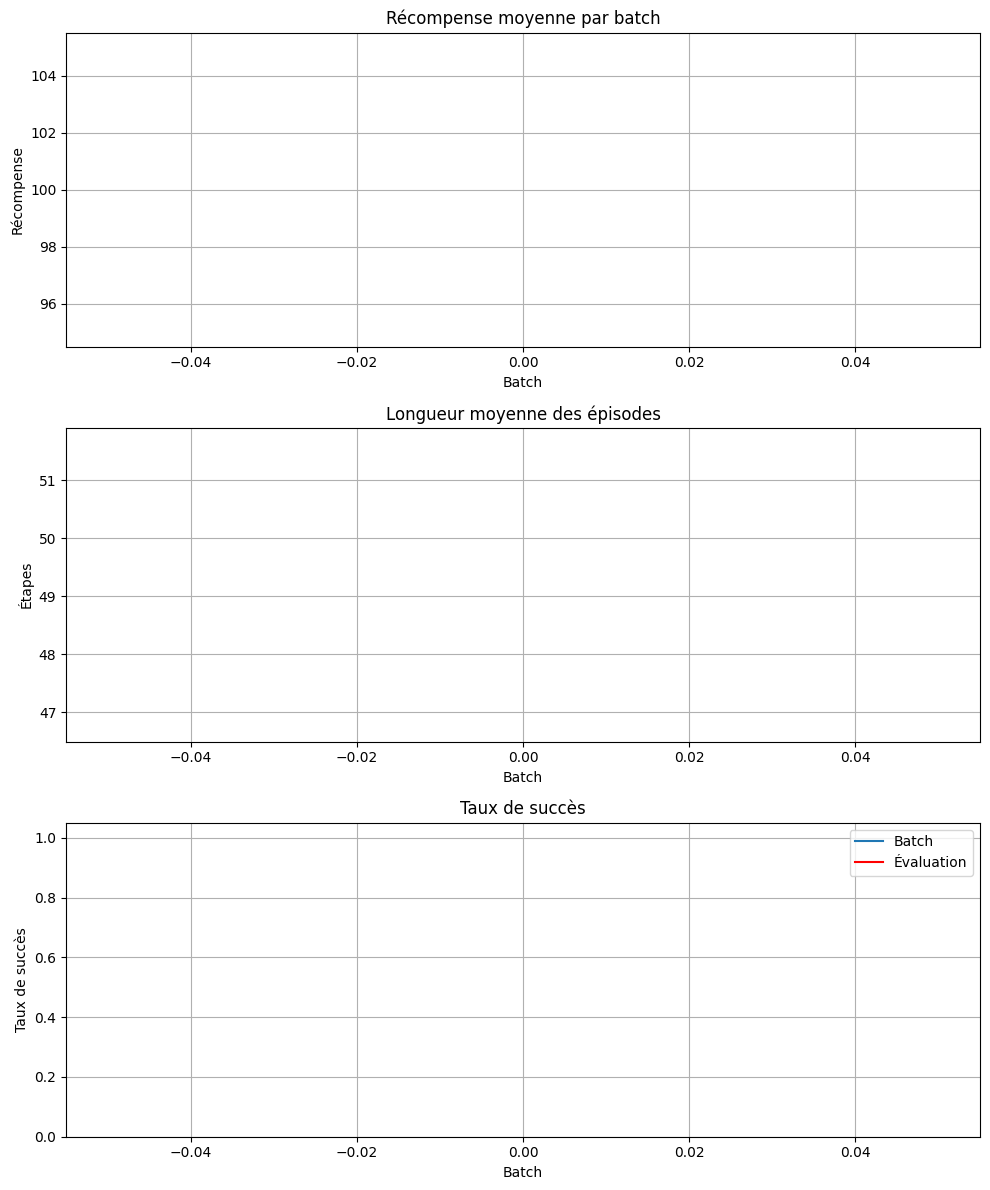

In [103]:
# Nouvelle cellule: Exécuter l'entraînement

# Paramètres d'entraînement
initial_windfields = ['training_1', 'training_2', 'training_3']
learning_rate = 0.01
gamma = 0.99
batch_size = 10
max_episodes = 1000  # Réduire pour un entraînement plus rapide
model_path = "models/wind_aware_navigator_trained.pkl"

# Créer le répertoire pour les modèles
os.makedirs("models", exist_ok=True)

# Créer l'entraîneur avec votre agent WindAwareNavigator existant
trainer = PolicyGradientTrainer(
    agent=WindAwareNavigator(),  # Utilise votre agent déjà implémenté
    initial_windfields=initial_windfields,
    learning_rate=learning_rate,
    gamma=gamma,
    batch_size=batch_size,
    max_episodes=max_episodes,
    model_save_path=model_path
)

# Évaluation initiale
print("Évaluation de l'agent initial...")
initial_score = trainer.evaluate_agent()
print(f"Taux de succès initial: {initial_score:.2%}")

# Entraînement par étapes - ceci est plus interactif qu'un entraînement complet
# Décommentez la ligne suivante pour un entraînement complet: 
# trained_agent = trainer.train()

# Collecter des expériences
print("Collecte d'expériences...")
success_rate = trainer.collect_experience(trainer.batch_size)
print(f"Taux de succès du batch: {success_rate:.2%}")

# Calculer les retours
returns = trainer.compute_returns()

# Mettre à jour la politique
print("Mise à jour de la politique...")
trainer.update_policy(returns)

# Évaluer à nouveau l'agent
new_score = trainer.evaluate_agent()
print(f"Taux de succès après mise à jour: {new_score:.2%}")
print(f"Amélioration: {new_score - initial_score:.2%}")

# Sauvegarder l'agent
trainer.save_agent()

# Afficher les métriques
plot_training_metrics(trainer)

In [100]:
# Nouvelle cellule: Tester l'agent entraîné

def test_agent(agent, initial_windfield_name='training_1', num_seeds=5, visualize=True):
    """
    Teste l'agent sur une configuration de vent spécifique.
    
    Args:
        agent: L'agent à tester
        initial_windfield_name: Nom de la configuration de vent
        num_seeds: Nombre de graines différentes à tester
        visualize: Si True, affiche une visualisation de la première trajectoire
        
    Returns:
        results: Dictionnaire avec les résultats d'évaluation
    """
    from src.evaluation import evaluate_agent
    from src.initial_windfields import get_initial_windfield
    
    # Créer l'environnement
    initial_windfield = get_initial_windfield(initial_windfield_name)
    
    # Préparer l'environnement pour la visualisation si nécessaire
    if visualize:
        initial_windfield.update({
            'env_params': {
                'wind_grid_density': 25,
                'wind_arrow_scale': 80,
                'render_mode': "rgb_array"
            }
        })
    
    # Évaluer l'agent
    results = evaluate_agent(
        agent=agent,
        initial_windfield=initial_windfield,
        seeds=list(range(num_seeds)),
        max_horizon=200,
        verbose=False,
        render=visualize,
        full_trajectory=visualize
    )
    
    # Afficher les résultats
    print(f"Résultats sur {initial_windfield_name}:")
    print(f"Taux de succès: {results['success_rate']:.2%}")
    print(f"Récompense moyenne: {results['mean_reward']:.2f}")
    print(f"Nombre moyen d'étapes: {results['mean_steps']:.1f}")
    
    # Visualiser la trajectoire si demandé
    if visualize and results.get('frames'):
        # Afficher le premier et le dernier frame
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        ax1.imshow(results['frames'][0])
        ax1.set_title('État initial')
        ax1.axis('off')
        ax2.imshow(results['frames'][-1])
        ax2.set_title('État final')
        ax2.axis('off')
        plt.show()
    
    return results

# Créer un agent et charger les poids entraînés
agent = WindAwareNavigator()
try:
    with open(model_path, 'rb') as f:
        models = pickle.load(f)
        agent.state_eval_model = models['state_eval_model']
        agent.wind_prediction_model = models['wind_prediction_model']
    print(f"Agent chargé depuis {model_path}")
except:
    print("Utilisation de l'agent non entraîné")

# Tester l'agent sur chaque configuration de vent
for initial_windfield_name in initial_windfields:
    test_agent(agent, initial_windfield_name, num_seeds=3, visualize=True)

Agent chargé depuis models/wind_aware_navigator_trained.pkl
Résultats sur training_1:
Taux de succès: 100.00%
Récompense moyenne: 59.26
Nombre moyen d'étapes: 53.7
Résultats sur training_2:
Taux de succès: 100.00%
Récompense moyenne: 76.25
Nombre moyen d'étapes: 28.0
Résultats sur training_3:
Taux de succès: 100.00%
Récompense moyenne: 50.62
Nombre moyen d'étapes: 69.0


In [44]:
import pickle
import numpy as np

# Charger le modèle
with open('/home/onyxia/work/RL_project_sailing/notebooks/models/wind_aware_navigator_trained.pkl', 'rb') as f:
    model = pickle.load(f)

# Si votre modèle est déjà dans le format de dictionnaire utilisé dans votre agent:
state_eval_model = model['state_eval_model']
wind_prediction_model = model['wind_prediction_model']

# Convertir les poids en chaînes de caractères pour les copier facilement
for key, value in state_eval_model.items():
    print(f"'{key}': np.array({value.tolist()}),")

for key, value in wind_prediction_model.items():
    print(f"'{key}': np.array({value.tolist()}),")

'W1': np.array([[0.019313364376407044, 0.07934115482951021, 0.017396672756038453, -0.10299534038410728, 0.05893156682027095, -0.0681874201828102, -0.14010442967953982, -0.11421291749560421, -0.09914004637651597, -0.035441075079443024], [-0.13237239038467008, 0.0598859977426523, 0.07538206218160674, -0.12002855333819118, 0.024079871823161726, -0.12112656817088392, 0.014243232929662572, 0.08566733733954174, 0.015753045165461936, 0.06374540965957134], [0.1687005167865639, 0.07212640821822593, -0.08974594453339996, -0.12039274585781268, 0.034650782550000536, -0.16453279286629507, 0.11882600324253059, -0.06294800504889238, -0.32184112864687053, -0.03269530192724545], [0.00906422636656765, -0.0899744828355049, -0.013391636323646481, 0.23445806930625426, 0.06891364430260084, 0.29055719860236423, 0.005583885399469348, 0.16840018954968594, -0.06860843952301734, -0.028529773878093783], [-0.0446081372592477, 0.02576882182157529, -0.009285763254401006, 0.21202599732017788, -0.03952236600414781, -0

In [102]:
# Créer un fichier utilitaire pour charger votre modèle spécifique

def create_custom_model_loader():
    """Crée un fichier utilitaire pour charger le modèle spécifique dans evaluate_agent.ipynb"""
    loader_code = """
import pickle
import numpy as np
import os

def load_trained_sailing_model(agent, 
                               model_path="/home/onyxia/work/RL_project_sailing/notebooks/models/wind_aware_navigator_trained.pkl"):
    \"\"\"
    Charge les poids entraînés dans l'agent WindAwareNavigator.
    
    Args:
        agent: L'agent WindAwareNavigator
        model_path: Chemin vers le fichier de poids (par défaut: celui existant)
        
    Returns:
        success: True si le chargement a réussi, False sinon
    \"\"\"
    try:
        if not os.path.exists(model_path):
            print(f"Fichier de modèle non trouvé: {model_path}")
            return False
            
        with open(model_path, 'rb') as f:
            models = pickle.load(f)
            
            if 'state_eval_model' in models and 'wind_prediction_model' in models:
                agent.state_eval_model = models['state_eval_model']
                agent.wind_prediction_model = models['wind_prediction_model']
                print(f"Modèle chargé avec succès depuis {model_path}")
                return True
            else:
                print("Format de modèle invalide - clés manquantes")
                return False
                
    except Exception as e:
        print(f"Erreur lors du chargement du modèle: {e}")
        return False
"""
    
    # Chemin de destination
    loader_path = "../src/utils/sailing_model_loader.py"
    
    # Créer le répertoire si nécessaire
    import os
    os.makedirs(os.path.dirname(loader_path), exist_ok=True)
    
    # Écrire le fichier
    with open(loader_path, 'w') as f:
        f.write(loader_code)
    
    # S'assurer que le fichier __init__.py existe
    init_path = "../src/utils/__init__.py"
    if not os.path.exists(init_path):
        with open(init_path, 'w') as f:
            f.write("# Utilitaires pour le projet sailing\n")
    
    print(f"Utilitaire de chargement créé dans {loader_path}")

# Créer l'utilitaire
create_custom_model_loader()

Utilitaire de chargement créé dans ../src/utils/sailing_model_loader.py


In [104]:
# Créez une classe qui étend SailingEnv pour modifier la récompense
import os
import sys
sys.path.append("..")
from src.env_sailing import SailingEnv

class EfficientSailingEnv(SailingEnv):
    """Version modifiée de l'environnement qui récompense l'efficacité."""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.last_distance = None
        self.step_penalty = -0.01  # Petite pénalité pour chaque étape
        self.cumulative_distance = 0.0
    
    def reset(self, *args, **kwargs):
        observation, info = super().reset(*args, **kwargs)
        self.last_distance = np.linalg.norm(self.position - self.goal_position)
        self.cumulative_distance = 0.0
        return observation, info
    
    def step(self, action):
        # Position avant le mouvement
        old_position = self.position.copy()
        
        # Faire le pas normal
        observation, reward, terminated, truncated, info = super().step(action)
        
        # Calculer la nouvelle distance au but
        current_distance = np.linalg.norm(self.position - self.goal_position)
        
        # Distance parcourue dans ce pas
        step_distance = np.linalg.norm(self.position - old_position)
        self.cumulative_distance += step_distance
        
        # Calculer la récompense modifiée
        if reward > 0:  # Si l'objectif est atteint
            # Récompense principale + bonus pour l'efficacité
            efficiency_bonus = 50.0 * (1.0 - self.cumulative_distance / (2.0 * self.last_distance))
            efficiency_bonus = max(0, efficiency_bonus)  # Pas de bonus négatif
            modified_reward = reward + efficiency_bonus
            
            # Ajouter l'information d'efficacité
            info['efficiency'] = efficiency_bonus / 50.0
            info['path_length'] = self.cumulative_distance
        else:
            # Petite récompense pour se rapprocher de l'objectif
            approach_reward = (self.last_distance - current_distance) * 0.5
            
            # Pénalité pour chaque étape pour encourager la rapidité
            modified_reward = approach_reward + self.step_penalty
            
            # Mettre à jour la dernière distance
            self.last_distance = current_distance
        
        return observation, modified_reward, terminated, truncated, info

# Fonction pour créer cet environnement amélioré
def create_efficient_environment(initial_windfield_name):
    """Crée un environnement qui encourage l'efficacité du parcours."""
    from src.initial_windfields import get_initial_windfield
    
    initial_windfield = get_initial_windfield(initial_windfield_name)
    env = EfficientSailingEnv(
        wind_init_params=initial_windfield['wind_init_params'],
        wind_evol_params=initial_windfield['wind_evol_params'],
        render_mode=None
    )
    return env

In [105]:
class ImprovedPolicyGradientTrainer(PolicyGradientTrainer):
    """Version améliorée de l'entraîneur pour optimiser l'efficacité."""
    
    def create_environment(self, initial_windfield_name):
        """Utilise l'environnement amélioré au lieu de l'environnement standard."""
        return create_efficient_environment(initial_windfield_name)
    
    def evaluate_agent(self):
        """
        Évalue les performances de l'agent avec un focus sur l'efficacité.
        
        Returns:
            avg_score: Score moyen combinant réussite et efficacité
        """
        from src.evaluation import evaluate_agent
        from src.initial_windfields import get_initial_windfield
        
        success_rates = []
        efficiency_scores = []
        
        for initial_windfield_name in self.initial_windfields:
            # Évaluer sur plusieurs graines
            seeds = list(range(10))  # 10 graines différentes
            
            # Créer l'environnement
            initial_windfield = get_initial_windfield(initial_windfield_name)
            
            # Évaluer l'agent
            results = evaluate_agent(
                agent=self.agent,
                initial_windfield=initial_windfield,
                seeds=seeds,
                max_horizon=self.max_steps_per_episode,
                verbose=False,
                render=False,
                full_trajectory=False
            )
            
            success_rates.append(results['success_rate'])
            
            # Calculer un score d'efficacité basé sur le nombre d'étapes
            # Plus le nombre d'étapes est petit, meilleur est le score
            # Normaliser pour obtenir un score entre 0 et 1
            if results['success_rate'] > 0:
                # Estimation d'un chemin idéal (distance directe)
                ideal_steps = 32  # Une estimation, à ajuster selon votre environnement
                actual_steps = results['mean_steps']
                
                # Score d'efficacité: 1.0 pour le chemin idéal, diminue avec plus d'étapes
                efficiency = min(1.0, ideal_steps / actual_steps)
                efficiency_scores.append(efficiency)
            else:
                efficiency_scores.append(0.0)
        
        # Combiner les scores
        avg_success_rate = np.mean(success_rates)
        avg_efficiency = np.mean(efficiency_scores)
        
        # Score combiné: 50% réussite, 50% efficacité
        combined_score = 0.5 * avg_success_rate + 0.5 * avg_efficiency
        
        self.evaluation_scores.append(combined_score)
        
        print(f"Taux de succès moyen: {avg_success_rate:.2%}")
        print(f"Score d'efficacité moyen: {avg_efficiency:.2%}")
        print(f"Score combiné: {combined_score:.2%}")
        
        return combined_score

In [107]:
# Créer et utiliser l'entraîneur amélioré
improved_trainer = ImprovedPolicyGradientTrainer(
    agent=WindAwareNavigator(),
    initial_windfields=['training_1', 'training_2', 'training_3'],
    learning_rate=0.01,
    gamma=0.99,
    batch_size=10,
    max_episodes=1000,
    model_save_path="models/efficient_navigator.pkl"
)

# Évaluation initiale
print("Évaluation de l'agent initial...")
initial_score = improved_trainer.evaluate_agent()

# Entraînement complet
print("\nDémarrage de l'entraînement pour optimiser l'efficacité...")
trained_agent = improved_trainer.train()

# Fonction pour tester l'efficacité des agents
def compare_efficiency(agent_default, agent_trained):
    """Compare l'efficacité entre deux agents."""
    from src.evaluation import evaluate_agent
    from src.initial_windfields import get_initial_windfield
    
    results = {}
    
    for name in ['training_1', 'training_2', 'training_3']:
        initial_windfield = get_initial_windfield(name)
        
        # Évaluer l'agent par défaut
        default_results = evaluate_agent(
            agent=agent_default,
            initial_windfield=initial_windfield,
            seeds=list(range(10)),
            max_horizon=200,
            verbose=False
        )
        
        # Évaluer l'agent entraîné
        trained_results = evaluate_agent(
            agent=agent_trained,
            initial_windfield=initial_windfield,
            seeds=list(range(10)),
            max_horizon=200,
            verbose=False
        )
        
        # Comparer les résultats
        results[name] = {
            'default_steps': default_results['mean_steps'],
            'trained_steps': trained_results['mean_steps'],
            'improvement': (default_results['mean_steps'] - trained_results['mean_steps']) / default_results['mean_steps'] * 100
        }
    
    # Afficher les résultats
    print("\n--- Comparaison d'efficacité ---")
    for name, res in results.items():
        print(f"{name}:")
        print(f"  Agent par défaut: {res['default_steps']:.1f} étapes")
        print(f"  Agent entraîné:   {res['trained_steps']:.1f} étapes")
        print(f"  Amélioration:     {res['improvement']:.1f}%")
    
    return results

# Comparer l'agent entraîné avec l'agent d'origine
agent_default = WindAwareNavigator()
efficiency_results = compare_efficiency(agent_default, trained_agent)

Évaluation de l'agent initial...
Taux de succès moyen: 100.00%
Score d'efficacité moyen: 66.99%
Score combiné: 83.50%

Démarrage de l'entraînement pour optimiser l'efficacité...
Démarrage de l'entraînement du WindAwareNavigator...
Évaluation initiale de l'agent...
Taux de succès moyen: 100.00%
Score d'efficacité moyen: 65.64%
Score combiné: 82.82%
Taux de succès initial: 82.82%

Épisodes 0-9
Collecte d'expériences...
Taux de succès du batch: 100.00%
Mise à jour de la politique...
Évaluation de l'agent...
Taux de succès moyen: 100.00%
Score d'efficacité moyen: 67.36%
Score combiné: 83.68%
Taux de succès d'évaluation: 83.68%
Agent sauvegardé dans models/efficient_navigator.pkl
Nouveau meilleur taux de succès: 83.68%
Récompense moyenne: 113.70
Longueur moyenne d'épisode: 58.4

Épisodes 10-19
Collecte d'expériences...
Taux de succès du batch: 100.00%
Mise à jour de la politique...
Récompense moyenne: 113.78
Longueur moyenne d'épisode: 55.4

Épisodes 20-29
Collecte d'expériences...
Taux de 

In [116]:
# Implémentation de PPO pour le WindAwareNavigator
import numpy as np
import time
import pickle
import os
from collections import deque

class PPOTrainer:
    """
    Entraîneur PPO (Proximal Policy Optimization) pour le WindAwareNavigator.
    Optimise spécifiquement l'efficacité des trajectoires.
    """
    
    def __init__(self, 
                agent,
                initial_windfields=['training_1', 'training_2', 'training_3'],
                learning_rate=0.001,
                gamma=0.99,
                clip_ratio=0.2,
                batch_size=20,
                epochs=5,
                max_episodes=1000,
                model_save_path='models/ppo_navigator.pkl',
                seed=None):
        """
        Initialise l'entraîneur PPO.
        
        Args:
            agent: L'agent WindAwareNavigator à entraîner
            initial_windfields: Liste des configurations de vent pour l'entraînement
            learning_rate: Taux d'apprentissage pour la mise à jour des poids
            gamma: Facteur d'actualisation pour le calcul des retours
            clip_ratio: Paramètre d'écrêtage de PPO pour limiter les mises à jour
            batch_size: Nombre d'épisodes avant mise à jour des poids
            epochs: Nombre d'époques de mise à jour pour chaque batch
            max_episodes: Nombre maximum d'épisodes d'entraînement
            model_save_path: Chemin où sauvegarder l'agent entraîné
        """
        self.agent = agent
        self.initial_windfields = initial_windfields
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.batch_size = batch_size
        self.epochs = epochs
        self.max_episodes = max_episodes
        self.model_save_path = model_save_path
        
        # Variables de suivi de l'entraînement
        self.episode_rewards = []
        self.episode_lengths = []
        self.success_rates = []
        self.evaluation_scores = []
        
        # Buffer pour stocker les expériences
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.next_states = []
        self.action_probs = []  # Probabilités d'action pour calculer le ratio
        self.np_random = np.random.RandomState(seed)
        # Créer le répertoire pour sauvegarder les modèles si nécessaire
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
        
        # Historique des valeurs
        self.value_history = deque(maxlen=1000)
    
    def create_efficient_environment(self, initial_windfield_name):
        """Crée un environnement qui encourage l'efficacité du parcours."""
        from src.initial_windfields import get_initial_windfield
        from src.env_sailing import SailingEnv
        
        class EfficientSailingEnv(SailingEnv):
            """Version modifiée qui récompense l'efficacité."""
            
            def __init__(self, *args, **kwargs):
                super().__init__(*args, **kwargs)
                self.last_distance = None
                self.step_penalty = -0.01  # Petite pénalité pour chaque étape
                self.cumulative_distance = 0.0
                self.last_position = None
            
            def reset(self, *args, **kwargs):
                observation, info = super().reset(*args, **kwargs)
                self.last_distance = np.linalg.norm(self.position - self.goal_position)
                self.cumulative_distance = 0.0
                self.last_position = self.position.copy()
                return observation, info
            
            def step(self, action):
                # Position avant le mouvement
                old_position = self.position.copy()
                
                # Faire le pas normal
                observation, reward, terminated, truncated, info = super().step(action)
                
                # Calculer la nouvelle distance au but
                current_distance = np.linalg.norm(self.position - self.goal_position)
                
                # Distance parcourue dans ce pas
                step_distance = np.linalg.norm(self.position - old_position)
                self.cumulative_distance += step_distance
                
                # Calculer la récompense modifiée
                if reward > 0:  # Si l'objectif est atteint
                    # Récompense principale + bonus pour l'efficacité
                    efficiency_bonus = 50.0 * (1.0 - self.cumulative_distance / (2.0 * self.last_distance))
                    efficiency_bonus = max(0, efficiency_bonus)  # Pas de bonus négatif
                    modified_reward = reward + efficiency_bonus
                    
                    # Ajouter l'information d'efficacité
                    info['efficiency'] = efficiency_bonus / 50.0
                    info['path_length'] = self.cumulative_distance
                else:
                    # Petite récompense pour se rapprocher de l'objectif
                    approach_reward = (self.last_distance - current_distance) * 0.5
                    
                    # Pénalité pour chaque étape pour encourager la rapidité
                    modified_reward = approach_reward + self.step_penalty
                    
                    # Pénalité supplémentaire pour les zigzags inefficaces
                    if self.last_position is not None:
                        # Vecteur vers l'objectif
                        goal_vector = self.goal_position - old_position
                        goal_direction = goal_vector / (np.linalg.norm(goal_vector) + 1e-10)
                        
                        # Vecteur du mouvement actuel
                        movement_vector = self.position - old_position
                        if np.linalg.norm(movement_vector) > 0.001:
                            movement_direction = movement_vector / np.linalg.norm(movement_vector)
                            
                            # Alignement avec la direction de l'objectif
                            goal_alignment = np.dot(movement_direction, goal_direction)
                            
                            # Bonus pour l'alignement avec l'objectif (si possible selon le vent)
                            current_wind = self._get_wind_at_position(old_position)
                            wind_norm = current_wind / (np.linalg.norm(current_wind) + 1e-10)
                            wind_from = -wind_norm
                            
                            # Vérifier si l'alignement avec l'objectif est possible
                            # (pas dans la zone interdite contre le vent)
                            angle_wind_goal = np.arccos(np.clip(np.dot(wind_from, goal_direction), -1.0, 1.0))
                            
                            if angle_wind_goal > np.pi/6:  # Si pas contre le vent
                                # Bonus pour l'alignement avec l'objectif
                                modified_reward += 0.2 * goal_alignment
                    
                    # Mettre à jour la dernière distance et position
                    self.last_distance = current_distance
                    self.last_position = self.position.copy()
                
                return observation, modified_reward, terminated, truncated, info
        
        initial_windfield = get_initial_windfield(initial_windfield_name)
        env = EfficientSailingEnv(
            wind_init_params=initial_windfield['wind_init_params'],
            wind_evol_params=initial_windfield['wind_evol_params'],
            render_mode=None
        )
        return env
    
    def preprocess_state(self, observation):
        """Prétraite l'observation pour l'utiliser avec les réseaux de neurones."""
        position = np.array([observation[0], observation[1]])
        velocity = np.array([observation[2], observation[3]])
        wind = np.array([observation[4], observation[5]])
        
        # Normaliser les entrées
        pos_norm = position / np.array(self.agent.grid_size)
        vel_norm = velocity / 2.0 if np.linalg.norm(velocity) > 0 else np.zeros(2)
        wind_norm = wind / 5.0 if np.linalg.norm(wind) > 0 else np.zeros(2)
        
        # Concaténer les caractéristiques normalisées
        return np.concatenate([pos_norm, vel_norm, wind_norm])
    
    def get_action_probabilities(self, observation):
        """
        Calcule les probabilités pour chaque action en fonction des évaluations du réseau.
        Nécessaire pour le calcul des ratios dans PPO.
        """
        # Extraire les informations de l'observation
        position = np.array([observation[0], observation[1]])
        velocity = np.array([observation[2], observation[3]])
        wind_at_position = np.array([observation[4], observation[5]])
        
        # Évaluer chaque action possible
        action_values = np.zeros(9)  # 9 actions possibles
        valid_actions = []
        
        for action in range(9):
            direction = self.agent.action_to_direction(action)
            next_pos = position + direction
            
            # Vérifier les limites pour les actions de mouvement
            if action < 8:  # Toutes les actions sauf "rester en place"
                if not (0 <= next_pos[0] < self.agent.grid_size[0] and 
                        0 <= next_pos[1] < self.agent.grid_size[1]):
                    action_values[action] = -float('inf')
                    continue
            
            # Estimer la nouvelle vitesse pour les actions de mouvement
            if action < 8:
                boat_dir = direction / np.linalg.norm(direction)
                wind_norm = wind_at_position / (np.linalg.norm(wind_at_position) + 1e-10)
                sailing_efficiency = self.agent.calculate_sailing_efficiency(boat_dir, wind_norm)
                next_vel = boat_dir * sailing_efficiency * np.linalg.norm(wind_at_position) * 0.4
            else:
                next_vel = velocity * 0.3  # Inertie réduite pour "rester en place"
            
            # Évaluer l'état résultant
            state_value = self.agent.evaluate_state(next_pos, next_vel, wind_at_position)
            action_values[action] = state_value
            valid_actions.append(action)
        
        # Convertir en probabilités avec softmax
        # Appliquer seulement aux actions valides
        max_value = np.max(action_values)
        exp_values = np.exp(action_values - max_value)  # Pour stabilité numérique
        probs = exp_values / np.sum(exp_values)
        
        return probs
    
    def collect_experience(self, num_episodes):
        """
        Collecte des expériences en exécutant l'agent dans l'environnement.
        Stocke aussi les probabilités d'action pour le calcul de PPO.
        """
        # Réinitialiser les buffers
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.next_states = []
        self.action_probs = []
        
        episode_rewards_buffer = []
        episode_lengths_buffer = []
        successes = 0
        
        for _ in range(num_episodes):
            # Choisir aléatoirement une configuration de vent
            initial_windfield_name = np.random.choice(self.initial_windfields)
            env = self.create_efficient_environment(initial_windfield_name)
            
            # Réinitialiser l'environnement et l'agent
            observation, _ = env.reset(seed=np.random.randint(0, 1000))
            self.agent.reset()
            
            episode_reward = 0
            episode_states = []
            episode_actions = []
            episode_rewards = []
            episode_dones = []
            episode_next_states = []
            episode_action_probs = []
            
            # Exécuter un épisode
            for step in range(500):  # Limite élevée pour les scénarios difficiles
                # Calculer les probabilités d'action avec l'état actuel
                action_probs = self.get_action_probabilities(observation)
                
                # Obtenir l'action de l'agent
                action = self.agent.act(observation)
                
                # Stocker la probabilité de l'action choisie
                action_prob = action_probs[action]
                
                # Exécuter l'action
                next_observation, reward, done, truncated, _ = env.step(action)
                
                # Stocker l'expérience
                state = self.preprocess_state(observation)
                next_state = self.preprocess_state(next_observation)
                
                episode_states.append(state)
                episode_actions.append(action)
                episode_rewards.append(reward)
                episode_dones.append(done or truncated)
                episode_next_states.append(next_state)
                episode_action_probs.append(action_prob)
                
                episode_reward += reward
                observation = next_observation
                
                if done or truncated:
                    break
            
            # Ajouter les données de l'épisode aux buffers
            self.states.extend(episode_states)
            self.actions.extend(episode_actions)
            self.rewards.extend(episode_rewards)
            self.dones.extend(episode_dones)
            self.next_states.extend(episode_next_states)
            self.action_probs.extend(episode_action_probs)
            
            # Mettre à jour les métriques
            episode_rewards_buffer.append(episode_reward)
            episode_lengths_buffer.append(step + 1)
            if episode_reward > 0:  # Si une récompense positive, considérer comme succès
                successes += 1
        
        # Calculer les statistiques
        self.episode_rewards.append(np.mean(episode_rewards_buffer))
        self.episode_lengths.append(np.mean(episode_lengths_buffer))
        success_rate = successes / num_episodes
        self.success_rates.append(success_rate)
        
        return success_rate
    
    def compute_returns_and_advantages(self):
        """
        Calcule les retours (discounted returns) et les avantages pour PPO.
        
        Returns:
            returns: Liste des retours pour chaque état
            advantages: Liste des avantages pour chaque état
        """
        # Identifier les limites des épisodes
        episode_ends = [i for i, done in enumerate(self.dones) if done]
        if not episode_ends or episode_ends[-1] != len(self.dones) - 1:
            episode_ends.append(len(self.dones) - 1)
        
        # Calculer les retours et les avantages pour chaque épisode
        returns = np.zeros(len(self.rewards))
        
        # Valeurs de base pour chaque état
        state_values = np.zeros(len(self.states))
        for i, state in enumerate(self.states):
            # Convertir l'état prétraité en paramètres pour evaluate_state
            position = np.array([state[0], state[1]]) * self.agent.grid_size
            velocity = np.array([state[2], state[3]]) * 2.0
            wind = np.array([state[4], state[5]]) * 5.0
            
            # Obtenir la valeur d'état de base
            state_values[i] = self.agent.evaluate_state(position, velocity, wind)
        
        # Stocker les valeurs pour analyse
        self.value_history.extend(state_values)
        
        start_idx = 0
        advantages = np.zeros(len(self.rewards))
        
        for end_idx in episode_ends:
            # Calculer les retours pour cet épisode
            episode_returns = np.zeros(end_idx - start_idx + 1)
            discounted_sum = 0
            
            # Calculer les retours (du futur vers le présent)
            for i in range(end_idx, start_idx - 1, -1):
                discounted_sum = self.rewards[i] + self.gamma * discounted_sum * (1 - self.dones[i])
                episode_returns[i - start_idx] = discounted_sum
            
            # Calculer les avantages (returns - baseline)
            episode_advantages = episode_returns - state_values[start_idx:end_idx + 1]
            
            # Normaliser les avantages pour cet épisode
            if len(episode_advantages) > 1:
                episode_advantages = (episode_advantages - np.mean(episode_advantages)) / (np.std(episode_advantages) + 1e-8)
            
            # Stocker les retours et avantages
            returns[start_idx:end_idx + 1] = episode_returns
            advantages[start_idx:end_idx + 1] = episode_advantages
            
            # Passer à l'épisode suivant
            start_idx = end_idx + 1
        
        return returns, advantages
    
    def update_policy_ppo(self, returns, advantages):
        """
        Met à jour les poids des réseaux selon l'algorithme PPO.
        
        Args:
            returns: Retours calculés pour chaque état
            advantages: Avantages calculés pour chaque état
        """
        # Convertir les listes en tableaux numpy
        states = np.array(self.states)
        actions = np.array(self.actions)
        old_probs = np.array(self.action_probs)
        
        # Effectuer plusieurs passes d'optimisation sur le même batch
        for epoch in range(self.epochs):
            # Parcourir les données par mini-batchs (on peut simplifier en utilisant tout le batch)
            indices = np.arange(len(states))
            self.np_random.shuffle(indices)
            
            for start_idx in range(0, len(indices), 256):  # Taille de mini-batch = 256
                end_idx = min(start_idx + 256, len(indices))
                batch_indices = indices[start_idx:end_idx]
                
                # Extraire les données du mini-batch
                batch_states = states[batch_indices]
                batch_actions = actions[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_old_probs = old_probs[batch_indices]
                
                # Pour chaque exemple du mini-batch
                for state, action, advantage, old_prob in zip(batch_states, batch_actions, batch_advantages, batch_old_probs):
                    # Recalculer les probabilités actuelles
                    # On pourrait optimiser en calculant toutes les probabilités en une fois
                    position = np.array([state[0], state[1]]) * self.agent.grid_size
                    velocity = np.array([state[2], state[3]]) * 2.0
                    wind = np.array([state[4], state[5]]) * 5.0
                    
                    # Construire une observation factice pour get_action_probabilities
                    fake_obs = np.concatenate([
                        position, velocity, wind,
                        np.zeros(self.agent.grid_size[0] * self.agent.grid_size[1] * 2)  # Wind field vide
                    ])
                    
                    # Obtenir les probabilités actuelles (sans détachement du gradient, contrairement à PyTorch)
                    current_probs = self.get_action_probabilities(fake_obs)
                    current_prob = current_probs[action]
                    
                    # Calculer le ratio pour PPO
                    ratio = current_prob / (old_prob + 1e-10)
                    
                    # Calculer les deux termes de la fonction objectif PPO
                    obj_1 = ratio * advantage
                    obj_2 = np.clip(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio) * advantage
                    
                    # Prendre le minimum pour l'objectif clippé
                    ppo_loss = -min(obj_1, obj_2)
                    
                    # Mise à jour manuelle des poids (approximation de la descente de gradient)
                    # Note: Dans un framework comme PyTorch, on calculerait le gradient et ferait une mise à jour propre
                    
                    # Si on utilise une mise à jour manuelle, on peut faire:
                    # (Les valeurs ajustées ici sont approximatives)
                    if ppo_loss > 0:  # On veut minimiser la perte
                        # Calculer le delta pour les poids
                        # On utilise un signe opposé à la perte pour descendre le gradient
                        update_factor = self.learning_rate * min(1.0, abs(advantage)) * np.sign(-ppo_loss)
                        
                        # Mise à jour des poids - version simplifiée
                        # Dans un framework d'apprentissage profond, on ferait une vraie descente de gradient
                        # Ici, on fait une modification directe des poids dans la direction qui améliore la politique
                        
                        # Les poids du modèle d'évaluation d'état influencent directement la sélection d'action
                        # On peut donc les modifier pour promouvoir l'action si avantage positif ou la décourager si négatif
                        hidden_activation = np.tanh(np.dot(state, self.agent.state_eval_model['W1']) + self.agent.state_eval_model['b1'])
                        second_hidden = np.tanh(np.dot(hidden_activation, self.agent.state_eval_model['W2']) + self.agent.state_eval_model['b2'])
                        
                        # Modifier W3 pour favoriser/défavoriser l'action en fonction de l'avantage
                        delta_W3 = update_factor * np.outer(second_hidden, np.ones(1))
                        self.agent.state_eval_model['W3'] += delta_W3
                        self.agent.state_eval_model['b3'] += update_factor
    
    def evaluate_agent(self):
        """
        Évalue les performances de l'agent sur l'efficacité des trajectoires.
        
        Returns:
            avg_score: Score combinant succès et efficacité
        """
        from src.evaluation import evaluate_agent
        from src.initial_windfields import get_initial_windfield
        
        success_rates = []
        efficiency_scores = []
        
        for initial_windfield_name in self.initial_windfields:
            # Créer l'environnement
            initial_windfield = get_initial_windfield(initial_windfield_name)
            
            # Évaluer l'agent
            results = evaluate_agent(
                agent=self.agent,
                initial_windfield=initial_windfield,
                seeds=list(range(10)),
                max_horizon=200,
                verbose=False,
                render=False,
                full_trajectory=True  # Pour obtenir les positions
            )
            
            success_rates.append(results['success_rate'])
            
            # Calculer l'efficacité moyenne du chemin
            if results.get('positions') and results['success_rate'] > 0:
                # Pour chaque trajectoire réussie, calculer l'efficacité
                path_efficiency = []
                
                for seed_idx, positions in enumerate(results.get('positions', [])):
                    if positions:
                        # Calculer la longueur du chemin
                        path_length = 0
                        for i in range(1, len(positions)):
                            path_length += np.linalg.norm(np.array(positions[i]) - np.array(positions[i-1]))
                        
                        # Distance directe
                        direct_distance = np.linalg.norm(np.array(positions[0]) - np.array(positions[-1]))
                        
                        # Efficacité = distance directe / longueur réelle du chemin
                        # Plus ce ratio est proche de 1, plus le chemin est efficace
                        efficiency = direct_distance / (path_length + 1e-10)
                        efficiency = min(1.0, efficiency)  # Plafonner à 1.0
                        path_efficiency.append(efficiency)
                
                if path_efficiency:
                    avg_path_efficiency = np.mean(path_efficiency)
                    efficiency_scores.append(avg_path_efficiency)
            else:
                efficiency_scores.append(0.0)
        
        # Calculer les scores moyens
        avg_success_rate = np.mean(success_rates)
        avg_efficiency = np.mean(efficiency_scores) if efficiency_scores else 0.0
        
        # Score combiné: 60% succès, 40% efficacité
        combined_score = 0.6 * avg_success_rate + 0.4 * avg_efficiency
        
        self.evaluation_scores.append(combined_score)
        
        print(f"Taux de succès: {avg_success_rate:.2%}")
        print(f"Efficacité moyenne: {avg_efficiency:.2%}")
        print(f"Score combiné: {combined_score:.2%}")
        
        return combined_score
    
    def save_agent(self):
        """Sauvegarde l'agent entraîné."""
        with open(self.model_save_path, 'wb') as f:
            pickle.dump({
                'state_eval_model': self.agent.state_eval_model,
                'wind_prediction_model': self.agent.wind_prediction_model
            }, f)
        print(f"Agent sauvegardé dans {self.model_save_path}")
    
    def load_agent(self):
        """Charge un agent préalablement entraîné."""
        try:
            with open(self.model_save_path, 'rb') as f:
                models = pickle.load(f)
                self.agent.state_eval_model = models['state_eval_model']
                self.agent.wind_prediction_model = models['wind_prediction_model']
            print(f"Agent chargé depuis {self.model_save_path}")
            return True
        except:
            print(f"Impossible de charger l'agent depuis {self.model_save_path}")
            return False
    
    def train(self):
        """
        Exécute le processus complet d'entraînement avec PPO.
        
        Returns:
            agent: L'agent entraîné
        """
        print("Démarrage de l'entraînement PPO pour le WindAwareNavigator...")
        start_time = time.time()
        
        # Évaluer l'agent avant l'entraînement
        print("Évaluation initiale de l'agent...")
        initial_score = self.evaluate_agent()
        print(f"Score initial: {initial_score:.2%}")
        
        # Boucle principale d'entraînement
        best_score = initial_score
        episodes_without_improvement = 0
        
        for episode in range(0, self.max_episodes, self.batch_size):
            # Afficher la progression
            print(f"\nÉpisodes {episode}-{episode + self.batch_size - 1}/{self.max_episodes}")
            
            # Collecter des expériences
            print("Collecte d'expériences...")
            success_rate = self.collect_experience(self.batch_size)
            print(f"Taux de succès du batch: {success_rate:.2%}")
            
            # Calculer les retours et avantages
            returns, advantages = self.compute_returns_and_advantages()
            
            # Mettre à jour la politique avec PPO
            print("Mise à jour de la politique avec PPO...")
            self.update_policy_ppo(returns, advantages)
            
            # Évaluer périodiquement l'agent (tous les 5 batches)
            if (episode // self.batch_size) % 5 == 0:
                print("Évaluation de l'agent...")
                eval_score = self.evaluate_agent()
                print(f"Score d'évaluation: {eval_score:.2%}")
                
                # Sauvegarder le meilleur modèle
                if eval_score > best_score:
                    best_score = eval_score
                    self.save_agent()
                    episodes_without_improvement = 0
                    print(f"Nouveau meilleur score: {best_score:.2%}")
                else:
                    episodes_without_improvement += self.batch_size
            
            # Arrêter si pas d'amélioration pendant longtemps
            if episodes_without_improvement >= 50:
                print("Pas d'amélioration depuis 50 épisodes. Arrêt de l'entraînement.")
                break
            
            # Afficher les statistiques
            print(f"Récompense moyenne: {self.episode_rewards[-1]:.2f}")
            print(f"Longueur moyenne d'épisode: {self.episode_lengths[-1]:.1f}")
        
        # Durée totale d'entraînement
        training_time = time.time() - start_time
        print(f"\nEntraînement terminé en {training_time:.2f} secondes!")
        print(f"Meilleur score: {best_score:.2%}")
        print(f"Amélioration: {best_score - initial_score:.2%}")
        
        # Charger le meilleur modèle
        self.load_agent()
        
        return self.agent

Évaluation initiale...
Taux de succès: 100.00%
Efficacité moyenne: 0.00%
Score combiné: 60.00%

Démarrage de l'entraînement PPO pour 100 épisodes...

Épisodes 0-19/100
Collecte d'expériences...
Taux de succès du batch: 100.00%
Mise à jour de la politique avec PPO...
Évaluation de l'agent...
Taux de succès: 100.00%
Efficacité moyenne: 0.00%
Score combiné: 60.00%
Score d'évaluation: 60.00%
Agent sauvegardé dans models/ppo_navigator.pkl

Épisodes 20-39/100
Collecte d'expériences...
Taux de succès du batch: 100.00%
Mise à jour de la politique avec PPO...

Épisodes 40-59/100
Collecte d'expériences...
Taux de succès du batch: 100.00%
Mise à jour de la politique avec PPO...

Épisodes 60-79/100
Collecte d'expériences...
Taux de succès du batch: 100.00%
Mise à jour de la politique avec PPO...
Évaluation de l'agent...
Taux de succès: 100.00%
Efficacité moyenne: 0.00%
Score combiné: 60.00%
Score d'évaluation: 60.00%
Agent sauvegardé dans models/ppo_navigator.pkl

Épisodes 80-99/100
Collecte d'exp

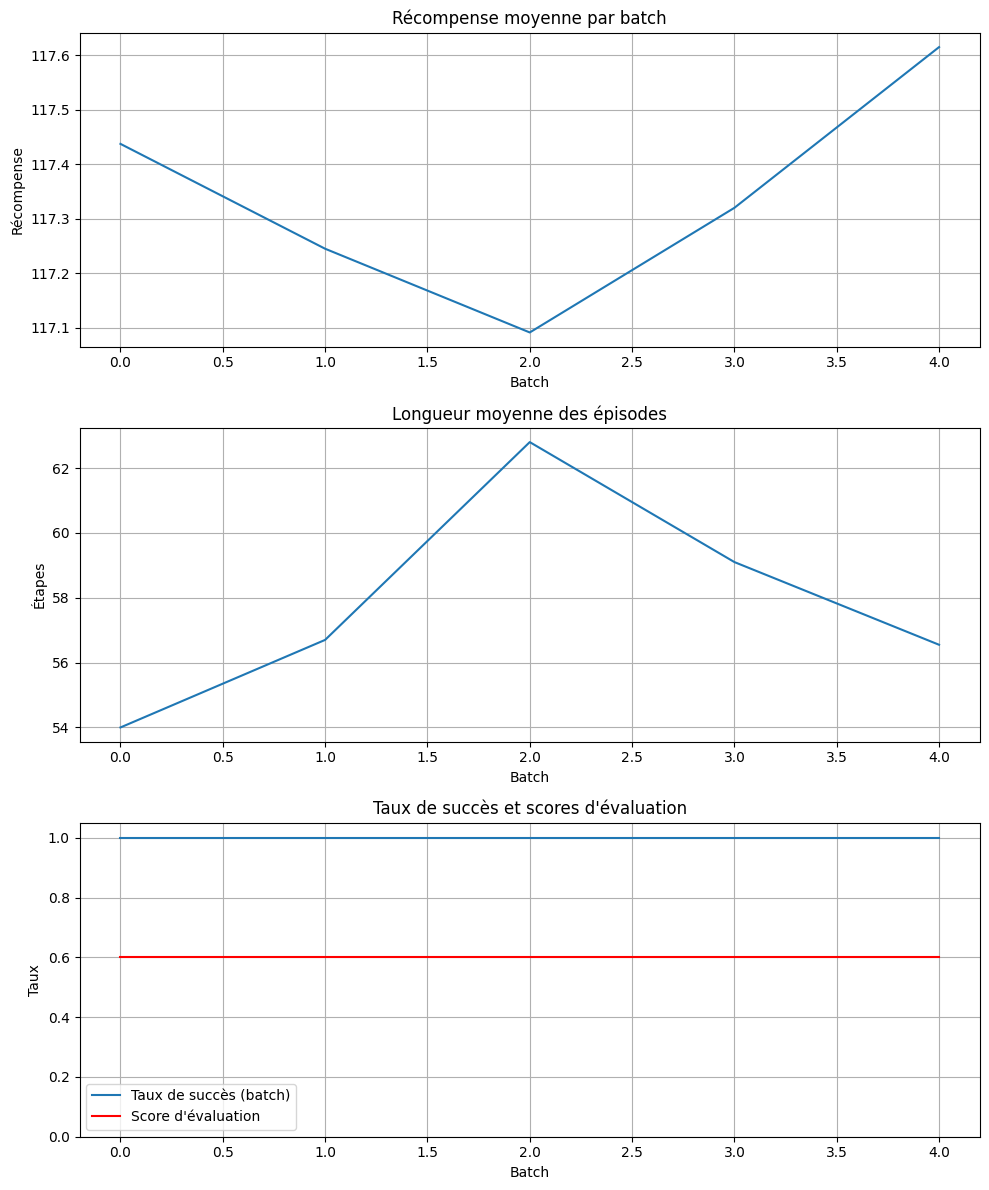

In [117]:
# Créer votre agent
agent = WindAwareNavigator()
# Initialiser l'entraîneur PPO
ppo_trainer = PPOTrainer(
   agent=agent,
   initial_windfields=['training_1', 'training_2', 'training_3'],
   learning_rate=0.001,
   gamma=0.99,
   clip_ratio=0.2,
   batch_size=20,
   epochs=4,
   max_episodes=500,
   model_save_path="models/ppo_navigator.pkl"
)

# Évaluation initiale
print("Évaluation initiale...")
initial_score = ppo_trainer.evaluate_agent()

# Entraînement court pour démonstration
# Vous pouvez ajuster le nombre d'épisodes selon vos besoins
num_episodes = 100  # Ajustez ce nombre pour un entraînement plus ou moins long

print(f"\nDémarrage de l'entraînement PPO pour {num_episodes} épisodes...")
for episode in range(0, num_episodes, ppo_trainer.batch_size):
   print(f"\nÉpisodes {episode}-{episode + ppo_trainer.batch_size - 1}/{num_episodes}")
   
   # Collecter des expériences
   print("Collecte d'expériences...")
   success_rate = ppo_trainer.collect_experience(ppo_trainer.batch_size)
   print(f"Taux de succès du batch: {success_rate:.2%}")
   
   # Calculer les retours et avantages
   returns, advantages = ppo_trainer.compute_returns_and_advantages()
   
   # Mettre à jour la politique avec PPO
   print("Mise à jour de la politique avec PPO...")
   ppo_trainer.update_policy_ppo(returns, advantages)
   
   # Évaluer périodiquement
   if (episode // ppo_trainer.batch_size) % 3 == 0 or episode + ppo_trainer.batch_size >= num_episodes:
       print("Évaluation de l'agent...")
       eval_score = ppo_trainer.evaluate_agent()
       print(f"Score d'évaluation: {eval_score:.2%}")
       
       # Sauvegarder l'agent
       ppo_trainer.save_agent()

# Évaluation finale
print("\nÉvaluation finale après entraînement...")
final_score = ppo_trainer.evaluate_agent()

print(f"\nAmélioration: {final_score - initial_score:.2%}")

# Visualiser les résultats d'entraînement
def plot_ppo_training_results(trainer):
   """Affiche les métriques d'entraînement PPO sous forme de graphiques."""
   fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
   
   # Graphique des récompenses
   ax1.plot(trainer.episode_rewards)
   ax1.set_title('Récompense moyenne par batch')
   ax1.set_xlabel('Batch')
   ax1.set_ylabel('Récompense')
   ax1.grid(True)
   
   # Graphique des longueurs d'épisodes
   ax2.plot(trainer.episode_lengths)
   ax2.set_title('Longueur moyenne des épisodes')
   ax2.set_xlabel('Batch')
   ax2.set_ylabel('Étapes')
   ax2.grid(True)
   
   # Graphique des taux de succès et scores d'évaluation
   ax3.plot(trainer.success_rates, label='Taux de succès (batch)')
   if trainer.evaluation_scores:
       eval_x = np.linspace(0, len(trainer.success_rates)-1, len(trainer.evaluation_scores))
       ax3.plot(eval_x, trainer.evaluation_scores, 'r-', label='Score d\'évaluation')
   ax3.set_title('Taux de succès et scores d\'évaluation')
   ax3.set_xlabel('Batch')
   ax3.set_ylabel('Taux')
   ax3.set_ylim(0, 1.05)
   ax3.legend()
   ax3.grid(True)
   
   plt.tight_layout()
   plt.show()

# Afficher les résultats
plot_ppo_training_results(ppo_trainer)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
import os
from collections import deque

class PolicyNetwork(nn.Module):
    """Réseau de politique pour l'agent WindAwareNavigator."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)
    
    def get_action_probs(self, x):
        """Retourne les probabilités d'action après softmax."""
        logits = self.forward(x)
        return F.softmax(logits, dim=-1)
    
    def get_action(self, x, deterministic=False):
        """
        Retourne une action échantillonnée selon la politique.
        Si deterministic=True, retourne l'action la plus probable.
        """
        probs = self.get_action_probs(x)
        if deterministic:
            return torch.argmax(probs).item()
        else:
            dist = torch.distributions.Categorical(probs)
            return dist.sample().item()

class ValueNetwork(nn.Module):
    """Réseau de valeur (critique) pour l'agent WindAwareNavigator."""
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.network(x)

class EnhancedPPOTrainer:
    """
    Entraîneur PPO amélioré pour le WindAwareNavigator.
    Utilise PyTorch et implémente des fonctionnalités avancées.
    """
    
    def __init__(self, 
                agent,
                initial_windfields=['training_1', 'training_2', 'training_3'],
                learning_rate=0.0003,       # Taux d'apprentissage ajusté
                gamma=0.99,
                clip_ratio=0.2,
                value_coef=0.5,            # Coefficient pour la perte de valeur
                entropy_coef=0.01,         # Coefficient pour la perte d'entropie
                batch_size=20,
                mini_batch_size=64,        # Taille des mini-batchs pour l'optimisation
                epochs=4,
                max_episodes=1000,
                model_save_path='models/enhanced_ppo_navigator.pkl',
                device=None):              # Périphérique pour calculs PyTorch
        """
        Initialise l'entraîneur PPO amélioré.
        """
        self.agent = agent
        self.initial_windfields = initial_windfields
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef
        self.batch_size = batch_size
        self.mini_batch_size = mini_batch_size
        self.epochs = epochs
        self.max_episodes = max_episodes
        self.model_save_path = model_save_path
        
        # Déterminer le périphérique (CPU ou GPU)
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Utilisation de {self.device} pour l'entraînement")
        
        # Variables pour la normalisation des états
        self.max_observed_velocity = 2.0
        self.max_observed_wind = 5.0
        
        # Dimensions d'entrée pour l'état amélioré
        # Position (2), Vitesse (2), Vent local (2), Direction vers objectif (2), 
        # Angle relatif au vent (1), Angle relatif à l'objectif (1), Distance à l'objectif normalisée (1)
        self.input_dim = 11
        
        # Créer les réseaux d'acteur et de critique
        self.policy_net = PolicyNetwork(self.input_dim, 9).to(self.device)  # 9 actions possibles
        self.value_net = ValueNetwork(self.input_dim).to(self.device)
        
        # Optimiseurs
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=learning_rate)
        
        # Variables de suivi de l'entraînement
        self.episode_rewards = []
        self.episode_lengths = []
        self.success_rates = []
        self.evaluation_scores = []
        self.efficiency_scores = []
        
        # Créer le répertoire pour sauvegarder les modèles si nécessaire
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
        
        # Buffer pour l'expérience
        self.reset_buffer()
    
    def reset_buffer(self):
        """Réinitialise le buffer d'expérience."""
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.dones = []
        self.log_probs = []
        self.next_states = []
    
    def create_efficient_environment(self, initial_windfield_name):
        """
        Crée un environnement amélioré qui encourage l'efficacité du parcours
        avec une fonction de récompense améliorée.
        """
        from src.initial_windfields import get_initial_windfield
        from src.env_sailing import SailingEnv
        
        class EnhancedSailingEnv(SailingEnv):
            """Version modifiée avec une fonction de récompense améliorée."""
            
            def __init__(self, *args, **kwargs):
                super().__init__(*args, **kwargs)
                self.last_distance = None
                self.step_penalty = -0.01  # Pénalité par étape, réduite
                self.cumulative_distance = 0.0
                self.last_position = None
                self.optimal_path_length = None
                self.starting_position = None
                self.steps_taken = 0
                self.max_allowed_steps = 200  # Limite pour éviter les trajets trop longs
            
            def reset(self, *args, **kwargs):
                observation, info = super().reset(*args, **kwargs)
                self.last_distance = np.linalg.norm(self.position - self.goal_position)
                self.cumulative_distance = 0.0
                self.last_position = self.position.copy()
                self.starting_position = self.position.copy()
                self.steps_taken = 0
                
                # Estimer une longueur de chemin optimale (en tenant compte qu'on ne peut pas aller en ligne droite)
                self.optimal_path_length = np.linalg.norm(self.position - self.goal_position) * 1.3
                
                return observation, info
            
            def step(self, action):
                # Augmenter le compteur d'étapes
                self.steps_taken += 1
                
                # Position avant le mouvement
                old_position = self.position.copy()
                
                # Faire le pas normal
                observation, reward, terminated, truncated, info = super().step(action)
                
                # Calculer la nouvelle distance au but
                current_distance = np.linalg.norm(self.position - self.goal_position)
                
                # Distance parcourue dans ce pas
                step_distance = np.linalg.norm(self.position - old_position)
                self.cumulative_distance += step_distance
                
                # Calculer la récompense modifiée avec des incitations plus sophistiquées
                if reward > 0:  # Si l'objectif est atteint
                    # Récompense basée sur l'efficacité du trajet
                    direct_distance = np.linalg.norm(self.starting_position - self.goal_position)
                    path_efficiency = direct_distance / max(self.cumulative_distance, direct_distance)
                    
                    # Bonus pour l'efficacité (1 pour parfait, 0 pour très inefficace)
                    efficiency_bonus = 100.0 * path_efficiency
                    
                    # Bonus pour avoir atteint l'objectif rapidement
                    time_bonus = max(0, 50.0 * (1.0 - self.steps_taken / self.max_allowed_steps))
                    
                    # Combiner les récompenses
                    modified_reward = reward + efficiency_bonus + time_bonus
                    
                    # Ajouter l'information d'efficacité
                    info['efficiency'] = path_efficiency
                    info['path_length'] = self.cumulative_distance
                    info['direct_distance'] = direct_distance
                else:
                    # ---------- RÉCOMPENSE AMÉLIORÉE ----------
                    # 1. Récompense pour se rapprocher de l'objectif
                    approach_reward = (self.last_distance - current_distance) * 1.0
                    
                    # 2. Obtenir des informations sur le vent actuel
                    current_wind = self._get_wind_at_position(old_position)
                    wind_strength = np.linalg.norm(current_wind)
                    wind_direction = current_wind / (wind_strength + 1e-10)
                    
                    # 3. Calculer le vecteur vers l'objectif
                    goal_vector = self.goal_position - old_position
                    goal_distance = np.linalg.norm(goal_vector)
                    goal_direction = goal_vector / (goal_distance + 1e-10)
                    
                    # 4. Vecteur du mouvement actuel
                    movement_vector = self.position - old_position
                    movement_distance = np.linalg.norm(movement_vector)
                    
                    # 5. Calculer des récompenses supplémentaires seulement si le bateau s'est déplacé
                    direction_reward = 0
                    wind_utilization_reward = 0
                    progress_reward = 0
                    
                    if movement_distance > 0.001:
                        movement_direction = movement_vector / movement_distance
                        
                        # 5.1. Récompense pour naviguer dans la direction de l'objectif
                        alignment_with_goal = np.dot(movement_direction, goal_direction)
                        direction_reward = alignment_with_goal * 0.3
                        
                        # 5.2. Récompense pour l'utilisation efficace du vent
                        # Calculer l'angle entre la direction du vent et la direction du mouvement
                        # Pour simuler l'efficacité de la voile à différents angles
                        wind_from = -wind_direction  # Direction d'où vient le vent
                        angle_with_wind = np.arccos(np.clip(np.dot(wind_from, movement_direction), -1.0, 1.0))
                        
                        # Efficacité selon l'angle par rapport au vent
                        # Maximum d'efficacité autour de 90-120 degrés (au près)
                        wind_angle_rad = angle_with_wind
                        if wind_angle_rad < np.pi/6:  # Moins de 30 degrés (contre le vent)
                            sailing_efficiency = 0.1
                        elif wind_angle_rad < np.pi/3:  # Entre 30 et 60 degrés
                            sailing_efficiency = 0.5 + (wind_angle_rad - np.pi/6) / (np.pi/6) * 0.3
                        elif wind_angle_rad < 2*np.pi/3:  # Entre 60 et 120 degrés (optimal)
                            sailing_efficiency = 0.8 + (wind_angle_rad - np.pi/3) / (np.pi/3) * 0.2
                        elif wind_angle_rad < np.pi:  # Entre 120 et 180 degrés
                            sailing_efficiency = 1.0 - (wind_angle_rad - 2*np.pi/3) / (np.pi/3) * 0.3
                        else:  # Plus de 180 degrés (vent arrière)
                            sailing_efficiency = 0.7
                        
                        # Récompense pour l'utilisation efficace du vent
                        wind_utilization_reward = sailing_efficiency * wind_strength * 0.2
                        
                        # 5.3. Récompense pour un progrès global vers l'objectif
                        initial_distance = np.linalg.norm(self.starting_position - self.goal_position)
                        current_progress = 1.0 - (current_distance / initial_distance)
                        progress_reward = current_progress * 0.1  # Petit bonus pour le progrès global
                    
                    # 6. Pénalité pour chaque étape pour encourager la rapidité
                    # Pénalité progressive qui augmente avec le nombre d'étapes
                    step_penalty = self.step_penalty * (1.0 + self.steps_taken / self.max_allowed_steps)
                    
                    # 7. Combiner toutes les récompenses
                    modified_reward = approach_reward + direction_reward + wind_utilization_reward + progress_reward + step_penalty
                    
                    # 8. Pénalité forte si trop d'étapes pour éviter les boucles infinies
                    if self.steps_taken >= self.max_allowed_steps:
                        modified_reward -= 10.0
                        truncated = True
                    
                    # Mettre à jour la dernière distance et position
                    self.last_distance = current_distance
                    self.last_position = self.position.copy()
                
                return observation, modified_reward, terminated, truncated, info
        
        initial_windfield = get_initial_windfield(initial_windfield_name)
        env = EnhancedSailingEnv(
            wind_init_params=initial_windfield['wind_init_params'],
            wind_evol_params=initial_windfield['wind_evol_params'],
            render_mode=None
        )
        return env
    
    def preprocess_state(self, observation):
        """
        Prétraite l'observation pour créer un état amélioré avec des
        caractéristiques dérivées.
        """
        # Extraire les composantes de base
        position = np.array([observation[0], observation[1]])
        velocity = np.array([observation[2], observation[3]])
        wind = np.array([observation[4], observation[5]])
        
        # Récupérer la position de l'objectif
        # Note: Dans un vrai scénario, vous pourriez la récupérer de l'environnement
        # Ici, nous supposons qu'elle est dans le coin supérieur droit de la grille
        goal_position = np.array([self.agent.grid_size[0] - 1, self.agent.grid_size[1] - 1])
        
        # Calcul des caractéristiques dérivées
        # 1. Distance à l'objectif
        goal_vector = goal_position - position
        distance_to_goal = np.linalg.norm(goal_vector)
        normalized_distance = min(1.0, distance_to_goal / np.linalg.norm(self.agent.grid_size))
        
        # 2. Direction normalisée vers l'objectif
        goal_direction = goal_vector / (distance_to_goal + 1e-10)
        
        # 3. Calcul des angles relatifs
        velocity_norm = np.linalg.norm(velocity)
        wind_norm = np.linalg.norm(wind)
        
        # Direction du bateau (basée sur la vitesse s'il se déplace, sinon sur la direction vers l'objectif)
        boat_direction = velocity / (velocity_norm + 1e-10) if velocity_norm > 0.001 else goal_direction
        
        # Angles relatifs (normalisés entre 0 et 1)
        wind_direction = wind / (wind_norm + 1e-10) if wind_norm > 0.001 else np.zeros(2)
        wind_from = -wind_direction  # Direction d'où vient le vent
        
        wind_rel_angle = np.arccos(np.clip(np.dot(boat_direction, wind_from), -1.0, 1.0)) / np.pi
        goal_rel_angle = np.arccos(np.clip(np.dot(boat_direction, goal_direction), -1.0, 1.0)) / np.pi
        
        # Normaliser les entrées de base
        pos_norm = position / np.array(self.agent.grid_size)
        vel_norm = velocity / self.max_observed_velocity
        wind_norm = wind / self.max_observed_wind
        
        # Créer l'état amélioré
        state = np.concatenate([
            pos_norm,              # Position normalisée (2)
            vel_norm,              # Vitesse normalisée (2)
            wind_norm,             # Vent local normalisé (2)
            goal_direction,        # Direction vers l'objectif (2)
            [wind_rel_angle],      # Angle relatif au vent (1)
            [goal_rel_angle],      # Angle relatif à l'objectif (1)
            [normalized_distance]  # Distance normalisée à l'objectif (1)
        ])
        
        return state
    
    def collect_experience(self, num_episodes):
        """
        Collecte des expériences en exécutant l'agent dans l'environnement.
        Stocke les états, actions, récompenses et log-probabilités pour PPO.
        """
        # Réinitialiser les buffers
        self.reset_buffer()
        
        episode_rewards_buffer = []
        episode_lengths_buffer = []
        successes = 0
        efficiency_scores = []
        
        for _ in range(num_episodes):
            # Choisir aléatoirement une configuration de vent
            initial_windfield_name = np.random.choice(self.initial_windfields)
            env = self.create_efficient_environment(initial_windfield_name)
            
            # Réinitialiser l'environnement et l'agent
            observation, _ = env.reset(seed=np.random.randint(0, 1000))
            self.agent.reset()
            
            episode_reward = 0
            episode_efficiency = 0
            done = False
            truncated = False
            
            for step in range(500):  # Limite élevée pour les scénarios difficiles
                # Prétraiter l'état
                state = self.preprocess_state(observation)
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                
                # Obtenir l'action selon la politique actuelle
                with torch.no_grad():
                    action_probs = self.policy_net.get_action_probs(state_tensor)
                    action = torch.multinomial(action_probs, 1).item()
                    action_log_prob = torch.log(action_probs[0, action] + 1e-10)
                    value = self.value_net(state_tensor)
                
                # Exécuter l'action
                next_observation, reward, done, truncated, info = env.step(action)
                
                # Prétraiter le prochain état
                next_state = self.preprocess_state(next_observation)
                
                # Stocker l'expérience
                self.states.append(state)
                self.actions.append(action)
                self.rewards.append(reward)
                self.values.append(value.item())
                self.dones.append(done or truncated)
                self.log_probs.append(action_log_prob.item())
                self.next_states.append(next_state)
                
                episode_reward += reward
                observation = next_observation
                
                if done or truncated:
                    # Stocker l'efficacité si disponible
                    if 'efficiency' in info:
                        episode_efficiency = info['efficiency']
                    break
            
            # Mettre à jour les métriques
            episode_rewards_buffer.append(episode_reward)
            episode_lengths_buffer.append(step + 1)
            if done and not truncated:  # Succès uniquement si terminé normalement (atteinte de l'objectif)
                successes += 1
                efficiency_scores.append(episode_efficiency)
            
        # Calculer les statistiques
        self.episode_rewards.append(np.mean(episode_rewards_buffer))
        self.episode_lengths.append(np.mean(episode_lengths_buffer))
        success_rate = successes / num_episodes
        self.success_rates.append(success_rate)
        
        # Calculer l'efficacité moyenne des trajets réussis
        if efficiency_scores:
            avg_efficiency = np.mean(efficiency_scores)
            self.efficiency_scores.append(avg_efficiency)
            print(f"Efficacité moyenne des trajets réussis: {avg_efficiency:.2%}")
        else:
            self.efficiency_scores.append(0.0)
            print("Aucun trajet réussi, efficacité = 0")
        
        return success_rate
    
    def compute_returns_and_advantages(self):
        """
        Calcule les retours (discounted returns) et les avantages pour PPO.
        
        Returns:
            returns: Tensor des retours pour chaque état
            advantages: Tensor des avantages pour chaque état
        """
        returns = []
        advantages = []
        gae = 0  # Avantage généralisé estimé
        
        # Fonctionnement par épisodes indépendants
        episode_ends = [i for i, done in enumerate(self.dones) if done]
        if not episode_ends or episode_ends[-1] != len(self.dones) - 1:
            episode_ends.append(len(self.dones) - 1)
        
        start_idx = 0
        for end_idx in episode_ends:
            # Calculer les retours et avantages pour cet épisode
            next_value = 0  # Valeur de l'état final (0 si l'épisode est terminé)
            
            # GAE (Generalized Advantage Estimation)
            episode_returns = []
            episode_advantages = []
            
            for t in range(end_idx, start_idx - 1, -1):
                next_val = next_value if t == end_idx else self.values[t + 1]
                delta = self.rewards[t] + self.gamma * next_val * (1 - self.dones[t]) - self.values[t]
                gae = delta + self.gamma * 0.95 * (1 - self.dones[t]) * gae  # 0.95 est le paramètre lambda pour GAE
                
                # Insérer au début pour maintenir l'ordre chronologique
                episode_advantages.insert(0, gae)
                episode_returns.insert(0, gae + self.values[t])
            
            returns.extend(episode_returns)
            advantages.extend(episode_advantages)
            
            # Passer à l'épisode suivant
            start_idx = end_idx + 1
            gae = 0
        
        # Convertir en tensors PyTorch
        returns_tensor = torch.FloatTensor(returns).to(self.device)
        advantages_tensor = torch.FloatTensor(advantages).to(self.device)
        
        # Normaliser les avantages (importante pour la stabilité)
        advantages_tensor = (advantages_tensor - advantages_tensor.mean()) / (advantages_tensor.std() + 1e-8)
        
        return returns_tensor, advantages_tensor
    
    def update_policy_ppo(self):
        """
        Met à jour les réseaux de politique et de valeur selon l'algorithme PPO.
        """
        returns, advantages = self.compute_returns_and_advantages()
        
        # Convertir les listes en tensors
        old_states = torch.FloatTensor(self.states).to(self.device)
        old_actions = torch.LongTensor(self.actions).to(self.device)
        old_log_probs = torch.FloatTensor(self.log_probs).to(self.device)
        
        # Effectuer plusieurs passes d'optimisation sur le même batch
        for _ in range(self.epochs):
            # Parcourir les données par mini-batchs
            indices = torch.randperm(len(old_states))
            
            for start_idx in range(0, len(indices), self.mini_batch_size):
                end_idx = min(start_idx + self.mini_batch_size, len(indices))
                batch_indices = indices[start_idx:end_idx]
                
                # Extraire les données du mini-batch
                batch_states = old_states[batch_indices]
                batch_actions = old_actions[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]
                
                # Évaluer la politique et la valeur actuelles
                action_probs = self.policy_net.get_action_probs(batch_states)
                batch_new_log_probs = torch.log(torch.gather(action_probs, 1, batch_actions.unsqueeze(1)) + 1e-10).squeeze(1)
                batch_values = self.value_net(batch_states).squeeze(1)
                
                # Calculer l'entropie pour favoriser l'exploration
                entropy = -(action_probs * torch.log(action_probs + 1e-10)).sum(dim=1).mean()
                
                # Ratio pour PPO
                ratio = torch.exp(batch_new_log_probs - batch_old_log_probs)
                
                # Calcul des deux termes de la fonction objectif PPO
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio) * batch_advantages
                
                # Perte de politique (négative car on veut maximiser)
                policy_loss = -torch.min(surr1, surr2).mean()
                
                # Perte de valeur
                value_loss = F.mse_loss(batch_values, batch_returns)
                
                # Perte combinée
                total_loss = policy_loss + self.value_coef * value_loss - self.entropy_coef * entropy
                
                # Mise à jour des réseaux
                self.policy_optimizer.zero_grad()
                self.value_optimizer.zero_grad()
                total_loss.backward()
                
                # Clip gradient norm pour éviter les explosions de gradient
                torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 0.5)
                torch.nn.utils.clip_grad_norm_(self.value_net.parameters(), 0.5)
                
                self.policy_optimizer.step()
                self.value_optimizer.step()
    
    def evaluate_agent(self, num_seeds=10, render=False):
        """
        Évalue les performances de l'agent sur l'efficacité des trajectoires.
        
        Args:
            num_seeds: Nombre de graines pour l'évaluation
            render: Activer le rendu pour visualiser
        
        Returns:
            avg_score: Score combinant succès et efficacité
        """
        from src.evaluation import evaluate_agent
        from src.initial_windfields import get_initial_windfield
        
        success_rates = []
        efficiency_scores = []
        path_lengths = []
        
        # Modifier l'agent pour utiliser le réseau de politique
        original_act = self.agent.act
        
        def pytorch_act(observation):
            state = self.preprocess_state(observation)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                # Utiliser l'action la plus probable (mode déterministe)
                return self.policy_net.get_action(state_tensor, deterministic=True)
        
        # Remplacer temporairement la méthode d'action
        self.agent.act = pytorch_act
        
        try:
            for initial_windfield_name in self.initial_windfields:
                # Créer l'environnement
                initial_windfield = get_initial_windfield(initial_windfield_name)
                
                # Évaluer l'agent
                results = evaluate_agent(
                    agent=self.agent,
                    initial_windfield=initial_windfield,
                    seeds=list(range(num_seeds)),
                    max_horizon=200,
                    verbose=False,
                    render=render,
                    full_trajectory=True  # Pour obtenir les positions
                )
                
                success_rates.append(results['success_rate'])
                
                # Calculer l'efficacité moyenne du chemin
                if results.get('positions') and results['success_rate'] > 0:
                    # Pour chaque trajectoire réussie, calculer l'efficacité
                    path_efficiency = []
                    successful_path_lengths = []
                    
                    for seed_idx, positions in enumerate(results.get('positions', [])):
                        if positions and results.get('success', [])[seed_idx]:
                            # Calculer la longueur du chemin
                            path_length = 0
                            for i in range(1, len(positions)):
                                path_length += np.linalg.norm(np.array(positions[i]) - np.array(positions[i-1]))
                            
                            # Distance directe
                            direct_distance = np.linalg.norm(np.array(positions[0]) - np.array(positions[-1]))
                            
                            # Efficacité = distance directe / longueur réelle du chemin
                            efficiency = direct_distance / (path_length + 1e-10)
                            efficiency = min(1.0, efficiency)  # Plafonner à 1.0
                            
                            path_efficiency.append(efficiency)
                            successful_path_lengths.append(path_length)
                    
                    if path_efficiency:
                        avg_path_efficiency = np.mean(path_efficiency)
                        avg_path_length = np.mean(successful_path_lengths)
                        efficiency_scores.append(avg_path_efficiency)
                        path_lengths.append(avg_path_length)
                else:
                    efficiency_scores.append(0.0)
                    path_lengths.append(float('inf'))
        
            # Calculer les scores moyens
            avg_success_rate = np.mean(success_rates)
            avg_efficiency = np.mean(efficiency_scores) if efficiency_scores else 0.0
            avg_path_length = np.mean([length for length in path_lengths if length < float('inf')])
            
            # Score combiné: 60% succès, 40% efficacité
            combined_score = 0.6 * avg_success_rate + 0.4 * avg_efficiency
            
            self.evaluation_scores.append(combined_score)
            
            print(f"Taux de succès: {avg_success_rate:.2%}")
            print(f"Efficacité moyenne: {avg_efficiency:.2%}")
            print(f"Longueur moyenne des chemins réussis: {avg_path_length:.2f}")
            print(f"Score combiné: {combined_score:.2%}")
            
            return combined_score
        
        finally:
            # Restaurer la méthode d'action originale
            self.agent.act = original_act
    
    def save_agent(self):
        """Sauvegarde l'agent entraîné."""
        torch.save({
            'policy_state_dict': self.policy_net.state_dict(),
            'value_state_dict': self.value_net.state_dict(),
            'policy_optimizer': self.policy_optimizer.state_dict(),
            'value_optimizer': self.value_optimizer.state_dict(),
            'training_stats': {
                'episode_rewards': self.episode_rewards,
                'episode_lengths': self.episode_lengths,
                'success_rates': self.success_rates,
                'evaluation_scores': self.evaluation_scores,
                'efficiency_scores': self.efficiency_scores
            }
        }, self.model_save_path)
        print(f"Agent sauvegardé dans {self.model_save_path}")
    
    def load_agent(self):
        """Charge un agent préalablement entraîné."""
        try:
            checkpoint = torch.load(self.model_save_path, map_location=self.device)
            self.policy_net.load_state_dict(checkpoint['policy_state_dict'])
            self.value_net.load_state_dict(checkpoint['value_state_dict'])
            self.policy_optimizer.load_state_dict(checkpoint['policy_optimizer'])
            self.value_optimizer.load_state_dict(checkpoint['value_optimizer'])
            
            if 'training_stats' in checkpoint:
                stats = checkpoint['training_stats']
                self.episode_rewards = stats.get('episode_rewards', [])
                self.episode_lengths = stats.get('episode_lengths', [])
                self.success_rates = stats.get('success_rates', [])
                self.evaluation_scores = stats.get('evaluation_scores', [])
                self.efficiency_scores = stats.get('efficiency_scores', [])
            
            print(f"Agent chargé depuis {self.model_save_path}")
            return True
        except Exception as e:
            print(f"Impossible de charger l'agent depuis {self.model_save_path}: {str(e)}")
            return False
    
    def train(self, max_episodes=None):
        """
        Exécute le processus complet d'entraînement avec PPO.
        
        Args:
            max_episodes: Nombre maximal d'épisodes (remplace self.max_episodes si spécifié)
        
        Returns:
            agent: L'agent entraîné
        """
        if max_episodes is not None:
            self.max_episodes = max_episodes
            
        print("Démarrage de l'entraînement PPO amélioré pour le WindAwareNavigator...")
        start_time = time.time()
        
        # Évaluer l'agent avant l'entraînement
        print("Évaluation initiale de l'agent...")
        initial_score = self.evaluate_agent()
        print(f"Score initial: {initial_score:.2%}")
        
        # Boucle principale d'entraînement
        best_score = initial_score
        episodes_without_improvement = 0
        
        for episode in range(0, self.max_episodes, self.batch_size):
            # Afficher la progression
            print(f"\nÉpisodes {episode}-{episode + self.batch_size - 1}/{self.max_episodes}")
            
            # Collecter des expériences
            print("Collecte d'expériences...")
            success_rate = self.collect_experience(self.batch_size)
            print(f"Taux de succès du batch: {success_rate:.2%}")
            
            # Mettre à jour la politique avec PPO
            print("Mise à jour de la politique avec PPO...")
            self.update_policy_ppo()
            
            # Évaluer périodiquement l'agent
            if (episode // self.batch_size) % 5 == 0 or episode + self.batch_size >= self.max_episodes:
                print("Évaluation de l'agent...")
                eval_score = self.evaluate_agent()
                print(f"Score d'évaluation: {eval_score:.2%}")
                
                # Sauvegarder le meilleur modèle
                if eval_score > best_score:
                    best_score = eval_score
                    self.save_agent()
                    episodes_without_improvement = 0
                    print(f"Nouveau meilleur score: {best_score:.2%}")
                else:
                    episodes_without_improvement += self.batch_size
            
            # Arrêter si pas d'amélioration pendant longtemps
            if episodes_without_improvement >= 50:
                print("Pas d'amélioration depuis 50 épisodes. Arrêt de l'entraînement.")
                break
            
            # Afficher les statistiques
            print(f"Récompense moyenne: {self.episode_rewards[-1]:.2f}")
            print(f"Longueur moyenne d'épisode: {self.episode_lengths[-1]:.1f}")
            if self.efficiency_scores:
                print(f"Efficacité moyenne: {self.efficiency_scores[-1]:.2%}")
        
        # Durée totale d'entraînement
        training_time = time.time() - start_time
        print(f"\nEntraînement terminé en {training_time:.2f} secondes!")
        print(f"Meilleur score: {best_score:.2%}")
        print(f"Amélioration: {best_score - initial_score:.2%}")
        
        # Charger le meilleur modèle
        self.load_agent()
        
        return self.agent
    
    def visualize_agent_trajectory(self, initial_windfield_name, seed=0, max_steps=200):
        """
        Visualise la trajectoire de l'agent sur un champ de vent spécifique.
        
        Args:
            initial_windfield_name: Nom du champ de vent initial
            seed: Graine pour la reproductibilité
            max_steps: Nombre maximal d'étapes
        """
        from src.initial_windfields import get_initial_windfield
        import matplotlib.pyplot as plt
        from matplotlib.patches import Circle
        
        # Créer l'environnement
        initial_windfield = get_initial_windfield(initial_windfield_name)
        env = self.create_efficient_environment(initial_windfield_name)
        env.render_mode = 'human'  # Activer le rendu
        
        # Réinitialiser l'environnement
        observation, _ = env.reset(seed=seed)
        
        # Modifier temporairement l'agent pour utiliser le réseau de politique
        original_act = self.agent.act
        
        def pytorch_act(observation):
            state = self.preprocess_state(observation)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                # Mode déterministe pour visualisation
                return self.policy_net.get_action(state_tensor, deterministic=True)
        
        self.agent.act = pytorch_act
        
        try:
            # Exécuter l'agent et collecter les positions
            positions = [env.position.copy()]
            actions = []
            rewards = []
            
            done = False
            truncated = False
            total_reward = 0
            
            for _ in range(max_steps):
                # Prendre une action
                action = self.agent.act(observation)
                actions.append(action)
                
                # Exécuter l'action
                observation, reward, done, truncated, _ = env.step(action)
                rewards.append(reward)
                total_reward += reward
                
                # Enregistrer la position
                positions.append(env.position.copy())
                
                if done or truncated:
                    break
            
            positions = np.array(positions)
            
            # Créer la visualisation
            plt.figure(figsize=(10, 8))
            
            # Tracer la grille
            plt.xlim(0, self.agent.grid_size[0])
            plt.ylim(0, self.agent.grid_size[1])
            plt.grid(True)
            
            # Tracer la trajectoire
            plt.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=2, label='Trajectoire')
            plt.scatter(positions[0, 0], positions[0, 1], c='g', s=100, label='Départ')
            plt.scatter(positions[-1, 0], positions[-1, 1], c='r', s=100, label='Arrivée')
            
            # Tracer le champ de vent (simplifié)
            grid_x = np.linspace(0, self.agent.grid_size[0], 10)
            grid_y = np.linspace(0, self.agent.grid_size[1], 10)
            X, Y = np.meshgrid(grid_x, grid_y)
            
            # Obtenir le vent à chaque point de la grille
            U = np.zeros_like(X)
            V = np.zeros_like(Y)
            
            for i in range(len(grid_x)):
                for j in range(len(grid_y)):
                    # Supposons que nous avons accès à la méthode _get_wind_at_position
                    wind = env._get_wind_at_position(np.array([X[j, i], Y[j, i]]))
                    U[j, i] = wind[0]
                    V[j, i] = wind[1]
            
            # Normaliser les vecteurs de vent pour une meilleure visualisation
            wind_magnitude = np.sqrt(U**2 + V**2)
            max_magnitude = np.max(wind_magnitude)
            U = U / max_magnitude
            V = V / max_magnitude
            
            plt.quiver(X, Y, U, V, scale=10, color='cyan', alpha=0.6, label='Vent')
            
            # Ajouter un titre et une légende
            success_status = "Succès" if done and not truncated else "Échec"
            plt.title(f"Trajectoire de l'agent ({success_status}, Récompense: {total_reward:.2f})")
            plt.legend()
            
            plt.show()
            
            return positions, actions, rewards
        
        finally:
            # Restaurer la méthode d'action originale
            self.agent.act = original_act
    
    def plot_training_results(self):
        """Affiche les métriques d'entraînement sous forme de graphiques."""
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
        
        # Métriques disponibles
        x = range(len(self.episode_rewards))
        
        # Graphique des récompenses
        ax1.plot(x, self.episode_rewards, 'b-', label='Récompense par batch')
        ax1.set_title('Récompense moyenne par batch')
        ax1.set_xlabel('Batch')
        ax1.set_ylabel('Récompense')
        ax1.grid(True)
        
        # Graphique des longueurs d'épisodes
        ax2.plot(x, self.episode_lengths, 'g-', label='Longueur d\'épisode')
        ax2.set_title('Longueur moyenne des épisodes')
        ax2.set_xlabel('Batch')
        ax2.set_ylabel('Étapes')
        ax2.grid(True)
        
        # Graphique du taux de succès, score d'évaluation et efficacité
        ax3.plot(x, self.success_rates, 'r-', label='Taux de succès')
        
        if self.evaluation_scores:
            eval_x = np.linspace(0, len(self.success_rates)-1, len(self.evaluation_scores))
            ax3.plot(eval_x, self.evaluation_scores, 'm-', label='Score d\'évaluation')
        
        if self.efficiency_scores:
            eff_x = np.linspace(0, len(self.success_rates)-1, len(self.efficiency_scores))
            ax3.plot(eff_x, self.efficiency_scores, 'c-', label='Efficacité')
        
        ax3.set_title('Taux de succès, scores d\'évaluation et efficacité')
        ax3.set_xlabel('Batch')
        ax3.set_ylabel('Taux')
        ax3.set_ylim(0, 1.05)
        ax3.legend()
        ax3.grid(True)
        
        plt.tight_layout()
        plt.show()


class WindAwareNavigatorPyTorch:
    """
    Version PyTorch de l'agent WindAwareNavigator.
    Utilise les réseaux de politique et de valeur pour naviguer.
    """
    
    def __init__(self, grid_size=(10, 10), ppo_trainer=None):
        """
        Initialise l'agent.
        
        Args:
            grid_size: Dimensions de la grille de navigation
            ppo_trainer: Entraîneur PPO contenant les réseaux entraînés
        """
        self.grid_size = grid_size
        self.ppo_trainer = ppo_trainer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Prétraitement et extraction de features
        self.max_observed_velocity = 2.0
        self.max_observed_wind = 5.0
    
    def reset(self):
        """Réinitialise l'état de l'agent."""
        pass  # Rien à réinitialiser pour cette implémentation
    
    def preprocess_state(self, observation):
        """
        Prétraite l'observation pour extraire des features améliorées.
        Identique à la méthode de l'entraîneur PPO.
        """
        # Extraire les composantes de base
        position = np.array([observation[0], observation[1]])
        velocity = np.array([observation[2], observation[3]])
        wind = np.array([observation[4], observation[5]])
        
        # Position de l'objectif (généralement coin supérieur droit)
        goal_position = np.array([self.grid_size[0] - 1, self.grid_size[1] - 1])
        
        # Calcul des caractéristiques dérivées
        goal_vector = goal_position - position
        distance_to_goal = np.linalg.norm(goal_vector)
        normalized_distance = min(1.0, distance_to_goal / np.linalg.norm(self.grid_size))
        
        goal_direction = goal_vector / (distance_to_goal + 1e-10)
        
        velocity_norm = np.linalg.norm(velocity)
        wind_norm = np.linalg.norm(wind)
        
        boat_direction = velocity / (velocity_norm + 1e-10) if velocity_norm > 0.001 else goal_direction
        
        wind_direction = wind / (wind_norm + 1e-10) if wind_norm > 0.001 else np.zeros(2)
        wind_from = -wind_direction
        
        wind_rel_angle = np.arccos(np.clip(np.dot(boat_direction, wind_from), -1.0, 1.0)) / np.pi
        goal_rel_angle = np.arccos(np.clip(np.dot(boat_direction, goal_direction), -1.0, 1.0)) / np.pi
        
        pos_norm = position / np.array(self.grid_size)
        vel_norm = velocity / self.max_observed_velocity
        wind_norm = wind / self.max_observed_wind
        
        state = np.concatenate([
            pos_norm,
            vel_norm,
            wind_norm,
            goal_direction,
            [wind_rel_angle],
            [goal_rel_angle],
            [normalized_distance]
        ])
        
        return state
    
    def action_to_direction(self, action):
        """
        Convertit une action en vecteur de direction.
        
        Args:
            action: Indice de l'action (0-8)
        
        Returns:
            direction: Vecteur 2D de direction
        """
        # Actions 0-7: mouvement dans les 8 directions
        # Action 8: rester en place
        directions = [
            np.array([1, 0]),    # Droite
            np.array([1, 1]),    # Diagonale haut-droite
            np.array([0, 1]),    # Haut
            np.array([-1, 1]),   # Diagonale haut-gauche
            np.array([-1, 0]),   # Gauche
            np.array([-1, -1]),  # Diagonale bas-gauche
            np.array([0, -1]),   # Bas
            np.array([1, -1]),   # Diagonale bas-droite
            np.array([0, 0])     # Rester en place
        ]
        
        return directions[action]
    
    def act(self, observation):
        """
        Détermine l'action à prendre en fonction de l'observation.
        
        Args:
            observation: État actuel de l'environnement
        
        Returns:
            action: Indice de l'action à prendre
        """
        if self.ppo_trainer is None:
            # Si pas d'entraîneur PPO, utiliser une heuristique simple
            position = np.array([observation[0], observation[1]])
            goal_position = np.array([self.grid_size[0] - 1, self.grid_size[1] - 1])
            
            # Aller vers l'objectif
            goal_vector = goal_position - position
            
            # Déterminer la direction la plus proche
            directions = [self.action_to_direction(i) for i in range(9)]
            
            if np.linalg.norm(goal_vector) < 0.1:
                return 8  # Rester en place si proche de l'objectif
            
            # Choisir la direction la plus alignée avec le vecteur objectif
            best_action = 0
            best_alignment = -float('inf')
            
            for i, direction in enumerate(directions[:-1]):  # Exclure "rester en place"
                if np.linalg.norm(direction) > 0:
                    alignment = np.dot(direction, goal_vector) / (np.linalg.norm(direction) * np.linalg.norm(goal_vector))
                    
                    if alignment > best_alignment:
                        # Vérifier si le mouvement est valide (dans les limites de la grille)
                        next_pos = position + direction
                        if 0 <= next_pos[0] < self.grid_size[0] and 0 <= next_pos[1] < self.grid_size[1]:
                            best_alignment = alignment
                            best_action = i
            
            return best_action
        else:
            # Utiliser le réseau de politique entraîné
            state = self.preprocess_state(observation)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                return self.ppo_trainer.policy_net.get_action(state_tensor, deterministic=True)
    
    def calculate_sailing_efficiency(self, boat_direction, wind_direction):
        """
        Calcule l'efficacité de navigation en fonction de l'angle entre la direction du bateau et le vent.
        
        Args:
            boat_direction: Direction normalisée du bateau
            wind_direction: Direction normalisée du vent
        
        Returns:
            efficiency: Efficacité de navigation (0.0 à 1.0)
        """
        # Direction d'où vient le vent
        wind_from = -wind_direction
        
        # Angle entre la direction du bateau et la direction d'où vient le vent
        angle = np.arccos(np.clip(np.dot(boat_direction, wind_from), -1.0, 1.0))
        
        # Efficacité selon l'angle
        if angle < np.pi/6:  # Moins de 30 degrés (contre le vent)
            return 0.1
        elif angle < np.pi/3:  # Entre 30 et 60 degrés
            return 0.5 + (angle - np.pi/6) / (np.pi/6) * 0.3
        elif angle < 2*np.pi/3:  # Entre 60 et 120 degrés (optimal)
            return 0.8 + (angle - np.pi/3) / (np.pi/3) * 0.2
        elif angle < np.pi:  # Entre 120 et 180 degrés
            return 1.0 - (angle - 2*np.pi/3) / (np.pi/3) * 0.3
        else:  # Plus de 180 degrés (impossible en pratique)
            return 0.7

KeyboardInterrupt: 

In [120]:
import numpy as np
import matplotlib.pyplot as plt
#from enhanced_ppo_trainer import EnhancedPPOTrainer, WindAwareNavigatorPyTorch

# Créer votre agent avec PyTorch
agent = WindAwareNavigatorPyTorch(grid_size=(10, 10))

# Initialiser l'entraîneur PPO amélioré
ppo_trainer = EnhancedPPOTrainer(
    agent=agent,
    initial_windfields=['training_1', 'training_2', 'training_3'],
    learning_rate=0.0003,
    gamma=0.99,
    clip_ratio=0.2,
    value_coef=0.5,
    entropy_coef=0.01,
    batch_size=20,
    mini_batch_size=64,
    epochs=4,
    max_episodes=500,
    model_save_path="models/enhanced_ppo_navigator.pkl"
)

# Évaluation initiale
print("Évaluation initiale...")
initial_score = ppo_trainer.evaluate_agent()

# Entraînement
# Vous pouvez ajuster le nombre d'épisodes selon vos besoins
num_episodes = 100  # Ajustez ce nombre pour un entraînement plus ou moins long
print(f"\nDémarrage de l'entraînement PPO amélioré pour {num_episodes} épisodes...")

# Option 1: Entraînement manuel par étapes
for episode in range(0, num_episodes, ppo_trainer.batch_size):
    print(f"\nÉpisodes {episode}-{episode + ppo_trainer.batch_size - 1}/{num_episodes}")
    
    # Collecter des expériences
    print("Collecte d'expériences...")
    success_rate = ppo_trainer.collect_experience(ppo_trainer.batch_size)
    print(f"Taux de succès du batch: {success_rate:.2%}")
    
    # Mettre à jour la politique avec PPO
    print("Mise à jour de la politique avec PPO...")
    ppo_trainer.update_policy_ppo()
    
    # Évaluer périodiquement
    if (episode // ppo_trainer.batch_size) % 3 == 0 or episode + ppo_trainer.batch_size >= num_episodes:
        print("Évaluation de l'agent...")
        eval_score = ppo_trainer.evaluate_agent()
        print(f"Score d'évaluation: {eval_score:.2%}")
        
        # Sauvegarder l'agent
        ppo_trainer.save_agent()

# Option 2: Utiliser la méthode train() pour un entraînement automatique
# agent = ppo_trainer.train(max_episodes=num_episodes)

# Évaluation finale
print("\nÉvaluation finale après entraînement...")
final_score = ppo_trainer.evaluate_agent()
print(f"\nAmélioration: {final_score - initial_score:.2%}")

# Visualiser une trajectoire
print("\nVisualisation d'une trajectoire...")
ppo_trainer.visualize_agent_trajectory('training_1', seed=0)

# Afficher les résultats d'entraînement
ppo_trainer.plot_training_results()

# Remarque: Pour utiliser un agent déjà entraîné
# Pour charger un modèle entraîné:
# ppo_trainer.load_agent()
# 
# # Ensuite, pour créer un agent qui utilise le modèle entraîné:
# optimized_agent = WindAwareNavigatorPyTorch(grid_size=(10, 10), ppo_trainer=ppo_trainer)

Utilisation de cpu pour l'entraînement
Évaluation initiale...


AttributeError: 'WindAwareNavigatorPyTorch' object has no attribute 'seed'